In [ ]:
!pip install --upgrade geopandas pyshp shapely descartes rasterio seaborn statsmodels 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import geopandas as gpd
import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# 1 Calculate the yearly Wildfire Duration Days(WDD) By Chunwu
- Date Range : 2014-2022 (9 years)
- Sptial Range: Texas
- Analysis Unit: 10404 5-mile side length Grid that completely within the boundary of Texas State. 
- WDD is calculated as yearly Wildfire Duration Days

In [ ]:
import requests
import zipfile
import io

In [ ]:
url = "https://github.com/UrbanDS/UrbanDS_Team/archive/refs/heads/main.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

<zipfile.ZipFile file=<_io.BytesIO object at 0x7f3b88d6ab30> mode='r'>

In [ ]:
# import grid shpfile
# Grid = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/TexasGrid5Mile/TexasGrid5M.shp")
Grid = gpd.read_file("UrbanDS_Team-main/Data/TexasGrid5M/TexasGrid5M.shp")
Grid.to_crs(epsg=2277,inplace=True)

In [ ]:
print(len(Grid))
Grid

10404


IDcw     Shape_Leng    Shape_Area  \
0        445  105600.000086  6.969600e+08   
1        446  105600.000086  6.969600e+08   
2        609  105600.000086  6.969600e+08   
3        610  105600.000086  6.969600e+08   
4        611  105600.000086  6.969600e+08   
...      ...            ...           ...   
10399  24168  105600.000086  6.969600e+08   
10400  24169  105600.000086  6.969600e+08   
10401  24170  105600.000086  6.969600e+08   
10402  24171  105600.000086  6.969600e+08   
10403  24172  105600.000086  6.969600e+08   

                                                geometry  
0      POLYGON ((3223024.821 8500723.916, 3223024.821...  
1      POLYGON ((3249424.821 8500723.916, 3249424.821...  
2      POLYGON ((3196624.821 8527123.916, 3196624.821...  
3      POLYGON ((3223024.821 8527123.916, 3223024.821...  
4      POLYGON ((3249424.821 8527123.916, 3249424.821...  
...                                                  ...  
10399  POLYGON ((2246224.821 12302323.916, 2246224.82...  
10400  POLYGON ((2272624.821 12302323.916, 2272624.82...  
10401  POLYGON ((2299024.821 12302323.916, 2299024.82...  
10402  POLYGON ((2325424.821 12302323.916, 2325424.82...  
10403  POLYGON ((2351824.821 12302323.916, 2351824.82...  

[10404 rows x 4 columns]

<Axes: >

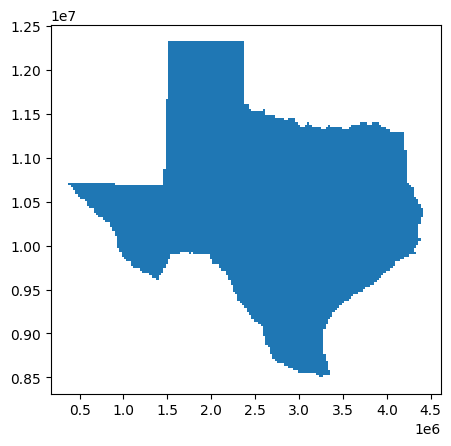

In [ ]:
# show the shape of wildfire grid
Grid.plot()

<Axes: >

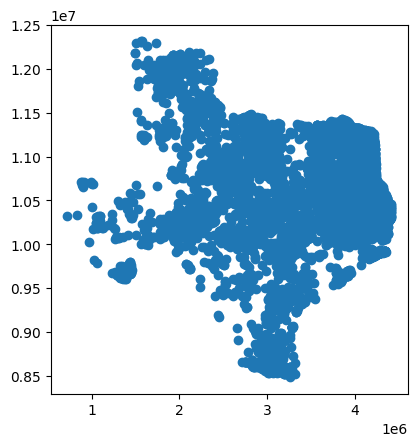

In [ ]:
# import wildfire shpfile
wildfire = gpd.read_file("UrbanDS_Team-main/Data/WildfireIncidentsTexas/WildfireIncidentsTexas.shp")
# wildfire = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/WildfireIncidentsTexas/WildfireIncidentsTexas.shp")
wildfire.to_crs(epsg=2277,inplace=True)
# show the points of wildfire incidents in Texas
wildfire.plot()

In [ ]:
# Clean and process wildfire incident data

## Keep the start date and end date of the wildfire
### FireDiscov - start date; FireOutDat - end date
wildfire = wildfire[['geometry','FireDiscov','FireOutDat']]
wildfire['StartDate'] = pd.to_datetime(wildfire['FireDiscov'])
wildfire['EndDate'] = pd.to_datetime(wildfire['FireOutDat'])
wildfire['Duration'] = (wildfire['EndDate'] - wildfire['StartDate']).dt.days
print(len(wildfire))
## if the fire did not last for 1 day, set it to 1 day
wildfire['DurationAdj'] = wildfire['Duration']+1
wildfire['Year'] = wildfire['StartDate'].dt.year
# print(wildfire.head())

## Select the data from 2014 to 2022
wildfire = wildfire[(wildfire['Year']>2013)&(wildfire['Year']<2023)] 

## Calculate the yearly average duration for the incidents that has an end date
## And set the null value to the yearly average duration
temp = wildfire[wildfire['Duration'].notnull()]
meanByYear = temp.groupby("Year")["DurationAdj"].mean().reset_index()
meanByYear = meanByYear.rename({"DurationAdj":"MeanDuration"},axis=1)
wildfire = wildfire.merge(meanByYear, on='Year')
print(len(wildfire))
# print(wildfire.head())
wildfire['DurationFinal'] = wildfire.apply(lambda x: x['MeanDuration'] if np.isnan(x['DurationAdj']) else x['DurationAdj'] , axis=1)
print(len(wildfire))
wildfire.sample(20)

8559
8559
8559


geometry  FireDiscov  FireOutDat  StartDate  \
3726  POINT (3732166.740 10204468.589)  2022-02-07         NaN 2022-02-07   
3108  POINT (3605413.467 11044868.228)  2018-06-26  2018-07-02 2018-06-26   
1167  POINT (4057478.768 10214623.150)  2017-02-05  2017-02-05 2017-02-05   
6229  POINT (4157132.722 10212506.424)  2020-03-09         NaN 2020-03-09   
5801  POINT (3942376.415 10673693.241)  2022-02-16  2022-02-17 2022-02-16   
930   POINT (1832600.164 11908707.176)  2017-11-17  2017-11-19 2017-11-17   
5106  POINT (3895226.715 10691466.640)  2022-09-24  2022-09-26 2022-09-24   
7442  POINT (3325559.968 10221885.897)  2019-08-12  2019-08-14 2019-08-12   
3981   POINT (2328839.067 9785935.928)  2022-03-27  2022-04-05 2022-03-27   
2732  POINT (4074978.191 10430235.223)  2018-03-08         NaN 2018-03-08   
5509  POINT (3834510.723 10694452.184)  2022-06-22  2022-06-25 2022-06-22   
2847  POINT (2870247.073 11375701.575)  2018-08-05  2018-08-08 2018-08-05   
5278  POINT (1837199.210 11889195.957)  2022-02-27  2022-02-28 2022-02-27   
2268  POINT (4177641.089 10432666.809)  2016-05-16  2016-05-17 2016-05-16   
1449  POINT (4002591.354 11006361.185)  2017-11-24  2017-11-25 2017-11-24   
4889  POINT (4113983.151 11037612.844)  2022-07-25  2022-07-28 2022-07-25   
5191  POINT (4029025.831 10631139.271)  2022-08-06  2022-08-10 2022-08-06   
3466  POINT (2280031.351 11604879.321)  2018-02-25         NaN 2018-02-25   
6626  POINT (4095817.217 10659074.670)  2020-06-20  2020-06-22 2020-06-20   
7227   POINT (3007072.520 8854454.098)  2019-07-24  2019-07-28 2019-07-24   

        EndDate  Duration  DurationAdj  Year  MeanDuration  DurationFinal  
3726        NaT       NaN          NaN  2022      5.279165       5.279165  
3108 2018-07-02       6.0          7.0  2018      5.053121       7.000000  
1167 2017-02-05       0.0          1.0  2017      3.130486       1.000000  
6229        NaT       NaN          NaN  2020      4.761548       4.761548  
5801 2022-02-17       1.0          2.0  2022      5.279165       2.000000  
930  2017-11-19       2.0          3.0  2017      3.130486       3.000000  
5106 2022-09-26       2.0          3.0  2022      5.279165       3.000000  
7442 2019-08-14       2.0          3.0  2019      4.509868       3.000000  
3981 2022-04-05       9.0         10.0  2022      5.279165      10.000000  
2732        NaT       NaN          NaN  2018      5.053121       5.053121  
5509 2022-06-25       3.0          4.0  2022      5.279165       4.000000  
2847 2018-08-08       3.0          4.0  2018      5.053121       4.000000  
5278 2022-02-28       1.0          2.0  2022      5.279165       2.000000  
2268 2016-05-17       1.0          2.0  2016      3.825444       2.000000  
1449 2017-11-25       1.0          2.0  2017      3.130486       2.000000  
4889 2022-07-28       3.0          4.0  2022      5.279165       4.000000  
5191 2022-08-10       4.0          5.0  2022      5.279165       5.000000  
3466        NaT       NaN          NaN  2018      5.053121       5.053121  
6626 2020-06-22       2.0          3.0  2020      4.761548       3.000000  
7227 2019-07-28       4.0          5.0  2019      4.509868       5.000000

In [ ]:
# Spatial Join to Get the Total Wildfire Duration for Each Grid
join = Grid.sjoin(wildfire,predicate="intersects")
sumDuration = join.groupby("IDcw")['DurationFinal'].sum()
Grid = Grid.merge(sumDuration, left_on='IDcw',right_index=True,how="left")
Grid = Grid.rename({"DurationFinal":'DurationTotal'}, axis=1)
Grid

IDcw     Shape_Leng    Shape_Area  \
0        445  105600.000086  6.969600e+08   
1        446  105600.000086  6.969600e+08   
2        609  105600.000086  6.969600e+08   
3        610  105600.000086  6.969600e+08   
4        611  105600.000086  6.969600e+08   
...      ...            ...           ...   
10399  24168  105600.000086  6.969600e+08   
10400  24169  105600.000086  6.969600e+08   
10401  24170  105600.000086  6.969600e+08   
10402  24171  105600.000086  6.969600e+08   
10403  24172  105600.000086  6.969600e+08   

                                                geometry  DurationTotal  
0      POLYGON ((3223024.821 8500723.916, 3223024.821...            NaN  
1      POLYGON ((3249424.821 8500723.916, 3249424.821...       3.825444  
2      POLYGON ((3196624.821 8527123.916, 3196624.821...            NaN  
3      POLYGON ((3223024.821 8527123.916, 3223024.821...            NaN  
4      POLYGON ((3249424.821 8527123.916, 3249424.821...            NaN  
...                                                  ...            ...  
10399  POLYGON ((2246224.821 12302323.916, 2246224.82...            NaN  
10400  POLYGON ((2272624.821 12302323.916, 2272624.82...            NaN  
10401  POLYGON ((2299024.821 12302323.916, 2299024.82...            NaN  
10402  POLYGON ((2325424.821 12302323.916, 2325424.82...            NaN  
10403  POLYGON ((2351824.821 12302323.916, 2351824.82...            NaN  

[10404 rows x 5 columns]

In [ ]:
# Calculate normalized Wildfire Duration Index for Each Grid
Grid['WDD'] = Grid['DurationTotal'] / 9
Grid = Grid.fillna(0)
# Grid['nWDI'] = (Grid['WDI'] - Grid['WDI'].min()) / (Grid['WDI'].max() - Grid['WDI'].min())
# Grid.head()

10404


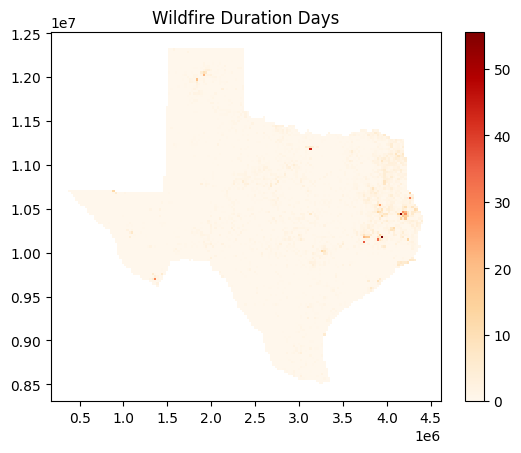

In [ ]:
print(len(Grid))
Grid = Grid.drop(columns=['Shape_Area',"Shape_Leng"])
# ## Plot the nWRI
Grid.plot(column='WDD',cmap="OrRd",legend=True)
plt.title("Wildfire Duration Days")
plt.show()

# 2 Processing risk factors for Wildfire


## 2.1 Road length By Weishan

In [ ]:
#read roda shapefile

#The address of Texas Roadway Linework Shapefile: https://drive.google.com/drive/folders/1_Lh7jhT6qf4dLlBd0ndD_ty5E9D0gF7D?usp=share_link
road_shp = gpd.read_file("The filepath of TxDOT_Roadway_Linework.shp")
# road_shp = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/Texas_road_WB/TxDOT_Roadway_Linework.shp")

In [ ]:
road_shp.to_crs(epsg=2277,inplace=True)

<Axes: >

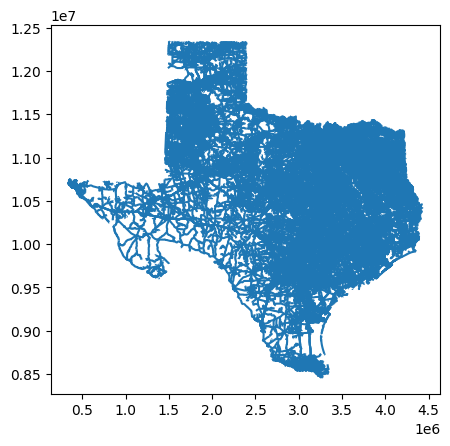

In [ ]:
road_shp.plot()

In [ ]:
# about 2 mins
clipped_roads = gpd.clip(road_shp, Grid)

joined = gpd.sjoin(clipped_roads, Grid, op="intersects")
grouped = joined.groupby("IDcw")["geometry"].agg(lambda x: x.length.sum())
Grid = Grid.join(grouped, on="IDcw", rsuffix="_length")
Grid = Grid.rename(columns={"geometry_length": "road_length_miles"})

In [ ]:
# feet to mile
Grid['road_length_miles'] = Grid['road_length_miles']/5280

In [ ]:
print(len(Grid))
Grid

10404


IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  
0           0.000000  0.000000         383.767234  
1           3.825444  0.425049          78.344184  
2           0.000000  0.000000         252.491244  
3           0.000000  0.000000         143.711420  
4           0.000000  0.000000          63.854813  
...              ...       ...                ...  
10399       0.000000  0.000000         182.078767  
10400       0.000000  0.000000         155.762376  
10401       0.000000  0.000000         168.743059  
10402       0.000000  0.000000         179.709340  
10403       0.000000  0.000000         197.136519  

[10404 rows x 5 columns]

In [ ]:
# Grid.to_file('/content/drive/MyDrive/Data science competition/WB/Grid_chunwu_road.shp')

##2.2 Population from Landscan Population Data by Weishan
- Raster data clipped by grid in Arcgis
    

In [ ]:
import rasterio as rs

#Reaf Raster data of landscan population to create a dataframe with the centroid coordinate and the pixel value (the number of population)
# with rs.open("/content/drive/MyDrive/Data science competition/Data/landscan-global-2018-assets/landscan-Texas-2018.tif") as src:
with rs.open("UrbanDS_Team-main/Data/landscan-global-2018-assets/landscan-Texas-2018.tif") as src:
    transform = src.transform
    crs = src.crs
    band = src.read(1)  
print(band.shape)

rows, cols = np.indices(band.shape)
x_coords = cols * transform.a + transform.c + transform.a / 2
y_coords = rows * transform.e + transform.f + transform.e / 2
pix = {'x': x_coords.flatten(),
        'y': y_coords.flatten(),
        'pixel_value': band.flatten()}
df_pix = pd.DataFrame(pix)

df_pix

(1273, 1629)


x          y  pixel_value
0       -106.795833  36.454167            0
1       -106.787500  36.454167            0
2       -106.779167  36.454167            0
3       -106.770833  36.454167            0
4       -106.762500  36.454167            0
...             ...        ...          ...
2073712  -93.262500  25.854167            0
2073713  -93.254167  25.854167            0
2073714  -93.245833  25.854167            0
2073715  -93.237500  25.854167            0
2073716  -93.229167  25.854167            0

[2073717 rows x 3 columns]

In [ ]:
df_pix_vaild = df_pix[df_pix['pixel_value'] >= 0]

In [ ]:
df_pix_vaild['pixel_value'].sum()

41890412

In [ ]:
pixel_gpf = gpd.GeoDataFrame(df_pix_vaild, geometry=gpd.points_from_xy(df_pix_vaild.x, df_pix_vaild.y), crs="EPSG:4326")

In [ ]:
pixel_gpf

x          y  pixel_value                     geometry
0       -106.795833  36.454167            0  POINT (-106.79583 36.45417)
1       -106.787500  36.454167            0  POINT (-106.78750 36.45417)
2       -106.779167  36.454167            0  POINT (-106.77917 36.45417)
3       -106.770833  36.454167            0  POINT (-106.77083 36.45417)
4       -106.762500  36.454167            0  POINT (-106.76250 36.45417)
...             ...        ...          ...                          ...
2073712  -93.262500  25.854167            0   POINT (-93.26250 25.85417)
2073713  -93.254167  25.854167            0   POINT (-93.25417 25.85417)
2073714  -93.245833  25.854167            0   POINT (-93.24583 25.85417)
2073715  -93.237500  25.854167            0   POINT (-93.23750 25.85417)
2073716  -93.229167  25.854167            0   POINT (-93.22917 25.85417)

[1999272 rows x 4 columns]

In [ ]:
# about 3 mins
#Steps above to process the extremum and trandform the coordinate system
pixel_gpf_trans = pixel_gpf.to_crs(Grid.crs)

In [ ]:
pixel_gpf_trans['pixel_value'].sum()

41890412

In [ ]:
#If the center point of the pixel is in the grid, the pixel values will be accumulated.

Grid['population_sum'] = 0
for index, row in Grid.iterrows():
    mask = pixel_gpf_trans.within(row.geometry)
    Grid.loc[index, 'population_sum'] = pixel_gpf_trans.loc[mask, 'pixel_value'].sum()
Grid

IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  
0           0.000000  0.000000         383.767234           41386  
1           3.825444  0.425049          78.344184            3426  
2           0.000000  0.000000         252.491244            5893  
3           0.000000  0.000000         143.711420           12423  
4           0.000000  0.000000          63.854813             855  
...              ...       ...                ...             ...  
10399       0.000000  0.000000         182.078767              22  
10400       0.000000  0.000000         155.762376             359  
10401       0.000000  0.000000         168.743059             103  
10402       0.000000  0.000000         179.709340              36  
10403       0.000000  0.000000         197.136519             570  

[10404 rows x 6 columns]

In [ ]:
Grid['population_sum'].sum()

27492813

In [ ]:
# add two attributes: population sum, road length miles
print(len(Grid))
Grid

10404


IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  
0           0.000000  0.000000         383.767234           41386  
1           3.825444  0.425049          78.344184            3426  
2           0.000000  0.000000         252.491244            5893  
3           0.000000  0.000000         143.711420           12423  
4           0.000000  0.000000          63.854813             855  
...              ...       ...                ...             ...  
10399       0.000000  0.000000         182.078767              22  
10400       0.000000  0.000000         155.762376             359  
10401       0.000000  0.000000         168.743059             103  
10402       0.000000  0.000000         179.709340              36  
10403       0.000000  0.000000         197.136519             570  

[10404 rows x 6 columns]

## 2.3 Get the distance of fire station to the Grid By Weishan
- Search fire station from gooogle map, calculate distance

In [ ]:
!pip install googlemaps

In [ ]:
import googlemaps
import time
import pandas as pd
import numpy as np

In [ ]:
# To run this craw code, please use your api key instead.

api_key = "AIzaSyAOqM11-O0Y5t3d-DtcYzc6oPpB8-Z8hx"


gmaps = googlemaps.Client(key=api_key)

min_lat, max_lat = 25.84, 36.50
min_lng, max_lng = -106.65, -93.51


grid_sizes = [20, 30]
search_radii = [20000, 30000]


fire_stations_df = pd.DataFrame(columns=["name", "types", "latitude", "longitude"])

for grid_size in grid_sizes:
    for search_radius in search_radii:
       
        lat_step = (max_lat - min_lat) / grid_size
        lng_step = (max_lng - min_lng) / grid_size

        
        lat_range = np.arange(min_lat, max_lat, lat_step)
        lng_range = np.arange(min_lng, max_lng, lng_step)

       
        for lat in lat_range:
            for lng in lng_range:
                location = (lat + lat_step / 2, lng + lng_step / 2)
                results = []
                next_page_token = None

                while True:
                    response = gmaps.places_nearby(location=location, radius=search_radius, type="fire_station", page_token=next_page_token)
                    results.extend(response["results"])
                    next_page_token = response.get("next_page_token")

                    if next_page_token:
                        time.sleep(2)  
                    else:
                        break

                
                if len(response["results"]) >= 20:
                    print(f"need more search：location({lat:.2f}, {lng:.2f})，grid_size{grid_size}，search_radii{search_radius}miles")

                
                for result in results:
                    name = result["name"]
                    types = ", ".join(result["types"])
                    latitude = result["geometry"]["location"]["lat"]
                    longitude = result["geometry"]["location"]["lng"]

                    fire_stations_df = fire_stations_df.append({"name": name, "types": types, "latitude": latitude, "longitude": longitude}, ignore_index=True)


fire_stations_df.drop_duplicates(subset=["latitude", "longitude"], inplace=True)

In [ ]:
!pip install folium

In [ ]:
import folium

In [ ]:
#Results visualization
map_texas = folium.Map(location=[31.9686, -99.9018], zoom_start=6)

for index, row in fire_stations_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=row["name"]).add_to(map_texas)

map_texas

In [ ]:
fire_stations_df

name  \
0     Dirección de Protección Civil Salinas Victoria   
1                          Harlingen Fire Station #7   
2                           La Feria Fire Department   
3                            Federal Signal 2001-130   
4                          Harlingen fire station #2   
...                                              ...   
8081                            Enid Fire Department   
8085                            Enid Fire Department   
8094                          Goltry Fire Department   
8095               Hillsdale Carrier Fire Department   
8096                          Helena Fire Department   

                                               types   latitude   longitude  
0     fire_station, point_of_interest, establishment  25.968411 -100.300540  
1     fire_station, point_of_interest, establishment  26.181979  -97.721223  
2     fire_station, point_of_interest, establishment  26.158969  -97.823071  
3     fire_station, point_of_interest, establishment  26.158784  -97.823246  
4     fire_station, point_of_interest, establishment  26.181603  -97.758394  
...                                              ...        ...         ...  
8081  fire_station, point_of_interest, establishment  36.391214  -97.883437  
8085  fire_station, point_of_interest, establishment  36.418367  -97.878859  
8094  fire_station, point_of_interest, establishment  36.532755  -98.152616  
8095  fire_station, point_of_interest, establishment  36.562313  -97.991682  
8096  fire_station, point_of_interest, establishment  36.546611  -98.269739  

[2930 rows x 4 columns]

In [ ]:
fire_gpf = gpd.GeoDataFrame(fire_stations_df, geometry=gpd.points_from_xy(fire_stations_df.longitude, fire_stations_df.latitude), crs="EPSG:4326")
fire_gpf

name  \
0     Dirección de Protección Civil Salinas Victoria   
1                          Harlingen Fire Station #7   
2                           La Feria Fire Department   
3                            Federal Signal 2001-130   
4                          Harlingen fire station #2   
...                                              ...   
8081                            Enid Fire Department   
8085                            Enid Fire Department   
8094                          Goltry Fire Department   
8095               Hillsdale Carrier Fire Department   
8096                          Helena Fire Department   

                                               types   latitude   longitude  \
0     fire_station, point_of_interest, establishment  25.968411 -100.300540   
1     fire_station, point_of_interest, establishment  26.181979  -97.721223   
2     fire_station, point_of_interest, establishment  26.158969  -97.823071   
3     fire_station, point_of_interest, establishment  26.158784  -97.823246   
4     fire_station, point_of_interest, establishment  26.181603  -97.758394   
...                                              ...        ...         ...   
8081  fire_station, point_of_interest, establishment  36.391214  -97.883437   
8085  fire_station, point_of_interest, establishment  36.418367  -97.878859   
8094  fire_station, point_of_interest, establishment  36.532755  -98.152616   
8095  fire_station, point_of_interest, establishment  36.562313  -97.991682   
8096  fire_station, point_of_interest, establishment  36.546611  -98.269739   

                         geometry  
0     POINT (-100.30054 25.96841)  
1      POINT (-97.72122 26.18198)  
2      POINT (-97.82307 26.15897)  
3      POINT (-97.82325 26.15878)  
4      POINT (-97.75839 26.18160)  
...                           ...  
8081   POINT (-97.88344 36.39121)  
8085   POINT (-97.87886 36.41837)  
8094   POINT (-98.15262 36.53275)  
8095   POINT (-97.99168 36.56231)  
8096   POINT (-98.26974 36.54661)  

[2930 rows x 5 columns]

In [ ]:
fire_station_trans

name  \
0     Dirección de Protección Civil Salinas Victoria   
1                          Harlingen Fire Station #7   
2                           La Feria Fire Department   
3                            Federal Signal 2001-130   
4                          Harlingen fire station #2   
...                                              ...   
8081                            Enid Fire Department   
8085                            Enid Fire Department   
8094                          Goltry Fire Department   
8095               Hillsdale Carrier Fire Department   
8096                          Helena Fire Department   

                                               types   latitude   longitude  \
0     fire_station, point_of_interest, establishment  25.968411 -100.300540   
1     fire_station, point_of_interest, establishment  26.181979  -97.721223   
2     fire_station, point_of_interest, establishment  26.158969  -97.823071   
3     fire_station, point_of_interest, establishment  26.158784  -97.823246   
4     fire_station, point_of_interest, establishment  26.181603  -97.758394   
...                                              ...        ...         ...   
8081  fire_station, point_of_interest, establishment  36.391214  -97.883437   
8085  fire_station, point_of_interest, establishment  36.418367  -97.878859   
8094  fire_station, point_of_interest, establishment  36.532755  -98.152616   
8095  fire_station, point_of_interest, establishment  36.562313  -97.991682   
8096  fire_station, point_of_interest, establishment  36.546611  -98.269739   

                              geometry  
0      POINT (2307397.355 8495809.552)  
1      POINT (3156049.418 8583799.660)  
2      POINT (3122733.432 8574638.293)  
3      POINT (3122677.204 8574569.608)  
4      POINT (3143824.304 8583377.457)  
...                                ...  
8081  POINT (3020802.508 12299968.037)  
8085  POINT (3021936.507 12309924.647)  
8094  POINT (2940226.300 12350064.628)  
8095  POINT (2987491.932 12361839.254)  
8096  POINT (2905567.176 12354472.236)  

[2930 rows x 5 columns]

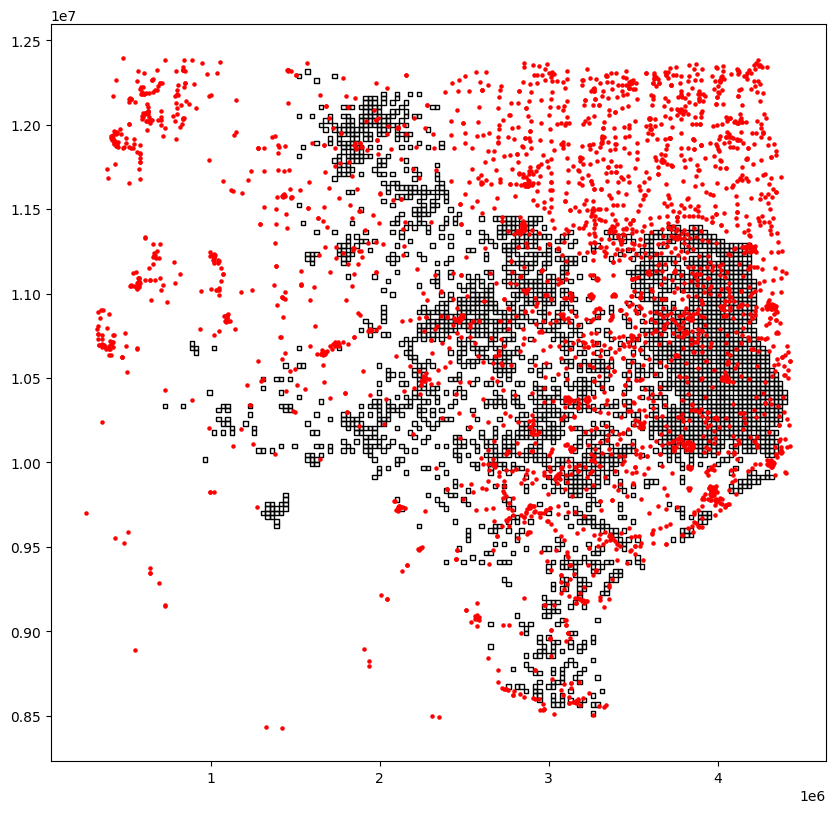

In [ ]:
points = fire_station_trans
polygons = Grid
fig, ax = plt.subplots(figsize=(10, 10))
polygons.plot(ax=ax, facecolor='none', edgecolor='black')
points.plot(ax=ax, color='red', markersize=5)
plt.show()

In [ ]:
# the distance from the nearest fire station in the grid(Unit:mile)
from shapely.ops import nearest_points
from shapely.geometry import Point
nearest_distances = []
for i, row in Grid.iterrows():
    nearest_point = fire_station_trans.geometry.distance(row.geometry.centroid).idxmin()
    nearest_distance = row.geometry.centroid.distance(fire_station_trans.loc[nearest_point].geometry)
    nearest_distances.append(nearest_distance)

Grid['dist_to_fire_station'] = nearest_distances
Grid['dist_to_fire_station'] = Grid['dist_to_fire_station']/5280

Grid

IDcw     Shape_Leng    Shape_Area  \
1        446  105600.000086  6.969600e+08   
9        767  105599.999429  6.969600e+08   
10       768  105599.999429  6.969600e+08   
11       769  105599.999430  6.969600e+08   
15       773  105599.999430  6.969600e+08   
...      ...            ...           ...   
10233  23342  105600.000086  6.969600e+08   
10309  23814  105600.000086  6.969600e+08   
10338  23975  105600.000086  6.969600e+08   
10346  23983  105600.000086  6.969600e+08   
10373  24142  105600.000086  6.969600e+08   

                                                geometry  DurationTotal  \
1      POLYGON ((3249424.821 8500723.916, 3249424.821...       3.825444   
9      POLYGON ((3011824.821 8553523.916, 3011824.821...       5.279165   
10     POLYGON ((3038224.821 8553523.916, 3038224.821...       6.825444   
11     POLYGON ((3064624.821 8553523.916, 3064624.821...       2.705460   
15     POLYGON ((3170224.821 8553523.916, 3170224.821...       2.705460   
...                                                  ...            ...   
10233  POLYGON ((2219824.821 12170323.916, 2219824.82...       3.130486   
10309  POLYGON ((1612624.821 12249523.916, 1612624.82...       1.000000   
10338  POLYGON ((1507024.821 12275923.916, 1507024.82...       2.000000   
10346  POLYGON ((1718224.821 12275923.916, 1718224.82...      15.000000   
10373  POLYGON ((1559824.821 12302323.916, 1559824.82...      14.000000   

            WRI      nWRI  population_sum  road_length_miles  dis_to_park  \
1      0.001165  0.005654            3426          52.548408          0.0   
9      0.001607  0.008563           15588         147.965248          0.0   
10     0.002078  0.011658           28508         286.919294          0.0   
11     0.000824  0.003413           45910         337.433668          0.0   
15     0.000824  0.003413           27948         225.027745          0.0   
...         ...       ...             ...                ...          ...   
10233  0.000953  0.004263               8          47.594162          0.0   
10309  0.000304  0.000000               2           1.244335          0.0   
10338  0.000609  0.002001              12          80.953630          0.0   
10346  0.004566  0.028016               3          14.357720          0.0   
10373  0.004262  0.026015               0          20.097739          0.0   

       nearest_distance                                           distance  \
1                   0.0  0       0.0
1       0.0
2       0.0
3       0....   
9                   0.0  0       0.0
1       0.0
2       0.0
3       0....   
10                  0.0  0       0.0
1       0.0
2       0.0
3       0....   
11                  0.0  0       0.0
1       0.0
2       0.0
3       0....   
15                  0.0  0       0.0
1       0.0
2       0.0
3       0....   
...                 ...                                                ...   
10233               0.0  0       0.0
1       0.0
2       0.0
3       0....   
10309               0.0  0       0.0
1       0.0
2       0.0
3       0....   
10338               0.0  0       0.0
1       0.0
2       0.0
3       0....   
10346               0.0  0       0.0
1       0.0
2       0.0
3       0....   
10373               0.0  0       0.0
1       0.0
2       0.0
3       0....   

       nearest_distance2  dist_to_fire_station  
1               0.000000              2.251386  
9           41583.800431             11.137301  
10          46256.997100             11.853285  
11          31652.382290              8.623751  
15              0.000000              0.778694  
...                  ...                   ...  
10233       62628.333258             15.344088  
10309       70990.699091             16.349330  
10338        3541.960166              3.346150  
10346       38076.964647             10.039968  
10373       34388.202731              9.025694  

[2926 rows x 14 columns]

In [ ]:
Grid

IDcw     Shape_Leng    Shape_Area  \
1        446  105600.000086  6.969600e+08   
9        767  105599.999429  6.969600e+08   
10       768  105599.999429  6.969600e+08   
11       769  105599.999430  6.969600e+08   
15       773  105599.999430  6.969600e+08   
...      ...            ...           ...   
10233  23342  105600.000086  6.969600e+08   
10309  23814  105600.000086  6.969600e+08   
10338  23975  105600.000086  6.969600e+08   
10346  23983  105600.000086  6.969600e+08   
10373  24142  105600.000086  6.969600e+08   

                                                geometry  DurationTotal  \
1      POLYGON ((3249424.821 8500723.916, 3249424.821...       3.825444   
9      POLYGON ((3011824.821 8553523.916, 3011824.821...       5.279165   
10     POLYGON ((3038224.821 8553523.916, 3038224.821...       6.825444   
11     POLYGON ((3064624.821 8553523.916, 3064624.821...       2.705460   
15     POLYGON ((3170224.821 8553523.916, 3170224.821...       2.705460   
...                                                  ...            ...   
10233  POLYGON ((2219824.821 12170323.916, 2219824.82...       3.130486   
10309  POLYGON ((1612624.821 12249523.916, 1612624.82...       1.000000   
10338  POLYGON ((1507024.821 12275923.916, 1507024.82...       2.000000   
10346  POLYGON ((1718224.821 12275923.916, 1718224.82...      15.000000   
10373  POLYGON ((1559824.821 12302323.916, 1559824.82...      14.000000   

            WRI      nWRI  population_sum  road_length_miles  \
1      0.001165  0.005654            3426          52.548408   
9      0.001607  0.008563           15588         147.965248   
10     0.002078  0.011658           28508         286.919294   
11     0.000824  0.003413           45910         337.433668   
15     0.000824  0.003413           27948         225.027745   
...         ...       ...             ...                ...   
10233  0.000953  0.004263               8          47.594162   
10309  0.000304  0.000000               2           1.244335   
10338  0.000609  0.002001              12          80.953630   
10346  0.004566  0.028016               3          14.357720   
10373  0.004262  0.026015               0          20.097739   

       dist_to_fire_station  
1                  2.251386  
9                 11.137301  
10                11.853285  
11                 8.623751  
15                 0.778694  
...                     ...  
10233             15.344088  
10309             16.349330  
10338              3.346150  
10346             10.039968  
10373              9.025694  

[2926 rows x 10 columns]

## 2.4 Calculate the Distance of the Grid to Texas State Park By Weishan

In [ ]:
#https://tpwd.texas.gov/gis/ to find the geospatial data of Texas State Park

In [ ]:
print(len(Grid))
Grid

10404


IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  
0           0.000000  0.000000         383.767234           41386  
1           3.825444  0.425049          78.344184            3426  
2           0.000000  0.000000         252.491244            5893  
3           0.000000  0.000000         143.711420           12423  
4           0.000000  0.000000          63.854813             855  
...              ...       ...                ...             ...  
10399       0.000000  0.000000         182.078767              22  
10400       0.000000  0.000000         155.762376             359  
10401       0.000000  0.000000         168.743059             103  
10402       0.000000  0.000000         179.709340              36  
10403       0.000000  0.000000         197.136519             570  

[10404 rows x 6 columns]

In [ ]:
#Download the state park boundaries
import zipfile
import shapefile
import io
import urllib.request


url = 'https://tpwd.texas.gov/gis/resources/tpwd-statepark-boundaries.zip'
response = urllib.request.urlopen(url)

zip_file = zipfile.ZipFile(io.BytesIO(response.read()))
zip_file.extractall()
# only work when have one shapefile
for name in zip_file.namelist():
    if name.endswith('.shp'):
        print(name)
gdf_park = gpd.read_file(name)
gdf_park

TPWDStateParksBoundary/TPWDStateParksBoundary.shp


OBJECTID     SHAPE_Leng                    LoName BndryType   County1  \
0           1  206335.263359  Caprock Canyons Trailway        SP      Hall   
1           2   42226.708003        Caprock Canyons SP        SP   Briscoe   
2           3   12926.550764          Copper Breaks SP        SP  Hardeman   
3           4    9472.503099          Lake Tawakoni SP        SP      Hunt   
4           5   14159.453172     Lake Colorado City SP        SP  Mitchell   
..        ...            ...                       ...       ...       ...   
114       116   26998.426430              Inks Lake SP        SP    Burnet   
115       117    7074.722228  Fort Richardson SP & SHS    SP/SHS      Jack   
116       118    1984.201293           Fort Leaton SHS       SHS  Presidio   
117       119    9437.454437      Martin Creek Lake SP        SP      Rusk   
118       120   11394.811621         Lake Arrowhead SP        SP      Clay   

      County2 County3  County4     CalcAcres Comments           Availabili  \
0     Briscoe   Floyd      NaN   1164.783013      NaN  Open for Public Use   
1         NaN     NaN      NaN  13955.672457      NaN  Open for Public Use   
2         NaN     NaN      NaN   1921.903407      NaN  Open for Public Use   
3    VanZandt     NaN      NaN    435.215596      NaN  Open for Public Use   
4         NaN     NaN      NaN    588.403676      NaN  Open for Public Use   
..        ...     ...      ...           ...      ...                  ...   
114     Llano     NaN      NaN   1194.434491      NaN  Open for Public Use   
115       NaN     NaN      NaN    380.765214      NaN  Open for Public Use   
116       NaN     NaN      NaN     23.818662      NaN  Open for Public Use   
117       NaN     NaN      NaN    291.058108      NaN  Open for Public Use   
118       NaN     NaN      NaN    573.802929      NaN  Open for Public Use   

          UseType     Shape_Le_1    Shape_Area  \
0        Trailway  206335.263359  4.713710e+06   
1       Overnight   42226.708003  5.647660e+07   
2       Overnight   12926.550764  7.777667e+06   
3       Overnight    9472.503099  1.761255e+06   
4       Overnight   14159.453172  2.381185e+06   
..            ...            ...           ...   
114     Overnight   26998.426430  4.833705e+06   
115     Overnight    7074.722228  1.540902e+06   
116  Day Use Only    1984.201293  9.639071e+04   
117     Overnight    9437.454437  1.177870e+06   
118     Overnight   11394.811621  2.322098e+06   

                                              geometry  
0    POLYGON ((933284.237 1369391.559, 933299.298 1...  
1    POLYGON ((901114.112 1359264.166, 901117.375 1...  
2    POLYGON ((1023149.120 1327715.439, 1023138.321...  
3    POLYGON ((1374766.256 1192663.931, 1374956.998...  
4    POLYGON ((912073.862 1129418.663, 912598.877 1...  
..                                                 ...  
114  MULTIPOLYGON (((1155576.966 955862.606, 115518...  
115  MULTIPOLYGON (((1171114.397 1227294.713, 11711...  
116  MULTIPOLYGON (((581144.207 828622.951, 581276....  
117  MULTIPOLYGON (((1509234.219 1136103.483, 15092...  
118  POLYGON ((1149327.219 1288815.519, 1149697.306...  

[119 rows x 15 columns]

In [ ]:
gdf_park_trans = gdf_park.to_crs(Grid.crs)

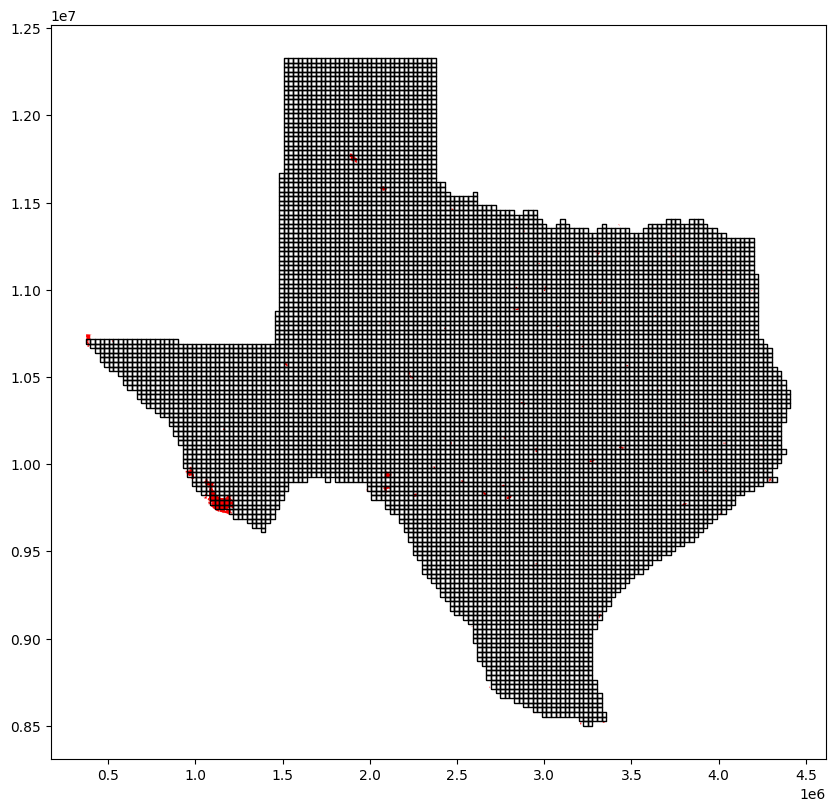

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_park_trans.plot(ax=ax, color='red', markersize=5)
Grid.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()

In [ ]:
#Caculate the nearest distance from the center of state parks to each grid (unit:mile)

from shapely.ops import nearest_points
from shapely.geometry import Point
nearest_distances = []
for i, row in Grid.iterrows():
    nearest_point = gdf_park_trans.geometry.distance(row.geometry.centroid).idxmin()
    nearest_distance = row.geometry.centroid.distance(gdf_park_trans.loc[nearest_point].geometry.centroid)
    nearest_distances.append(nearest_distance)

Grid['dist_to_park'] = nearest_distances
Grid['dist_to_park'] = Grid['dist_to_park']/5280

Grid

IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  \
0           0.000000  0.000000         383.767234           41386   
1           3.825444  0.425049          78.344184            3426   
2           0.000000  0.000000         252.491244            5893   
3           0.000000  0.000000         143.711420           12423   
4           0.000000  0.000000          63.854813             855   
...              ...       ...                ...             ...   
10399       0.000000  0.000000         182.078767              22   
10400       0.000000  0.000000         155.762376             359   
10401       0.000000  0.000000         168.743059             103   
10402       0.000000  0.000000         179.709340              36   
10403       0.000000  0.000000         197.136519             570   

       dist_to_park  
0          5.082596  
1         10.082589  
2          5.012677  
3          7.138119  
4         11.259599  
...             ...  
10399    125.662558  
10400    128.407465  
10401    131.285475  
10402    134.288028  
10403    149.202342  

[10404 rows x 7 columns]

## 2.5 Distance to National Dispatch Office Locations By Weishan

In [ ]:
#https://opendata.arcgis.com/api/v3/datasets/42869f5d176f45ab8012d9e0334c6ea6_0/downloads/data?format=shp&spatialRefId=4326&where=1%3D1
# Download the shapefiles of national dispatch office

In [ ]:
import fiona
import os

url = 'https://opendata.arcgis.com/api/v3/datasets/42869f5d176f45ab8012d9e0334c6ea6_0/downloads/data?format=shp&spatialRefId=4326&where=1%3D1'
response = urllib.request.urlopen(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.read()))
zip_file.extractall()
filename = ''
for name in zip_file.namelist():
    if name.endswith('.shp'):
        filename = name
if filename:
    cwd = os.path.abspath(os.curdir)
    
  
    full_path = os.path.join(cwd, filename)
    gdf_dispatch = gpd.read_file(full_path)
    
else:
    print("No shapefile found in the downloaded data.")
gdf_dispatch

OBJECTID  GeometryID GACCUnitID                                 DispName  \
0           1         NaN    USGASAC  Alabama Interagency Coordination Center   
1           2         NaN    USAKACC         Chugach National Forest Dispatch   
2           3         NaN    USAKACC             Delta Area Forestry Dispatch   
3           4         NaN    USAKACC                  Fairbanks Area Dispatch   
4           5         NaN    USAKACC         Tongass National Forest Dispatch   
..        ...         ...        ...                                      ...   
144       145         NaN    USCORMC                            Regional GACC   
145       146         NaN   USCAOSCC                            Regional GACC   
146       147         NaN   USCAONCC                            Regional GACC   
147       148         NaN    USAKACC                            Regional GACC   
148       149         NaN    USMTNRC                            Regional GACC   

    DispUnitID                                     DispAddres DispTier  \
0      USALAIC                  2946 Chestnut, Montgomery, AL        3   
1     USAKCGFC                   161 E 1st Ave, Anchorage, AK        3   
2     USAKDASC  Mile 267.5 Richardson Hwy, Delta Junction, AK        3   
3     USAKFASC                3700 Airport Way, Fairbanks, AK        3   
4     USAKTNFC                  648 Mission St, Ketchikan, AK        3   
..         ...                                            ...      ...   
144        N/A               2850 Youngfield St, Lakewood, CO        2   
145        N/A             23300 Castle Street, Riverside, CA        2   
146        N/A                   6101 Airport Rd, Redding, CA        2   
147        N/A           1541 Gaffney Rd, Fort Wainwright, AK        2   
148        N/A                  5765 W Broadway, Missoula, MT        2   

    DispArea    DispContac          DispEmail          LatWGS84  \
0        NaN  334-241-8105                NaN  32.3667972320001   
1        NaN  907-743-9433                NaN  61.2215942770001   
2        NaN  907-895-4225                NaN  64.0686812600001   
3        NaN  907-451-2623                NaN      64.838116638   
4        NaN  907-228-6211                NaN          55.34166   
..       ...           ...                ...               ...   
144      NaN  800-494-2073                NaN      39.757741509   
145      NaN  800-995-3473                NaN      33.906741836   
146      NaN  530-226-2800                NaN      40.519604283   
147      NaN  800-237-3633                NaN       64.84074201   
148      NaN  406-329-4880  mtnrc@firenet.gov  46.9241416200001   

          LongWGS84                                           Comments  \
0      -86.26770541  Initial location from US Census Populated Plac...   
1     -149.88165216  Initial location from US Census Populated Plac...   
2    -145.744672835  Initial location from US Census Populated Plac...   
3     -147.81591412  Initial location from US Census Populated Plac...   
4    -131.643336249  Initial location from US Census Populated Plac...   
..              ...                                                ...   
144  -105.141447358  Initial location from IRWIN Duty Stations - 6/...   
145  -117.255063057  Initial location from US Census Populated Plac...   
146  -122.299314416  Initial location from US Census Populated Plac...   
147  -147.601805579  Initial location from IRWIN Duty Stations - 6/...   
148  -114.089667438  Initial location from US Census Populated Plac...   

     DateCurren      MapMethod                     geometry  
0    2020-08-28  Mixed Methods   POINT (-86.26771 32.36680)  
1    2020-09-25  Mixed Methods  POINT (-149.88168 61.22160)  
2    2020-08-28  Mixed Methods  POINT (-145.74470 64.06868)  
3    2020-07-24  Mixed Methods  POINT (-147.81594 64.83812)  
4    2020-07-24  Mixed Methods  POINT (-131.64335 55.34166)  
..          ...            ...                          ...  
144  2020-07-24

In [ ]:
gdf_dispatch_trans = gdf_dispatch.to_crs(Grid.crs)

In [ ]:
nearest_distances_dispatch = []
for i, row in Grid.iterrows():
    nearest_point = gdf_dispatch_trans.geometry.distance(row.geometry.centroid).idxmin()
    nearest_distance = row.geometry.centroid.distance(gdf_dispatch_trans.loc[nearest_point].geometry)
    nearest_distances_dispatch.append(nearest_distance)

Grid['dist_to_dispatch'] = nearest_distances_dispatch
Grid['dist_to_dispatch'] = Grid['dist_to_dispatch']/5280

Grid

IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  \
0           0.000000  0.000000         383.767234           41386   
1           3.825444  0.425049          78.344184            3426   
2           0.000000  0.000000         252.491244            5893   
3           0.000000  0.000000         143.711420           12423   
4           0.000000  0.000000          63.854813             855   
...              ...       ...                ...             ...   
10399       0.000000  0.000000         182.078767              22   
10400       0.000000  0.000000         155.762376             359   
10401       0.000000  0.000000         168.743059             103   
10402       0.000000  0.000000         179.709340              36   
10403       0.000000  0.000000         197.136519             570   

       dist_to_park  dist_to_dispatch  
0          5.082596        401.283326  
1         10.082589        399.470391  
2          5.012677        398.527017  
3          7.138119        396.638461  
4         11.259599        394.804197  
...             ...               ...  
10399    125.662558        264.974830  
10400    128.407465        269.309347  
10401    131.285475        273.666564  
10402    134.288028        278.045414  
10403    149.202342        282.444890  

[10404 rows x 8 columns]

In [ ]:
print(len(Grid))

10404


## 2.6 Nearest distance to Remote Automatic Weather Stations By Weishan
https://data-nifc.opendata.arcgis.com/

In [ ]:
# Grid = gpd.read_file('/content/drive/MyDrive/Data science competition/WB/Grid_WB.shp')
Grid

IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  \
0           0.000000  0.000000         383.767234           41386   
1           3.825444  0.425049          78.344184            3426   
2           0.000000  0.000000         252.491244            5893   
3           0.000000  0.000000         143.711420           12423   
4           0.000000  0.000000          63.854813             855   
...              ...       ...                ...             ...   
10399       0.000000  0.000000         182.078767              22   
10400       0.000000  0.000000         155.762376             359   
10401       0.000000  0.000000         168.743059             103   
10402       0.000000  0.000000         179.709340              36   
10403       0.000000  0.000000         197.136519             570   

       dist_to_park  dist_to_dispatch  
0          5.082596        401.283326  
1         10.082589        399.470391  
2          5.012677        398.527017  
3          7.138119        396.638461  
4         11.259599        394.804197  
...             ...               ...  
10399    125.662558        264.974830  
10400    128.407465        269.309347  
10401    131.285475        273.666564  
10402    134.288028        278.045414  
10403    149.202342        282.444890  

[10404 rows x 8 columns]

In [ ]:
#Download the shapefile of remote automatic weather station
import fiona
import os

url = 'https://opendata.arcgis.com/api/v3/datasets/29185087b4594a35abe059cbdbf97ee4_1/downloads/data?format=shp&spatialRefId=4326&where=1%3D1'
response = urllib.request.urlopen(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.read()))
zip_file.extractall()
filename = ''
for name in zip_file.namelist():
    if name.endswith('.shp'):
        filename = name
if filename:
    cwd = os.path.abspath(os.curdir)
    full_path = os.path.join(cwd, filename)
    gdf_weather = gpd.read_file(full_path)
    
else:
    print("No shapefile found in the downloaded data.")
gdf_weather

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



OBJECTID                StationNam      WXID  ObservedDa    NESSID  \
0            1                   NECEDAH  17372963  2023-01-09  8376139A   
1            2                   BISO-NP  17246242  2022-03-15  FA6321D4   
2            3                  KNOWLTON  16831540  2022-05-02  325AE3F8   
3            4                  BIG ROCK  17414417  2022-08-03  CA28F196   
4            5  SAN LUIS VALLEY PORTABLE  17567535  2022-05-06  32941370   
...        ...                       ...       ...         ...       ...   
6665      6675             ARF1 PORTABLE       NaN  2023-04-02       NaN   
6666      6676            RO PORTABLE #3  17319715  2023-04-02  3331E3C0   
6667      6677              GREEN SPRING  17094185  2023-04-02  CA21E4BC   
6668      6678               CHILLICOTHE  17366048  2023-04-02  61400010   
6669      6679             SELA PORTABLE       NaN  2023-04-02       NaN   

       NWSID  Elevation                                         SiteDescri  \
0     474301      950.0                                                NaN   
1     400902     1445.0                                                NaN   
2     244102     3320.0  SITE IS LOCATED ON A SMALL KNOLL APPROX. 30 YD...   
3      42310     1500.0                                                NaN   
4        NaN     9170.0  SLV Portable is located on the Conejos Peak Di...   
...      ...        ...                                                ...   
6665     NaN        NaN                                                NaN   
6666  290999     3865.0                         Bowl, SW Predominate Winds   
6667  043613     1108.0                                                NaN   
6668  337301      630.0                                                NaN   
6669     NaN        NaN                                                NaN   

      Latitude  Longitude  ... AirTempSta   FuelTemp RelativeHu  BatteryVol  \
0     44.02861  -90.08306  ...   6 deg. F   4 deg. F       83 %  13.2 volts   
1     36.47500  -84.65417  ...  41 deg. F  41 deg. F       75 %  12.9 volts   
2     46.30739 -105.02978  ...  55 deg. F    NO DATA       44 %  13.7 volts   
3     38.03944 -122.57000  ...  62 deg. F  65 deg. F       78 %  13.1 volts   
4     37.33111 -106.29250  ...  51 deg. F  48 deg. F       22 %    13 volts   
...        ...        ...  ...        ...        ...        ...         ...   
6665       NaN        NaN  ...  36 deg. F    NO DATA       30 %     NO DATA   
6666  43.56500 -116.20833  ...  34 deg. F  34 deg. F       88 %  12.8 volts   
6667  37.83418 -120.50311  ...  44 deg. F  41 deg. F       91 %  12.7 volts   
6668  39.38583  -82.98500  ...  37 deg. F  37 deg. F       88 %  12.9 volts   
6669       NaN        NaN  ...  35 deg. F    NO DATA       85 %     NO DATA   

      FuelMoistu   WindDirPea WindSpeedP SolarRadia StationID  \
0     19.2 (unk)  330 degrees      3 mph     2 w/m2  17372963   
1     12.6 (unk)  300 degrees      2 mph    37 w/m2  17246242   
2        NO DATA  198 degrees     22 mph   442 w/m2  16831540   
3     11.3 (unk)  115 degrees      6 mph   138 w/m2  17414417   
4      4.7 (unk)  318 degrees     14 mph    40 w/m2  17567535   
...          ...          ...        ...        ...       ...   
6665     NO DATA      NO DATA    NO DATA    NO DATA  17492801   
6666  11.3 (unk)  168 degrees      3 mph     0 w/m2  17319715   
6667  19.4 (unk)    5 degrees      5 mph     0 w/m2  17094185   
6668  22.7 (unk)  293 degrees     10 mph     1 w/m2  17366048   
6669     NO DATA      NO DATA    NO DATA    NO DATA  17787691   

                         geometry  
0      POINT (-90.08306 44.02861)  
1      POINT (-84.65417 36.47500)  
2     POINT (-105.02978 46.30739)  
3     POINT (-122.57000 38.03944)  
4     POINT (-106.29250 37.33111)  
...                           ...  
6665  POINT (-105.41350 39.94883)  
6666  POINT (-116.20833 43.56500)  
6667  POINT (-120.50311 37.83418)  
6668   POINT (-82.98500 39.38583)  
6669  POINT (-116.20833 43.565

In [ ]:
gdf_weather_trans = gdf_weather.to_crs(Grid.crs)

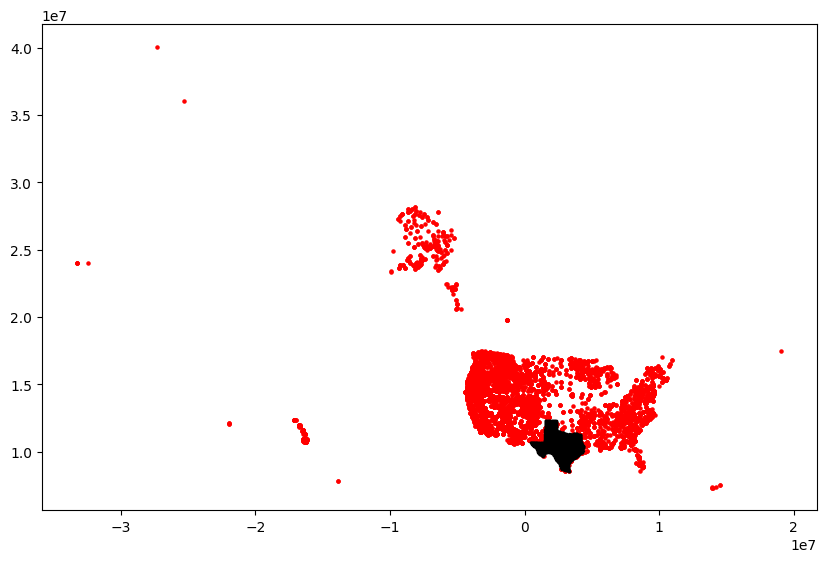

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_weather_trans.plot(ax=ax, color='red', markersize=5)
Grid.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()

In [ ]:
# calculate the distance from each grid to the nearest weather station(unit:mile)
nearest_distances_weather = []
for i, row in Grid.iterrows():
    nearest_point = gdf_weather_trans.geometry.distance(row.geometry.centroid).idxmin()
    nearest_distance = row.geometry.centroid.distance(gdf_weather_trans.loc[nearest_point].geometry)
    nearest_distances_weather.append(nearest_distance)

Grid['dist2weatherstation'] = nearest_distances_weather
Grid['dist2weatherstation'] = Grid['dist2weatherstation']/5280

Grid

IDcw                                           geometry  \
0        445  POLYGON ((3223024.821 8500723.916, 3223024.821...   
1        446  POLYGON ((3249424.821 8500723.916, 3249424.821...   
2        609  POLYGON ((3196624.821 8527123.916, 3196624.821...   
3        610  POLYGON ((3223024.821 8527123.916, 3223024.821...   
4        611  POLYGON ((3249424.821 8527123.916, 3249424.821...   
...      ...                                                ...   
10399  24168  POLYGON ((2246224.821 12302323.916, 2246224.82...   
10400  24169  POLYGON ((2272624.821 12302323.916, 2272624.82...   
10401  24170  POLYGON ((2299024.821 12302323.916, 2299024.82...   
10402  24171  POLYGON ((2325424.821 12302323.916, 2325424.82...   
10403  24172  POLYGON ((2351824.821 12302323.916, 2351824.82...   

       DurationTotal       WDD  road_length_miles  population_sum  \
0           0.000000  0.000000         383.767234           41386   
1           3.825444  0.425049          78.344184            3426   
2           0.000000  0.000000         252.491244            5893   
3           0.000000  0.000000         143.711420           12423   
4           0.000000  0.000000          63.854813             855   
...              ...       ...                ...             ...   
10399       0.000000  0.000000         182.078767              22   
10400       0.000000  0.000000         155.762376             359   
10401       0.000000  0.000000         168.743059             103   
10402       0.000000  0.000000         179.709340              36   
10403       0.000000  0.000000         197.136519             570   

       dist_to_park  dist_to_dispatch  dist2weatherstation  
0          5.082596        401.283326            18.765747  
1         10.082589        399.470391            17.264444  
2          5.012677        398.527017            17.637173  
3          7.138119        396.638461            14.386718  
4         11.259599        394.804197            12.364684  
...             ...               ...                  ...  
10399    125.662558        264.974830            60.387765  
10400    128.407465        269.309347            57.961169  
10401    131.285475        273.666564            55.877653  
10402    134.288028        278.045414            54.176813  
10403    149.202342        282.444890            52.895577  

[10404 rows x 9 columns]

In [ ]:
print(len(Grid))

10404


In [ ]:
Grid.to_file('/content/drive/MyDrive/Data science competition/WB/Grid_WB.shp')

Add 6 attributes
1. population in grid
2. total length of road in grid
3. nearest distance to fire station
4. nearest distance to state park
5. nearest distance to National Dispatch Office
6. nearest distance to Remote Automatic Weather Stations

Save Grid as a shapefile to:'/content/drive/MyDrive/Data science competition/WB/Grid_WB.shp' 

## 2.7 Download and Process data from NLDAS (North American Land Data Assimilation System) By Shoujia
- PS:need login password from NASA

In [ ]:
import requests
import os

In [ ]:
url = "https://github.com/UrbanDS/UrbanDS_Team/archive/refs/heads/main.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
# Need account from NASA and configure it on your own computer

Filepath = "UrbanDS_Team-main/Data/NLDAS_5feature"

txtfile = open(os.path.join(Filepath,"url.txt"))
lines = txtfile.readlines()

for line in lines:
    print(line)
    filepath_split = line.split('M.A')[1]
    filename = filepath_split.split('.')[0]

    result = requests.get(line)
    result.raise_for_status()
    f = open(Filepath + filename + ".grb", 'wb')
    f.write(result.content)
    f.close()
    print('contents of URL written to ' + Filepath + filename + ".grb")

Raster Feature to Shpfile

In [ ]:
import os
 
import geopandas as gpd
import numpy as np
import rasterio as rio
import rasterio.mask

In [ ]:
raster_file_path = "UrbanDS_Team-main/Data/NLDAS_Features_Year"

#If you already have the result shpfile from 2.6, run the file from Google Drive
# shp_file = "/content/drive/MyDrive/Data science competition/WB/Grid_WB.shp"

#If no, read the shpfile from github
shp_file = "UrbanDS_Team-main/Data/Grid_WB/Grid_WB.shp"

out_shp_file = "/content/drive/MyDrive/TexasGrid5M_WB_SL.shp"
shp_data = gpd.GeoDataFrame.from_file(shp_file)

#All raster files in the path
rasterfiles = os.listdir(raster_file_path)

out_shp_data = shp_data.copy()

for filename in rasterfiles:

    #Return feature name
    feature_name = filename.split(".")[0]
    #Read raster data
    raster_data = rio.open(os.path.join(raster_file_path,filename))
    #Keep the crs same
    shp_data = shp_data.to_crs(raster_data.crs)

    mean_value_field = []

    for i in range(0, len(shp_data)):
      # features of vector data
      geo = shp_data.geometry[i]
      feature = [geo.__geo_interface__]
      # Clip raster file via Feature
      out_image, out_transform = rio.mask.mask(raster_data, feature, all_touched=True, crop=True,
                                                nodata=raster_data.nodata)
      # Value list
      out_list = out_image.data.tolist()
      # Exclude Nodata in the values
      out_list = out_list[0]
      out_data = []
      for k in range(len(out_list)):
          for j in range(len(out_list[k])):
            #if out_list[k][j] != 0:
              out_data.append(out_list[k][j])                  
      # Mean
      if len(out_data):
          mean_data = np.mean(out_data)
      else:
          mean_data = None
      mean_value_field.append(mean_data)

    #Add column in the shpfile
    out_shp_data.insert(out_shp_data.shape[1], feature_name, mean_value_field)
#output new shpfile with adding features


In [ ]:
out_shp_data

IDcw  DurationTo       WDD  road_lengt  population  dist_to_pa  \
0        445    0.000000  0.000000  383.767234       41386    5.082596   
1        446    3.825444  0.425049   78.344184        3426   10.082589   
2        609    0.000000  0.000000  252.491244        5893    5.012677   
3        610    0.000000  0.000000  143.711420       12423    7.138119   
4        611    0.000000  0.000000   63.854813         855   11.259599   
...      ...         ...       ...         ...         ...         ...   
10399  24168    0.000000  0.000000  182.078767          22  125.662558   
10400  24169    0.000000  0.000000  155.762376         359  128.407465   
10401  24170    0.000000  0.000000  168.743059         103  131.285475   
10402  24171    0.000000  0.000000  179.709340          36  134.288028   
10403  24172    0.000000  0.000000  197.136519         570  149.202342   

       dist_to_di  dist2weath  \
0      401.283326   18.765747   
1      399.470391   17.264444   
2      398.527017   17.637173   
3      396.638461   14.386718   
4      394.804197   12.364684   
...           ...         ...   
10399  264.974830   60.387765   
10400  269.309347   57.961169   
10401  273.666564   55.877653   
10402  278.045414   54.176813   
10403  282.444890   52.895577   

                                                geometry      UGRD  ...  \
0      POLYGON ((3223024.821 8500723.916, 3223024.821... -2.321807  ...   
1      POLYGON ((3249424.821 8500723.916, 3249424.821... -2.442083  ...   
2      POLYGON ((3196624.821 8527123.916, 3196624.821... -2.459983  ...   
3      POLYGON ((3223024.821 8527123.916, 3223024.821... -2.500782  ...   
4      POLYGON ((3249424.821 8527123.916, 3249424.821... -2.554113  ...   
...                                                  ...       ...  ...   
10399  POLYGON ((2246224.821 12302323.916, 2246224.82... -0.136694  ...   
10400  POLYGON ((2272624.821 12302323.916, 2272624.82... -0.168983  ...   
10401  POLYGON ((2299024.821 12302323.916, 2299024.82... -0.111381  ...   
10402  POLYGON ((2325424.821 12302323.916, 2325424.82... -0.083262  ...   
10403  POLYGON ((2351824.821 12302323.916, 2351824.82... -0.062073  ...   

             EVP      SSRUN      BGRUN      AVSFT  SOILM0_200cm  SOILM0_100cm  \
0      37.510697  42.016607  43.358992  67.988665    561.092422    198.326202   
1      43.507882  49.704357  51.256176  75.741428    624.198380    231.919941   
2      37.079021  40.912445  42.423340  66.997223    534.393250    186.820633   
3      41.396368  46.426281  48.006697  72.507492    587.176178    213.188072   
4      45.971523  52.704044  54.688677  79.038399    650.612946    248.013184   
...          ...        ...        ...        ...           ...           ...   
10399  40.596369  44.260052  45.477926  59.233692    584.949554    244.353844   
10400  39.135698  43.370506  46.894968  60.755793    612.312103    259.340332   
10401  39.810528  44.156872  47.741640  61.734417    612.008270    257.881561   
10402  42.317776  46.229496  47.709721  61.853889    574.257629    232.274719   
10403  40.304901  44.585835  47.942923  61.990891    609.719757    256.509613   

       SOILM0_10cm  SOILM10_40cm  SOILM40_100cm  SOILM100_200cm  
0       221.122627    291.113461     396.651825      691.429047  
1       256.771435    337.515282     463.839516      780.376526  
2       209.200485    277.715454     373.640747      654.216003  
3       237.005714    313.059189     426.375610      727.856079  
4       273.676605    358.404449     496.026245      819.587891  
...            ...           ...            ...             ...  
10399   269.721466    348.479172     488.707520      770.069519  
10400   284.300064    366.144989     518.680130      810.896210  
10401   282.840973    364.507278     515.762451      808.154999  
10402   257.226807    334.611664     464.548828      744.677917  
10403   281.477905    362.801270     513.018982      804.238342  

[10404 rows x 22 columns]

In [ ]:
out_shp_data.to_file(out_shp_file)

## 2.8 Add Land Cover data and elevation of the Grid By Tianchen
- raw data was processed using ArcGIS and merged Here

In [ ]:
import requests
import os

In [ ]:
url = "https://github.com/UrbanDS/UrbanDS_Team/archive/refs/heads/main.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#If you already have the result shpfile from 2.7, run the file from Google Drive
# df = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/TX_Grid_SL/TexasGrid5M_WB_SL.shp")

#If no, read the shpfile from github
df = gpd.read_file("UrbanDS_Team-main/Data/TexasGrid_WB_SL/TexasGrid5M_WB_SL.shp")

print(len(df))
df.head()

10404


IDcw  DurationTo       WDD  road_lengt  population  dist_to_pa  dist_to_di  \
0   445    0.000000  0.000000  383.767234       41386    5.082596  401.283326   
1   446    3.825444  0.425049   78.344184        3426   10.082589  399.470391   
2   609    0.000000  0.000000  252.491244        5893    5.012677  398.527017   
3   610    0.000000  0.000000  143.711420       12423    7.138119  396.638461   
4   611    0.000000  0.000000   63.854813         855   11.259599  394.804197   

   dist2weath      UGRD      VGRD  ...      SSRUN      BGRUN      AVSFT  \
0   18.765747 -2.321807 -0.589264  ...  42.016607  43.358992  67.988665   
1   17.264444 -2.442083 -0.671772  ...  49.704357  51.256176  75.741428   
2   17.637173 -2.459983 -0.629253  ...  40.912445  42.423340  66.997223   
3   14.386718 -2.500782 -0.643556  ...  46.426281  48.006697  72.507492   
4   12.364684 -2.554113 -0.697899  ...  52.704044  54.688677  79.038399   

   SOILM0_200  SOILM0_100  SOILM0_10c  SOILM10_40  SOILM40_10  SOILM100_2  \
0  561.092422  198.326202  221.122627  291.113461  396.651825  691.429047   
1  624.198380  231.919941  256.771435  337.515282  463.839516  780.376526   
2  534.393250  186.820633  209.200485  277.715454  373.640747  654.216003   
3  587.176178  213.188072  237.005714  313.059189  426.375610  727.856079   
4  650.612946  248.013184  273.676605  358.404449  496.026245  819.587891   

                                            geometry  
0  POLYGON ((3223024.821 8500723.916, 3223024.821...  
1  POLYGON ((3249424.821 8500723.916, 3249424.821...  
2  POLYGON ((3196624.821 8527123.916, 3196624.821...  
3  POLYGON ((3223024.821 8527123.916, 3223024.821...  
4  POLYGON ((3249424.821 8527123.916, 3249424.821...  

[5 rows x 22 columns]

In [ ]:
lc = gpd.read_file(r"UrbanDS_Team-main/Data/Land cover, Elevation, Distance to reservoir, Distance to sea/TexasGrid5M_output.shp")
lc.head()

TARGET_FID  IDcw    land11    land21    land31    land41    land52  \
0           0   445  0.000000  0.444444  0.000000  0.012346  0.172840   
1           1   446  0.069444  0.180556  0.041667  0.013889  0.250000   
2           2   609  0.055556  0.138889  0.013889  0.027778  0.097222   
3           3   610  0.041667  0.111111  0.027778  0.027778  0.319444   
4           4   611  0.000000  0.031250  0.046875  0.000000  0.234375   

     land82    land90     D_mile   ele_avg  D_mil_sea  \
0  0.197531  0.172840  12.641330  5.552664  67.423558   
1  0.027778  0.416667   3.843910  3.176640  51.352092   
2  0.597222  0.069444  32.814775  9.090873  87.216811   
3  0.236111  0.236111  19.935072  6.611544  71.846873   
4  0.046875  0.640625  15.885948  3.060422  56.605122   

                                            geometry  
0  POLYGON ((3223024.821 8500723.916, 3223024.821...  
1  POLYGON ((3249424.821 8500723.916, 3249424.821...  
2  POLYGON ((3196624.821 8527123.916, 3196624.821...  
3  POLYGON ((3223024.821 8527123.916, 3223024.821...  
4  POLYGON ((3249424.821 8527123.916, 3249424.821...

In [ ]:
# merge data of land cover and elevation and other variables
df = df.merge(lc[["IDcw","land11","land21","land31",'land41','land52',"land82","land90",'D_mile',"ele_avg","D_mil_sea"]],on="IDcw")
df.columns

Index(['IDcw', 'DurationTo', 'WDD', 'road_lengt', 'population', 'dist_to_pa',
       'dist_to_di', 'dist2weath', 'UGRD', 'VGRD', 'APCP', 'EVP', 'SSRUN',
       'BGRUN', 'AVSFT', 'SOILM0_200', 'SOILM0_100', 'SOILM0_10c',
       'SOILM10_40', 'SOILM40_10', 'SOILM100_2', 'geometry', 'land11',
       'land21', 'land31', 'land41', 'land52', 'land82', 'land90', 'D_mile',
       'ele_avg', 'D_mil_sea'],
      dtype='object')

In [ ]:
# Save data 
df.to_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/Wildfire.shp")

# 3 Exploratory Spatial Data Analysis (ESDA)

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

# display two digits
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
# import dataset for ESDA

#If you have the results from part 2, just read the file from Google Drive
# df = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/Wildfire.shp")

#If no, read the file from Github
df = gpd.read_file("UrbanDS_Team-main/Data/Wildfire/Wildfire.shp")

df.head()

IDcw  DurationTo       WDD  road_lengt  population  dist_to_pa  dist_to_di  \
0   445    0.000000  0.000000  383.767234       41386    5.082596  401.283326   
1   446    3.825444  0.425049   78.344184        3426   10.082589  399.470391   
2   609    0.000000  0.000000  252.491244        5893    5.012677  398.527017   
3   610    0.000000  0.000000  143.711420       12423    7.138119  396.638461   
4   611    0.000000  0.000000   63.854813         855   11.259599  394.804197   

   dist2weath      UGRD      VGRD  ...    land31    land41    land52  \
0   18.765747 -2.321807 -0.589264  ...  0.000000  0.012346  0.172840   
1   17.264444 -2.442083 -0.671772  ...  0.041667  0.013889  0.250000   
2   17.637173 -2.459983 -0.629253  ...  0.013889  0.027778  0.097222   
3   14.386718 -2.500782 -0.643556  ...  0.027778  0.027778  0.319444   
4   12.364684 -2.554113 -0.697899  ...  0.046875  0.000000  0.234375   

     land82    land90     D_mile   ele_avg  D_mil_sea  dist_to_fi  \
0  0.197531  0.172840  12.641330  5.552664  67.423558    5.008849   
1  0.027778  0.416667   3.843910  3.176640  51.352092    2.251386   
2  0.597222  0.069444  32.814775  9.090873  87.216811    6.564764   
3  0.236111  0.236111  19.935072  6.611544  71.846873    8.487915   
4  0.046875  0.640625  15.885948  3.060422  56.605122    7.212827   

                                            geometry  
0  POLYGON ((3223024.821 8500723.916, 3223024.821...  
1  POLYGON ((3249424.821 8500723.916, 3249424.821...  
2  POLYGON ((3196624.821 8527123.916, 3196624.821...  
3  POLYGON ((3223024.821 8527123.916, 3223024.821...  
4  POLYGON ((3249424.821 8527123.916, 3249424.821...  

[5 rows x 33 columns]

In [ ]:
# check variables
print(len(df))
df.columns

10404


Index(['IDcw', 'DurationTo', 'WDD', 'road_lengt', 'population', 'dist_to_pa',
       'dist_to_di', 'dist2weath', 'UGRD', 'VGRD', 'APCP', 'EVP', 'SSRUN',
       'BGRUN', 'AVSFT', 'SOILM0_200', 'SOILM0_100', 'SOILM0_10c',
       'SOILM10_40', 'SOILM40_10', 'SOILM100_2', 'land11', 'land21', 'land31',
       'land41', 'land52', 'land82', 'land90', 'D_mile', 'ele_avg',
       'D_mil_sea', 'dist_to_fi', 'geometry'],
      dtype='object')

In [ ]:
# Rename variables
df = df.rename({"population":"Pop",'road_lengt':"RoadLen","dist_to_fi":"DFireStn","dist_to_pa":"DPark","dist_to_di":"DDispatch","dist2weath":"DWeather","land11":"PWater","land21":"PDvlpd","land31":"PBarren","land41":'PForest',"land52":"PGrass","land82":"PAgri","land90":"PWetland","ele_avg":"Elevation","D_mile":"DReservoir","D_mil_sea":"DSea","SOILM0_200":"SoilMoi","SSRUN":"SurRunoff","AVSFT":"SurSkiTem","EVP":"Evapotrans","APCP":"Preciptation","UGRD":"WindSpdZ","VGRD":"WindSpdM"},axis=1)
df.head()

IDcw  DurationTo  WDD  RoadLen    Pop  DPark  DDispatch  DWeather  \
0   445        0.00 0.00   383.77  41386   5.08     401.28     18.77   
1   446        3.83 0.43    78.34   3426  10.08     399.47     17.26   
2   609        0.00 0.00   252.49   5893   5.01     398.53     17.64   
3   610        0.00 0.00   143.71  12423   7.14     396.64     14.39   
4   611        0.00 0.00    63.85    855  11.26     394.80     12.36   

   WindSpdZ  WindSpdM  ...  PBarren  PForest  PGrass  PAgri  PWetland  \
0     -2.32     -0.59  ...     0.00     0.01    0.17   0.20      0.17   
1     -2.44     -0.67  ...     0.04     0.01    0.25   0.03      0.42   
2     -2.46     -0.63  ...     0.01     0.03    0.10   0.60      0.07   
3     -2.50     -0.64  ...     0.03     0.03    0.32   0.24      0.24   
4     -2.55     -0.70  ...     0.05     0.00    0.23   0.05      0.64   

   DReservoir  Elevation  DSea  DFireStn  \
0       12.64       5.55 67.42      5.01   
1        3.84       3.18 51.35      2.25   
2       32.81       9.09 87.22      6.56   
3       19.94       6.61 71.85      8.49   
4       15.89       3.06 56.61      7.21   

                                            geometry  
0  POLYGON ((3223024.821 8500723.916, 3223024.821...  
1  POLYGON ((3249424.821 8500723.916, 3249424.821...  
2  POLYGON ((3196624.821 8527123.916, 3196624.821...  
3  POLYGON ((3223024.821 8527123.916, 3223024.821...  
4  POLYGON ((3249424.821 8527123.916, 3249424.821...  

[5 rows x 33 columns]

In [ ]:
df.columns

Index(['IDcw', 'DurationTo', 'WDD', 'RoadLen', 'Pop', 'DPark', 'DDispatch',
       'DWeather', 'WindSpdZ', 'WindSpdM', 'Preciptation', 'Evapotrans',
       'SurRunoff', 'BGRUN', 'SurSkiTem', 'SoilMoi', 'SOILM0_100',
       'SOILM0_10c', 'SOILM10_40', 'SOILM40_10', 'SOILM100_2', 'PWater',
       'PDvlpd', 'PBarren', 'PForest', 'PGrass', 'PAgri', 'PWetland',
       'DReservoir', 'Elevation', 'DSea', 'DFireStn', 'geometry'],
      dtype='object')

In [ ]:
# Replace missing value with column mean

for i in ['WindSpdZ', 'WindSpdM','Preciptation', 'Evapotrans', 'SurRunoff', 'SurSkiTem','SoilMoi']:
  mean = df[df[i]>-100000][i].mean()
  df.loc[df[i]<-100000,i] = mean
  

In [ ]:
# Change the Unit
df['PWater']  = df['PWater']  * 100
df['PDvlpd']  = df['PDvlpd']  * 100
df['PBarren'] = df['PBarren'] * 100
df['PForest'] = df['PForest'] * 100
df['PGrass']  = df['PGrass']  * 100
df["PAgri"]   = df["PAgri"]   * 100
df['PWetland']= df['PWetland']* 100  

In [ ]:
# absolute wind speed 
df["WindSpdZ"] = df["WindSpdZ"].abs()
df["WindSpdM"] = df["WindSpdM"].abs()

In [ ]:
# check if there's missing value
nullCols = df.columns[df.isnull().any()]
print(nullCols)
# There are grids that dont have road

Index(['RoadLen'], dtype='object')


In [ ]:
## Set the nan value of RoadLen to 0
df['RoadLen'] = df['RoadLen'].fillna(0)

In [ ]:
dfY = df[['WDD']]
dfX = df[['Pop', 'RoadLen',"DFireStn",
       'DPark', 'DDispatch', 'DWeather', 'WindSpdZ', 'WindSpdM',
       'Preciptation', 'Evapotrans', 'SurRunoff','SurSkiTem',
       'SoilMoi', 'PWater', 'PDvlpd', 'PBarren', 'PForest', 'PGrass',
       'PAgri', 'PWetland', 'DReservoir', 'Elevation', 'DSea']]
dfX = dfX.round(2)
dfX.head()

Pop  RoadLen  DFireStn  DPark  DDispatch  DWeather  WindSpdZ  WindSpdM  \
0  41386   383.77      5.01   5.08     401.28     18.77      2.32      0.59   
1   3426    78.34      2.25  10.08     399.47     17.26      2.44      0.67   
2   5893   252.49      6.56   5.01     398.53     17.64      2.46      0.63   
3  12423   143.71      8.49   7.14     396.64     14.39      2.50      0.64   
4    855    63.85      7.21  11.26     394.80     12.36      2.55      0.70   

   Preciptation  Evapotrans  ...  PWater  PDvlpd  PBarren  PForest  PGrass  \
0         42.14       37.51  ...    0.00   44.44     0.00     1.23   17.28   
1         50.31       43.51  ...    6.94   18.06     4.17     1.39   25.00   
2         40.87       37.08  ...    5.56   13.89     1.39     2.78    9.72   
3         46.85       41.40  ...    4.17   11.11     2.78     2.78   31.94   
4         53.92       45.97  ...    0.00    3.12     4.69     0.00   23.44   

   PAgri  PWetland  DReservoir  Elevation  DSea  
0  19.75     17.28       12.64       5.55 67.42  
1   2.78     41.67        3.84       3.18 51.35  
2  59.72      6.94       32.81       9.09 87.22  
3  23.61     23.61       19.94       6.61 71.85  
4   4.69     64.06       15.89       3.06 56.61  

[5 rows x 23 columns]

In [ ]:
df = dfX.merge(dfY,left_index=True,right_index=True)

In [ ]:
print(len(df))
df

10404


Pop  RoadLen  DFireStn  DPark  DDispatch  DWeather  WindSpdZ  \
0      41386   383.77      5.01   5.08     401.28     18.77      2.32   
1       3426    78.34      2.25  10.08     399.47     17.26      2.44   
2       5893   252.49      6.56   5.01     398.53     17.64      2.46   
3      12423   143.71      8.49   7.14     396.64     14.39      2.50   
4        855    63.85      7.21  11.26     394.80     12.36      2.55   
...      ...      ...       ...    ...        ...       ...       ...   
10399     22   182.08     19.58 125.66     264.97     60.39      0.14   
10400    359   155.76     24.50 128.41     269.31     57.96      0.17   
10401    103   168.74     25.67 131.29     273.67     55.88      0.11   
10402     36   179.71     21.45 134.29     278.05     54.18      0.08   
10403    570   197.14     17.66 149.20     282.44     52.90      0.06   

       WindSpdM  Preciptation  Evapotrans  ...  PDvlpd  PBarren  PForest  \
0          0.59         42.14       37.51  ...   44.44     0.00     1.23   
1          0.67         50.31       43.51  ...   18.06     4.17     1.39   
2          0.63         40.87       37.08  ...   13.89     1.39     2.78   
3          0.64         46.85       41.40  ...   11.11     2.78     2.78   
4          0.70         53.92       45.97  ...    3.12     4.69     0.00   
...         ...           ...         ...  ...     ...      ...      ...   
10399      1.60         46.83       40.60  ...    0.00     0.00     0.00   
10400      1.57         48.24       39.14  ...    2.47     0.00     0.00   
10401      1.64         49.15       39.81  ...    0.00     1.23     0.00   
10402      1.67         49.09       42.32  ...    4.17     0.00     0.00   
10403      1.70         49.45       40.30  ...    0.00     0.00     0.00   

       PGrass  PAgri  PWetland  DReservoir  Elevation    DSea  WDD  
0       17.28  19.75     17.28       12.64       5.55   67.42 0.00  
1       25.00   2.78     41.67        3.84       3.18   51.35 0.43  
2        9.72  59.72      6.94       32.81       9.09   87.22 0.00  
3       31.94  23.61     23.61       19.94       6.61   71.85 0.00  
4       23.44   4.69     64.06       15.89       3.06   56.61 0.00  
...       ...    ...       ...         ...        ...     ...  ...  
10399   45.68  54.32      0.00      131.86     900.09 1943.03 0.00  
10400   79.01  18.52      0.00      147.98     762.91 1933.19 0.00  
10401   88.89   8.64      1.23      164.14     809.23 1923.44 0.00  
10402   81.94  13.89      0.00      180.33     833.24 1913.78 0.00  
10403   86.42  13.58      0.00      196.54     809.84 1904.21 0.00  

[10404 rows x 24 columns]

## 3.1 WDD
- Statistical distribution (Histogram/Density Plots)
- Spatial Distribution
- Spatial Autocorrelation (Moran's I)
- Local Spatial Autocorrelation/Cold Spot and Hot Spot (weishan)

In [ ]:
# read shapefile  from 3
df

IDcw  DurationTo       WDD  road_lengt  population  dist_to_pa  \
0        445    0.000000  0.000000  383.767234       41386    5.082596   
1        446    3.825444  0.425049   78.344184        3426   10.082589   
2        609    0.000000  0.000000  252.491244        5893    5.012677   
3        610    0.000000  0.000000  143.711420       12423    7.138119   
4        611    0.000000  0.000000   63.854813         855   11.259599   
...      ...         ...       ...         ...         ...         ...   
10399  24168    0.000000  0.000000  182.078767          22  125.662558   
10400  24169    0.000000  0.000000  155.762376         359  128.407465   
10401  24170    0.000000  0.000000  168.743059         103  131.285475   
10402  24171    0.000000  0.000000  179.709340          36  134.288028   
10403  24172    0.000000  0.000000  197.136519         570  149.202342   

       dist_to_di  dist2weath      UGRD      VGRD  ...    land31    land41  \
0      401.283326   18.765747 -2.321807 -0.589264  ...  0.000000  0.012346   
1      399.470391   17.264444 -2.442083 -0.671772  ...  0.041667  0.013889   
2      398.527017   17.637173 -2.459983 -0.629253  ...  0.013889  0.027778   
3      396.638461   14.386718 -2.500782 -0.643556  ...  0.027778  0.027778   
4      394.804197   12.364684 -2.554113 -0.697899  ...  0.046875  0.000000   
...           ...         ...       ...       ...  ...       ...       ...   
10399  264.974830   60.387765 -0.136694  1.602235  ...  0.000000  0.000000   
10400  269.309347   57.961169 -0.168983  1.574732  ...  0.000000  0.000000   
10401  273.666564   55.877653 -0.111381  1.635620  ...  0.012346  0.000000   
10402  278.045414   54.176813 -0.083262  1.665119  ...  0.000000  0.000000   
10403  282.444890   52.895577 -0.062073  1.700829  ...  0.000000  0.000000   

         land52    land82    land90      D_mile     ele_avg    D_mil_sea  \
0      0.172840  0.197531  0.172840   12.641330    5.552664    67.423558   
1      0.250000  0.027778  0.416667    3.843910    3.176640    51.352092   
2      0.097222  0.597222  0.069444   32.814775    9.090873    87.216811   
3      0.319444  0.236111  0.236111   19.935072    6.611544    71.846873   
4      0.234375  0.046875  0.640625   15.885948    3.060422    56.605122   
...         ...       ...       ...         ...         ...          ...   
10399  0.456790  0.543210  0.000000  131.861025  900.086792  1943.027618   
10400  0.790123  0.185185  0.000000  147.977076  762.910171  1933.187620   
10401  0.888889  0.086420  0.012346  164.135844  809.229718  1923.436903   
10402  0.819444  0.138889  0.000000  180.325846  833.235303  1913.776831   
10403  0.864198  0.135802  0.000000  196.539366  809.836637  1904.208782   

       dist_to_fi                                           geometry  
0        5.008849  POLYGON ((3223024.821 8500723.916, 3223024.821...  
1        2.251386  POLYGON ((3249424.821 8500723.916, 3249424.821...  
2        6.564764  POLYGON ((3196624.821 8527123.916, 3196624.821...  
3        8.487915  POLYGON ((3223024.821 8527123.916, 3223024.821...  
4        7.212827  POLYGON ((3249424.821 8527123.916, 3249424.821...  
...           ...                                                ...  
10399   19.582381  POLYGON ((2246224.821 12302323.916, 2246224.82...  
10400   24.503224  POLYGON ((2272624.821 12302323.916, 2272624.82...  
10401   25.666092  POLYGON ((2299024.821 12302323.916, 2299024.82...  
10402   21.452977  POLYGON ((2325424.821 12302323.916, 2325424.82...  
10403   17.655373  POLYGON ((2351824.821 12302323.916, 2351824.82...  

[10404 rows x 33 columns]

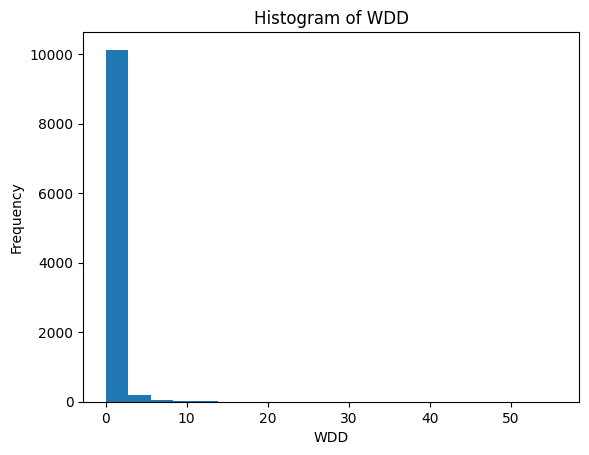

In [ ]:
# HISTOGRAM OF WDD
df['WDD'].plot.hist(bins=20)
plt.xlabel('WDD')
plt.ylabel('Frequency')
plt.title('Histogram of WDD')
plt.show()

In [ ]:
# Drop the 0 value
gdf_nonzero = df.query('WDD != 0')

In [ ]:
gdf_nonzero

IDcw  DurationTo       WDD  road_lengt  population  dist_to_pa  \
1        446    3.825444  0.425049   78.344184        3426   10.082589   
9        767    5.279165  0.586574  182.352563       15588   10.241795   
10       768    6.825444  0.758383  452.917294       28508    5.297898   
11       769    2.705460  0.300607  498.561176       45910    1.114033   
15       773    2.705460  0.300607  407.883213       27948   11.154419   
...      ...         ...       ...         ...         ...         ...   
10233  23342    3.130486  0.347832  168.427346           8  102.277542   
10309  23814    1.000000  0.111111    2.262302           2  109.682796   
10338  23975    2.000000  0.222222  227.978248          12  124.608658   
10346  23983   15.000000  1.666667   40.572408           3  106.332062   
10373  24142   14.000000  1.555556   43.103556           0  123.323607   

       dist_to_di  dist2weath          UGRD          VGRD  ...    land31  \
1      399.470391   17.264444 -2.442083e+00 -6.717721e-01  ...  0.041667   
9      408.753648    5.004745 -2.347647e+00 -6.039455e-01  ...  0.012346   
10     406.482264    8.494600 -2.341214e+00 -6.512952e-01  ...  0.012346   
11     404.259961   13.010342 -8.500000e+22 -8.500000e+22  ...  0.000000   
15     395.877833   19.235033 -2.452969e+00 -7.273683e-01  ...  0.000000   
...           ...         ...           ...           ...  ...       ...   
10233  274.278514   44.991724 -2.712565e-02  1.850991e+00  ...  0.000000   
10309  166.863787   53.268064  9.635583e-01  2.790588e+00  ...  0.000000   
10338  146.578726   52.015731  9.555520e-01  2.643768e+00  ...  0.000000   
10346  186.533674   52.478990  4.645232e-01  2.184390e+00  ...  0.000000   
10373  156.394498   44.272927  9.964049e-01  2.737400e+00  ...  0.000000   

         land41    land52    land82    land90      D_mile      ele_avg  \
1      0.013889  0.250000  0.027778  0.416667    3.843910     3.176640   
9      0.037037  0.049383  0.617284  0.012346   43.791072    23.863541   
10     0.024691  0.185185  0.456790  0.000000   41.170449    20.893511   
11     0.000000  0.135802  0.444444  0.000000   29.826579    16.063985   
15     0.012346  0.172840  0.395062  0.024691   54.902749     9.865663   
...         ...       ...       ...       ...         ...          ...   
10233  0.000000  0.950617  0.012346  0.000000  128.026650   879.826026   
10309  0.000000  1.000000  0.000000  0.000000   60.674704  1169.972076   
10338  0.000000  0.728395  0.271605  0.000000  110.469767  1269.313105   
10346  0.000000  0.851852  0.135802  0.000000   89.782873  1083.647525   
10373  0.000000  0.827160  0.148148  0.000000  103.334320  1352.254405   

         D_mil_sea  dist_to_fi  \
1        51.352092    2.251386   
9       199.959239   11.137301   
10      184.160618   11.853285   
11      168.362451    8.623751   
15      105.174380    0.778694   
...            ...         ...   
10233  1888.924501   15.344088   
10309  2155.342841   16.349330   
10338  2206.333561    3.346150   
10346  2132.642714   10.039968   
10373  2200.795895    9.025694   

                                                geometry  
1      POLYGON ((3249424.821 8500723.916, 3249424.821...  
9      POLYGON ((3011824.821 8553523.916, 3011824.821...  
10     POLYGON ((3038224.821 8553523.916, 3038224.821...  
11     POLYGON ((3064624.821 8553523.916, 3064624.821...  
15     POLYGON ((3170224.821 8553523.916, 3170224.821...  
...                                                  ...  
10233  POLYGON ((2219824.821 12170323.916, 2219824.82...  
10309  POLYGON ((1612624.821 12249523.916, 1612624.82...  
10338  POLYGON ((1507024.821 12275923.916, 1507024.82...  
10346  POLYGON ((1718224.821 12275923.916, 1718224.82...  
10373  POLYGON ((1559824.821 12302323.916, 1559824.82...  

[2926 rows x 33 columns]

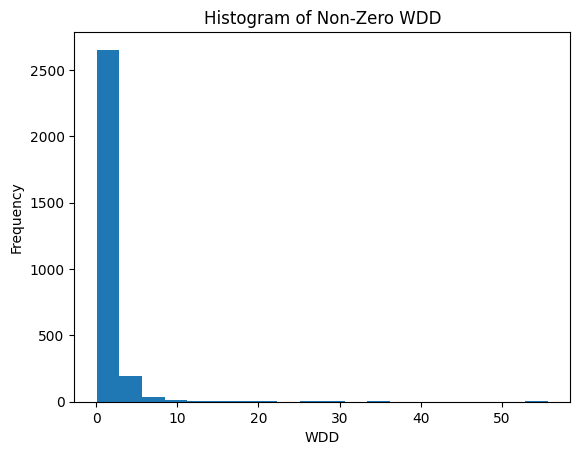

In [ ]:
#plot the valut without 0
gdf_nonzero['WDD'].plot.hist(bins=20)
plt.xlabel('WDD')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero WDD')
plt.show()

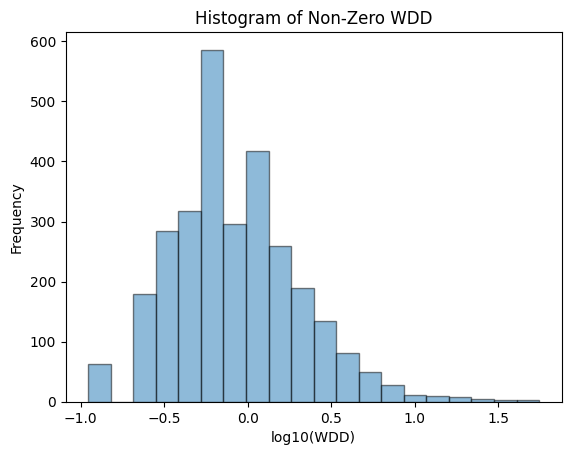

In [ ]:
# plot logged value without 0
x = np.log10(gdf_nonzero['WDD'])
plt.hist(x, bins=20, alpha=0.5, edgecolor='black')
plt.xlabel('log10(WDD)')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero WDD')
plt.show()

In [ ]:
!pip install --upgrade mapclassify

In [87]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [88]:
df = gpd.read_file("UrbanDS_Team-main/Data/Wildfire/Wildfire.shp")

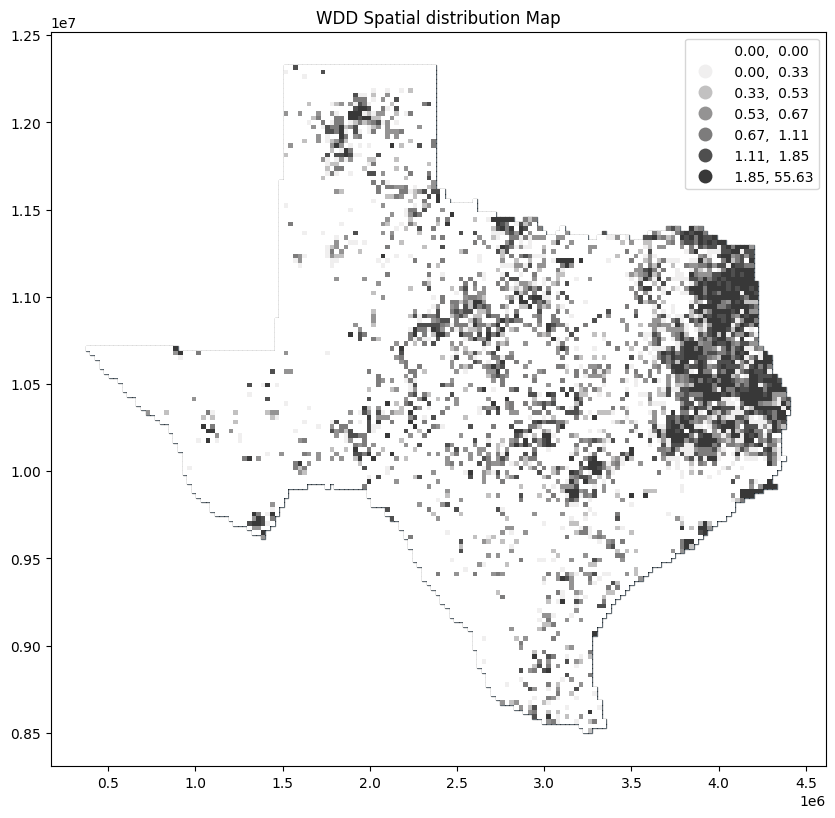

In [89]:
colors = ['#FFFFFF', '#F0EFEF', '#D9D8D8', '#C2C1C1', '#ABAAAA', '#949393', '#7D7C7C', '#666565', '#4F4F4F', '#383838']
cmap = ListedColormap(colors)

ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# HotSpots Map
df.plot(column='WDD', cmap=cmap, scheme='quantiles', k=20, legend=True, ax=ax)

# Add title
plt.title('WDD Spatial distribution Map')

plt.show()

In [ ]:
!pip install --upgrade esda libpysal contextily

In [ ]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from pylab import figure,scatter,show

In [ ]:
wq = lps.weights.Queen.from_dataframe(df)# Quuen adjacency matrix
wq.transform= 'r'

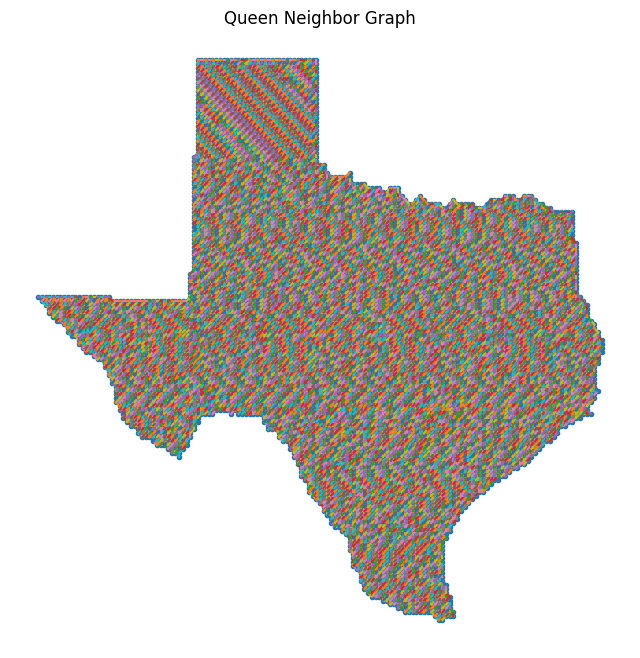

In [ ]:
# Spatial weight matrix visualization
centroids=df.geometry.centroid
fig=figure(figsize=(8,8))

plt.plot(centroids.x,centroids.y,'.')
for k,neighs in wq.neighbors.items():
  origin = centroids[k]
  for neigh in neighs:
    segment = centroids[[k,neigh]]
    plt.plot(segment.x,segment.y,'-')
plt.title('Queen Neighbor Graph')
plt.axis('off')
plt.show()

In [ ]:
!pip install splot

In [ ]:
from splot.esda import plot_moran

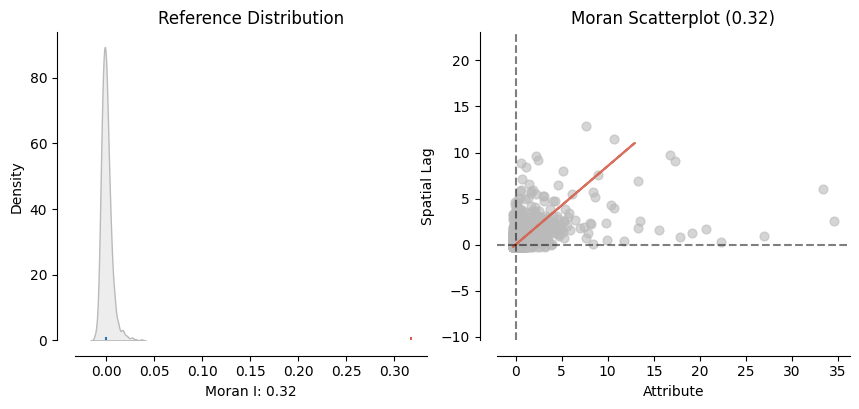

In [ ]:
#Moran's
mi = esda.moran.Moran(df['WDD'],wq)
plot_moran(mi,zstandard=True,figsize=(10,4))
plt.show()

In [ ]:
from esda.getisord import G_Local
g_local = G_Local(df['WDD'], wq, transform='B')

In [ ]:
df

IDcw  DurationTo       WDD  road_lengt  population  dist_to_pa  \
0        445    0.000000  0.000000  383.767234       41386    5.082596   
1        446    3.825444  0.425049   78.344184        3426   10.082589   
2        609    0.000000  0.000000  252.491244        5893    5.012677   
3        610    0.000000  0.000000  143.711420       12423    7.138119   
4        611    0.000000  0.000000   63.854813         855   11.259599   
...      ...         ...       ...         ...         ...         ...   
10399  24168    0.000000  0.000000  182.078767          22  125.662558   
10400  24169    0.000000  0.000000  155.762376         359  128.407465   
10401  24170    0.000000  0.000000  168.743059         103  131.285475   
10402  24171    0.000000  0.000000  179.709340          36  134.288028   
10403  24172    0.000000  0.000000  197.136519         570  149.202342   

       dist_to_di  dist2weath      UGRD      VGRD  ...    land90      D_mile  \
0      401.283326   18.765747 -2.321807 -0.589264  ...  0.172840   12.641330   
1      399.470391   17.264444 -2.442083 -0.671772  ...  0.416667    3.843910   
2      398.527017   17.637173 -2.459983 -0.629253  ...  0.069444   32.814775   
3      396.638461   14.386718 -2.500782 -0.643556  ...  0.236111   19.935072   
4      394.804197   12.364684 -2.554113 -0.697899  ...  0.640625   15.885948   
...           ...         ...       ...       ...  ...       ...         ...   
10399  264.974830   60.387765 -0.136694  1.602235  ...  0.000000  131.861025   
10400  269.309347   57.961169 -0.168983  1.574732  ...  0.000000  147.977076   
10401  273.666564   55.877653 -0.111381  1.635620  ...  0.012346  164.135844   
10402  278.045414   54.176813 -0.083262  1.665119  ...  0.000000  180.325846   
10403  282.444890   52.895577 -0.062073  1.700829  ...  0.000000  196.539366   

          ele_avg    D_mil_sea  dist_to_fi  \
0        5.552664    67.423558    5.008849   
1        3.176640    51.352092    2.251386   
2        9.090873    87.216811    6.564764   
3        6.611544    71.846873    8.487915   
4        3.060422    56.605122    7.212827   
...           ...          ...         ...   
10399  900.086792  1943.027618   19.582381   
10400  762.910171  1933.187620   24.503224   
10401  809.229718  1923.436903   25.666092   
10402  833.235303  1913.776831   21.452977   
10403  809.836637  1904.208782   17.655373   

                                                geometry  hotspot   spot  \
0      POLYGON ((3223024.821 8500723.916, 3223024.821...    False  False   
1      POLYGON ((3249424.821 8500723.916, 3249424.821...     True  False   
2      POLYGON ((3196624.821 8527123.916, 3196624.821...    False  False   
3      POLYGON ((3223024.821 8527123.916, 3223024.821...    False  False   
4      POLYGON ((3249424.821 8527123.916, 3249424.821...    False  False   
...                                                  ...      ...    ...   
10399  POLYGON ((2246224.821 12302323.916, 2246224.82...     True  False   
10400  POLYGON ((2272624.821 12302323.916, 2272624.82...     True  False   
10401  POLYGON ((2299024.821 12302323.916, 2299024.82...     True  False   
10402  POLYGON ((2325424.821 12302323.916, 2325424.82...     True  False   
10403  POLYGON ((2351824.821 12302323.916, 2351824.82...     True  False   

         spot_p    spot_z  
0      0.179324 -0.362074  
1      0.155196 -0.494742  
2      0.159720 -0.469265  
3      0.162464 -0.453963  
4      0.210210 -0.200819  
...         ...       ...  
10399  0.145028 -0.553223  
10400  0.145028 -0.553223  
10401  0.145028 -0.553223  
10402  0.145028 -0.553223  
10403  0.167075 -0.428484  

[10404 rows x 37 columns]

In [ ]:
df['spot_p'] = g_local.p_norm/2
df['spot_z'] = g_local.Zs
hotspots = df[(df['spot_p'] < 0.05) & (df['spot_z'] > 0)]
coldspots = df[(df['spot_p'] < 0.05) & (df['spot_z'] <0)]

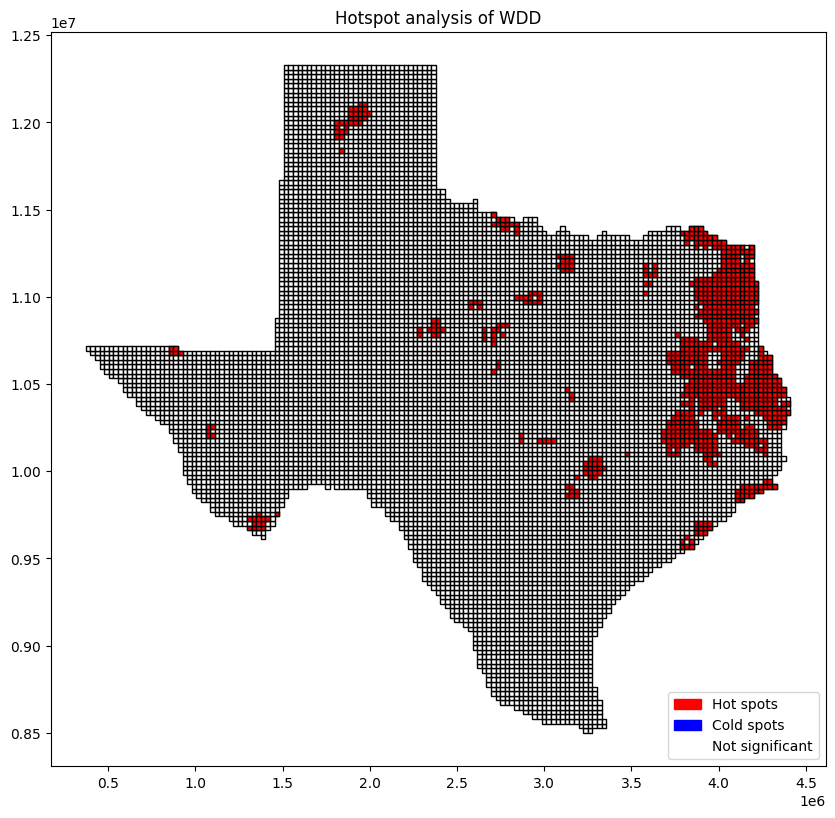

In [ ]:
# Analyze hotspot and coldspot
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, facecolor='white', edgecolor='black')
hotspots.plot(ax=ax, facecolor='red', edgecolor='black')
coldspots.plot(ax=ax, facecolor='blue', edgecolor='black')
hotspot_patch = mpatches.Patch(color='red', label='Hot spots')
coldspot_patch = mpatches.Patch(color='blue', label='Cold spots')
nosign_patch = mpatches.Patch(color='white', label='Not significant')
ax.legend(handles=[hotspot_patch, coldspot_patch,nosign_patch], loc='lower right')
plt.title('Hotspot analysis of WDD')
plt.show()

In [ ]:
# After running this part, need this command to refresh data (useless)
#df = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/Wildfire.shp") 
#df = gpd.read_file("UrbanDS_Team-main/Data/Wildfire/Wildfire.shp")

## 3.2 Input Feature
- Correlation Matrix for all Variables
- Multicolinearity issue
- Dimension Reduction (PCA)
- Unit Transformation

### 3.2.1 Correlation Matrix for Raw Data

**Before running this part, run part 3 (before part 3.1)**

CPU times: user 701 ms, sys: 71.8 ms, total: 773 ms
Wall time: 874 ms


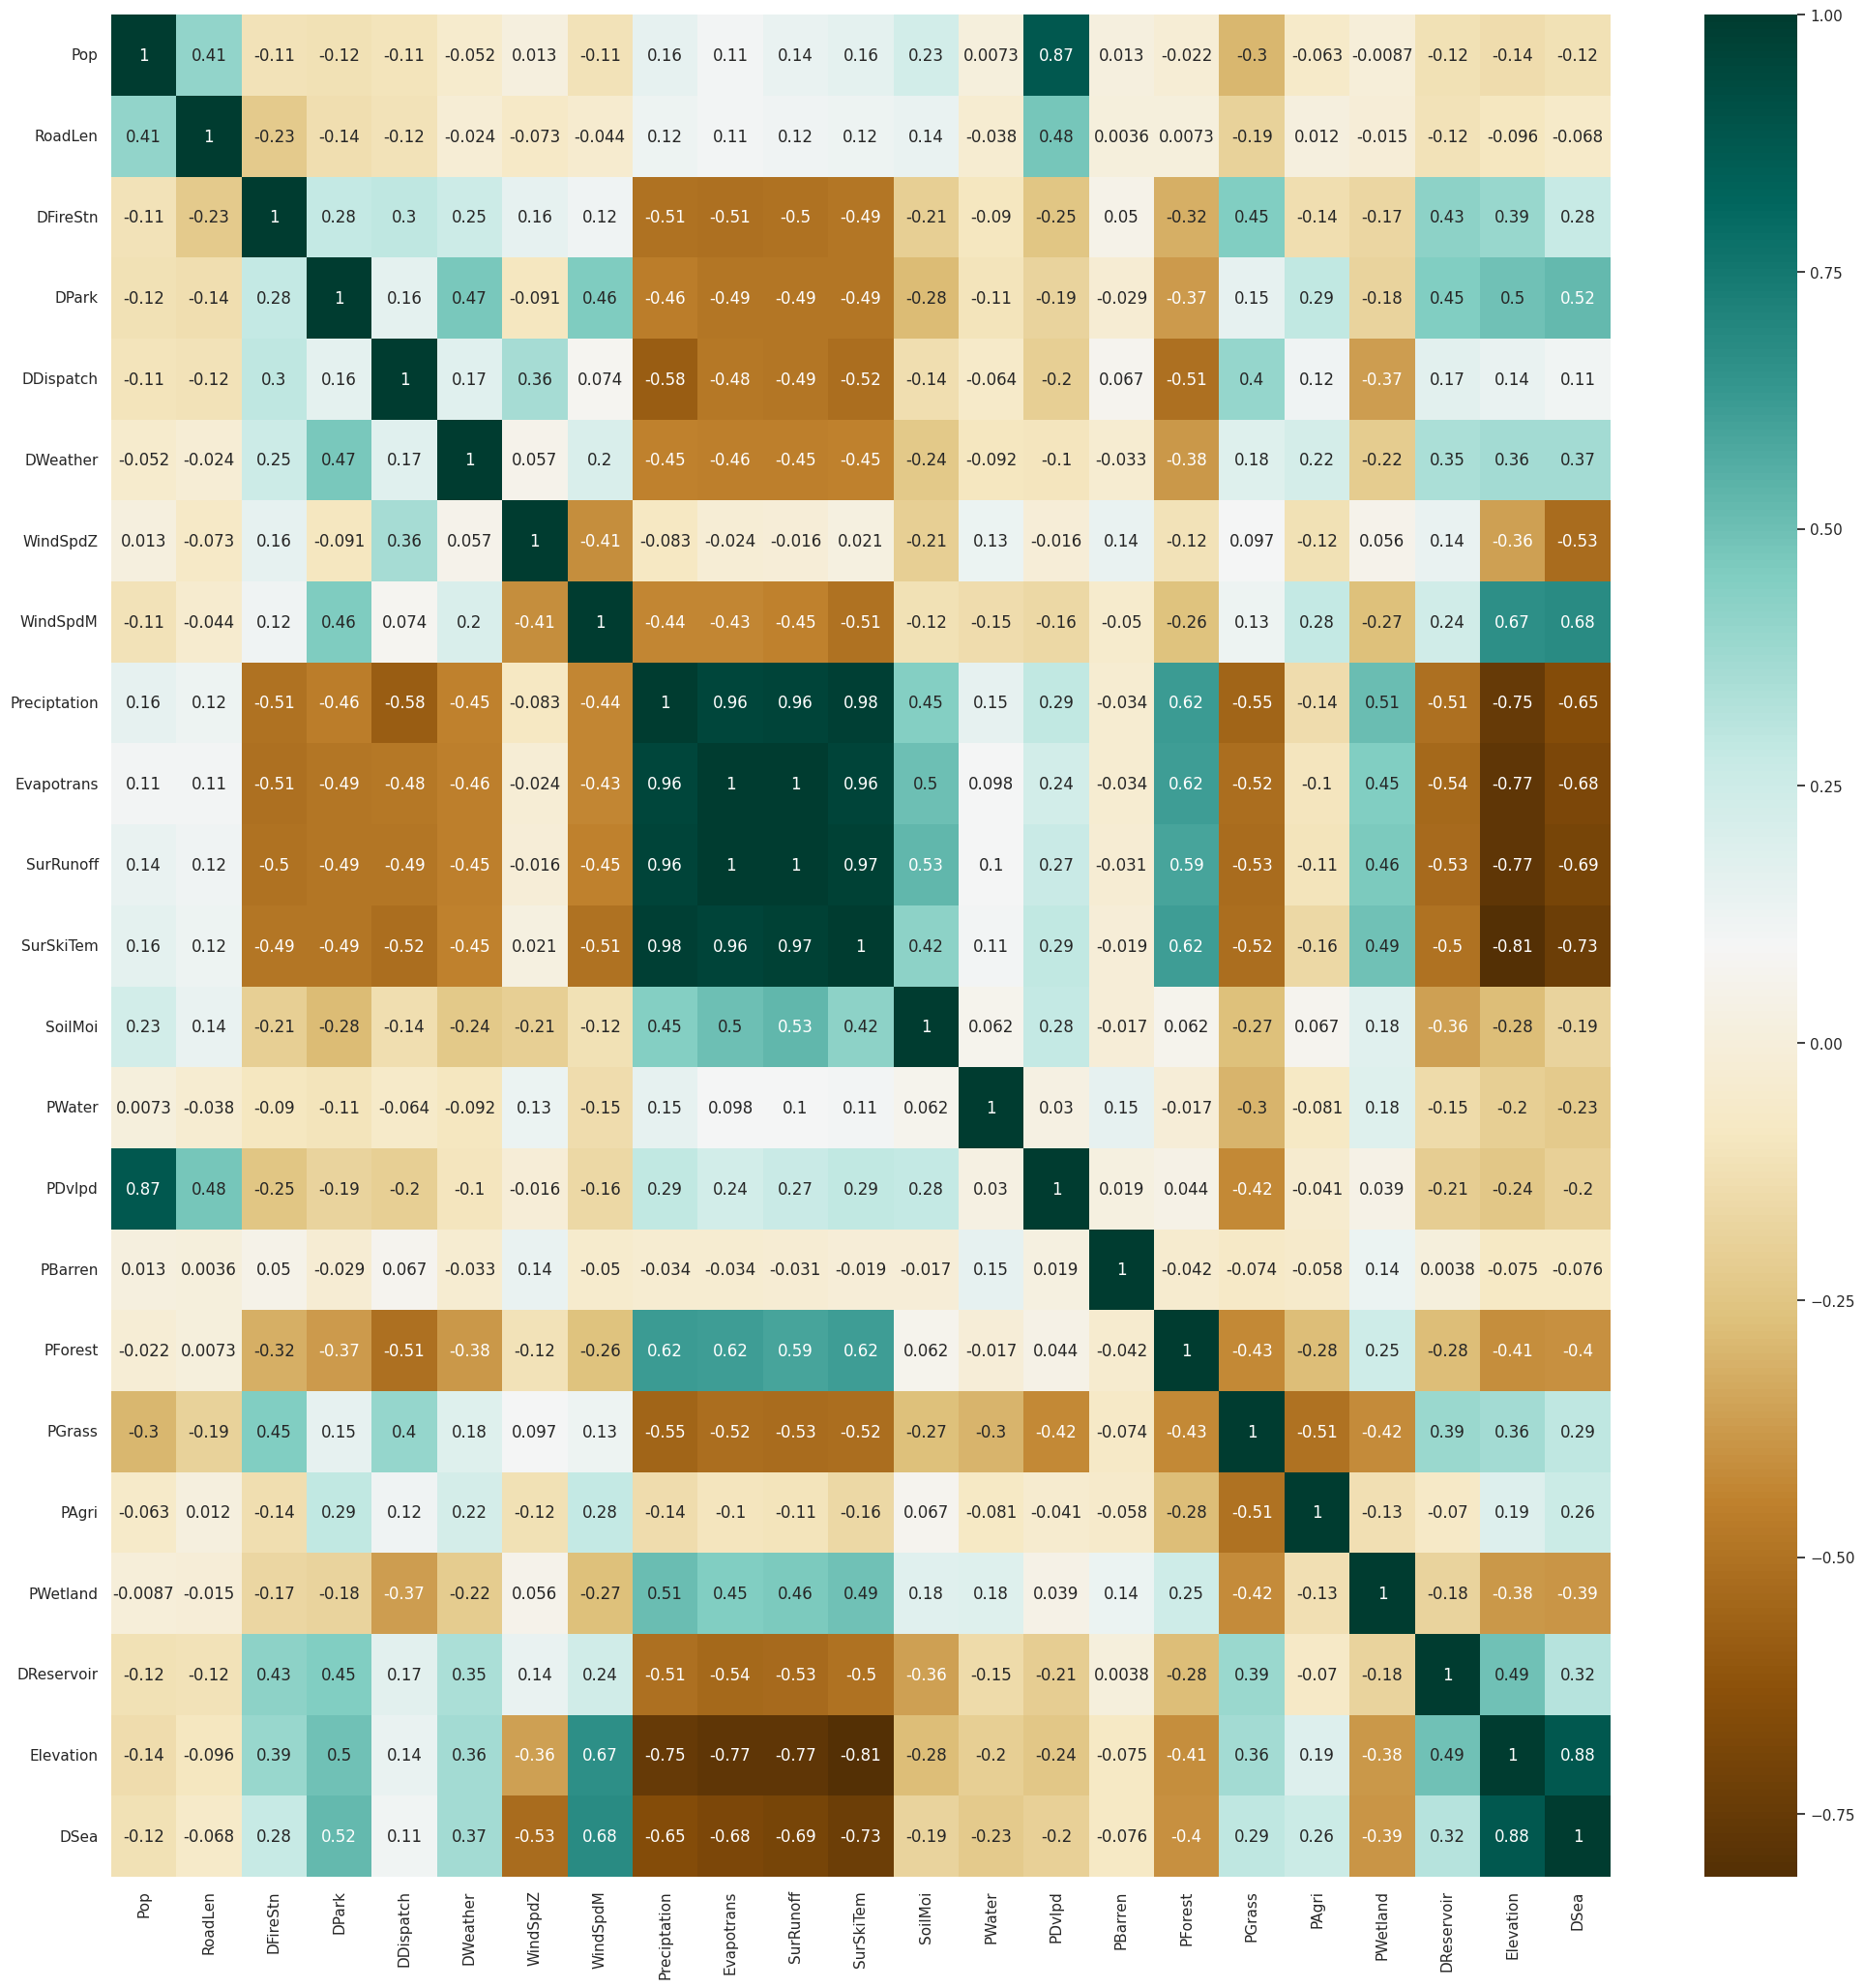

In [ ]:
%%time
## Correlation of Built Environment, Natural Environment, Population, and nWRI
## nWRI, 
## Pop, 
## Built environment: RoadLen, DFireStn, DPark, DDispatch, DWeather,DReservoir, DSea
## Natrual environment: WindSpdZ, WindSpdM, Preciptation, Evapotrans, SurRunoff, 
fig, ax = plt.subplots(figsize=(25,25))  
# cor = sns.heatmap(df[["nWRI","Pop","RoadLen","DFireStn","DPark","DDispatch","DWeather","DReservoir","DSea","WindSpdZ","WindSpdM",'Preciptation', 'Evapotrans', 'SurRunoff', 'SurSkiTem','SoilMoi', 'PWater', 'PDvlpd', 'PBarren', 'PForest', 'PGrass',
#        'PAgri', 'PWetland']].corr(),annot=True, cmap='BrBG')
cor = sns.heatmap(dfX.corr(),annot=True, cmap='BrBG')

### 3.2.2 Calculate PEI using Principle Component Analysis

In [ ]:
## 'Preciptation','Evapotrans',"SurRunoff","SurSkiTem" are highly correlated
df[['Preciptation','Evapotrans',"SurRunoff","SurSkiTem"]].head(20)

Preciptation  Evapotrans  SurRunoff  SurSkiTem
0          42.14       37.51      42.02      67.99
1          50.31       43.51      49.70      75.74
2          40.87       37.08      40.91      67.00
3          46.85       41.40      46.43      72.51
4          53.92       45.97      52.70      79.04
5          55.02       46.23      53.47      80.06
6          52.98       46.63      52.88      77.13
7          60.08       46.63      52.88      77.13
8          39.35       35.98      40.47      66.47
9          40.48       37.07      41.60      67.69
10         41.12       37.67      42.10      68.57
11         60.08       46.63      52.88      77.13
12         40.32       36.86      41.10      67.90
13         40.01       36.54      40.74      67.58
14         41.48       37.84      42.37      68.62
15         44.73       40.27      45.36      71.08
16         46.51       41.40      46.71      72.50
17         50.01       42.45      47.87      75.66
18         53.51       44.30      50.35      78.68
19         53.51       45.09      51.68      78.53

In [ ]:
# Principle Factor Analysis for 'Preciptation','Evapotrans',"SurRunoff","SurSkiTem"
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_results = pca.fit_transform(df[['Preciptation','Evapotrans',"SurRunoff","SurSkiTem",]])
df_pca = pd.DataFrame(data = pca_results, columns = ['PC1', 'PC2',"PC3","PC4"])
df_pca.head()

PC1   PC2   PC3   PC4
0 -23.75 -1.25 -6.40 -0.24
1  -8.91 -2.22 -5.74  0.16
2 -25.70 -1.37 -6.58 -0.62
3 -15.01 -2.03 -6.00 -0.34
4  -2.67 -2.35 -5.41  0.20

In [ ]:
## Use the first PC as measurement for 'Preciptation','Evapotrans',"SurRunoff","SurSkiTem" and name it Preciptation-Evaporation Index (PEI)
## Test the Preciptation or PEI
dfX = dfX.drop(columns=['Preciptation','Evapotrans',"SurRunoff"])
df_pca = df_pca.rename(columns={"PC1":"PEI"})
dfX = dfX.merge(df_pca[["PEI"]],left_index=True,right_index=True)
dfX.head()

Pop  RoadLen  DFireStn  DPark  DDispatch  DWeather  WindSpdZ  WindSpdM  \
0  41386   383.77      5.01   5.08     401.28     18.77      2.32      0.59   
1   3426    78.34      2.25  10.08     399.47     17.26      2.44      0.67   
2   5893   252.49      6.56   5.01     398.53     17.64      2.46      0.63   
3  12423   143.71      8.49   7.14     396.64     14.39      2.50      0.64   
4    855    63.85      7.21  11.26     394.80     12.36      2.55      0.70   

   SurSkiTem  SoilMoi  ...  PDvlpd  PBarren  PForest  PGrass  PAgri  PWetland  \
0      67.99   561.09  ...   44.44     0.00     1.23   17.28  19.75     17.28   
1      75.74   624.20  ...   18.06     4.17     1.39   25.00   2.78     41.67   
2      67.00   534.39  ...   13.89     1.39     2.78    9.72  59.72      6.94   
3      72.51   587.18  ...   11.11     2.78     2.78   31.94  23.61     23.61   
4      79.04   650.61  ...    3.12     4.69     0.00   23.44   4.69     64.06   

   DReservoir  Elevation  DSea    PEI  
0       12.64       5.55 67.42 -23.75  
1        3.84       3.18 51.35  -8.91  
2       32.81       9.09 87.22 -25.70  
3       19.94       6.61 71.85 -15.01  
4       15.89       3.06 56.61  -2.67  

[5 rows x 21 columns]

In [ ]:
df = df.merge(df_pca[["PEI"]],left_index=True,right_index=True)

In [ ]:
## Calculate Variance Inflation Factor(VIF) for Multicolinearty
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = {}
for c in dfX.columns:
  vif = variance_inflation_factor(dfX.values,dfX.columns.get_loc(c))
  vifs[c] = vif
for key in vifs.keys():
  print(key,vifs[key])

Pop 4.780565845885536
RoadLen 1.7710149860281281
DFireStn 4.707798803316749
DPark 6.003008180055849
DDispatch 18.349349302334343
DWeather 6.499534168368278
WindSpdZ 6.766262203626338
WindSpdM 10.416114980793347
SurSkiTem 1650.273547194655
SoilMoi 60.47822920849595
PWater 15.447953381564707
PDvlpd 43.83233446851316
PBarren 1.618721534101325
PForest 71.38100319665195
PGrass 1020.2432794264603
PAgri 128.86457351042606
PWetland 21.42493420399328
DReservoir 5.23814330645062
Elevation 20.833549050212277
DSea 31.02684873019523
PEI 151.7643652747346


### 3.2.3 Correlation Matrix for Variable including PEI

CPU times: user 488 ms, sys: 111 ms, total: 599 ms
Wall time: 498 ms


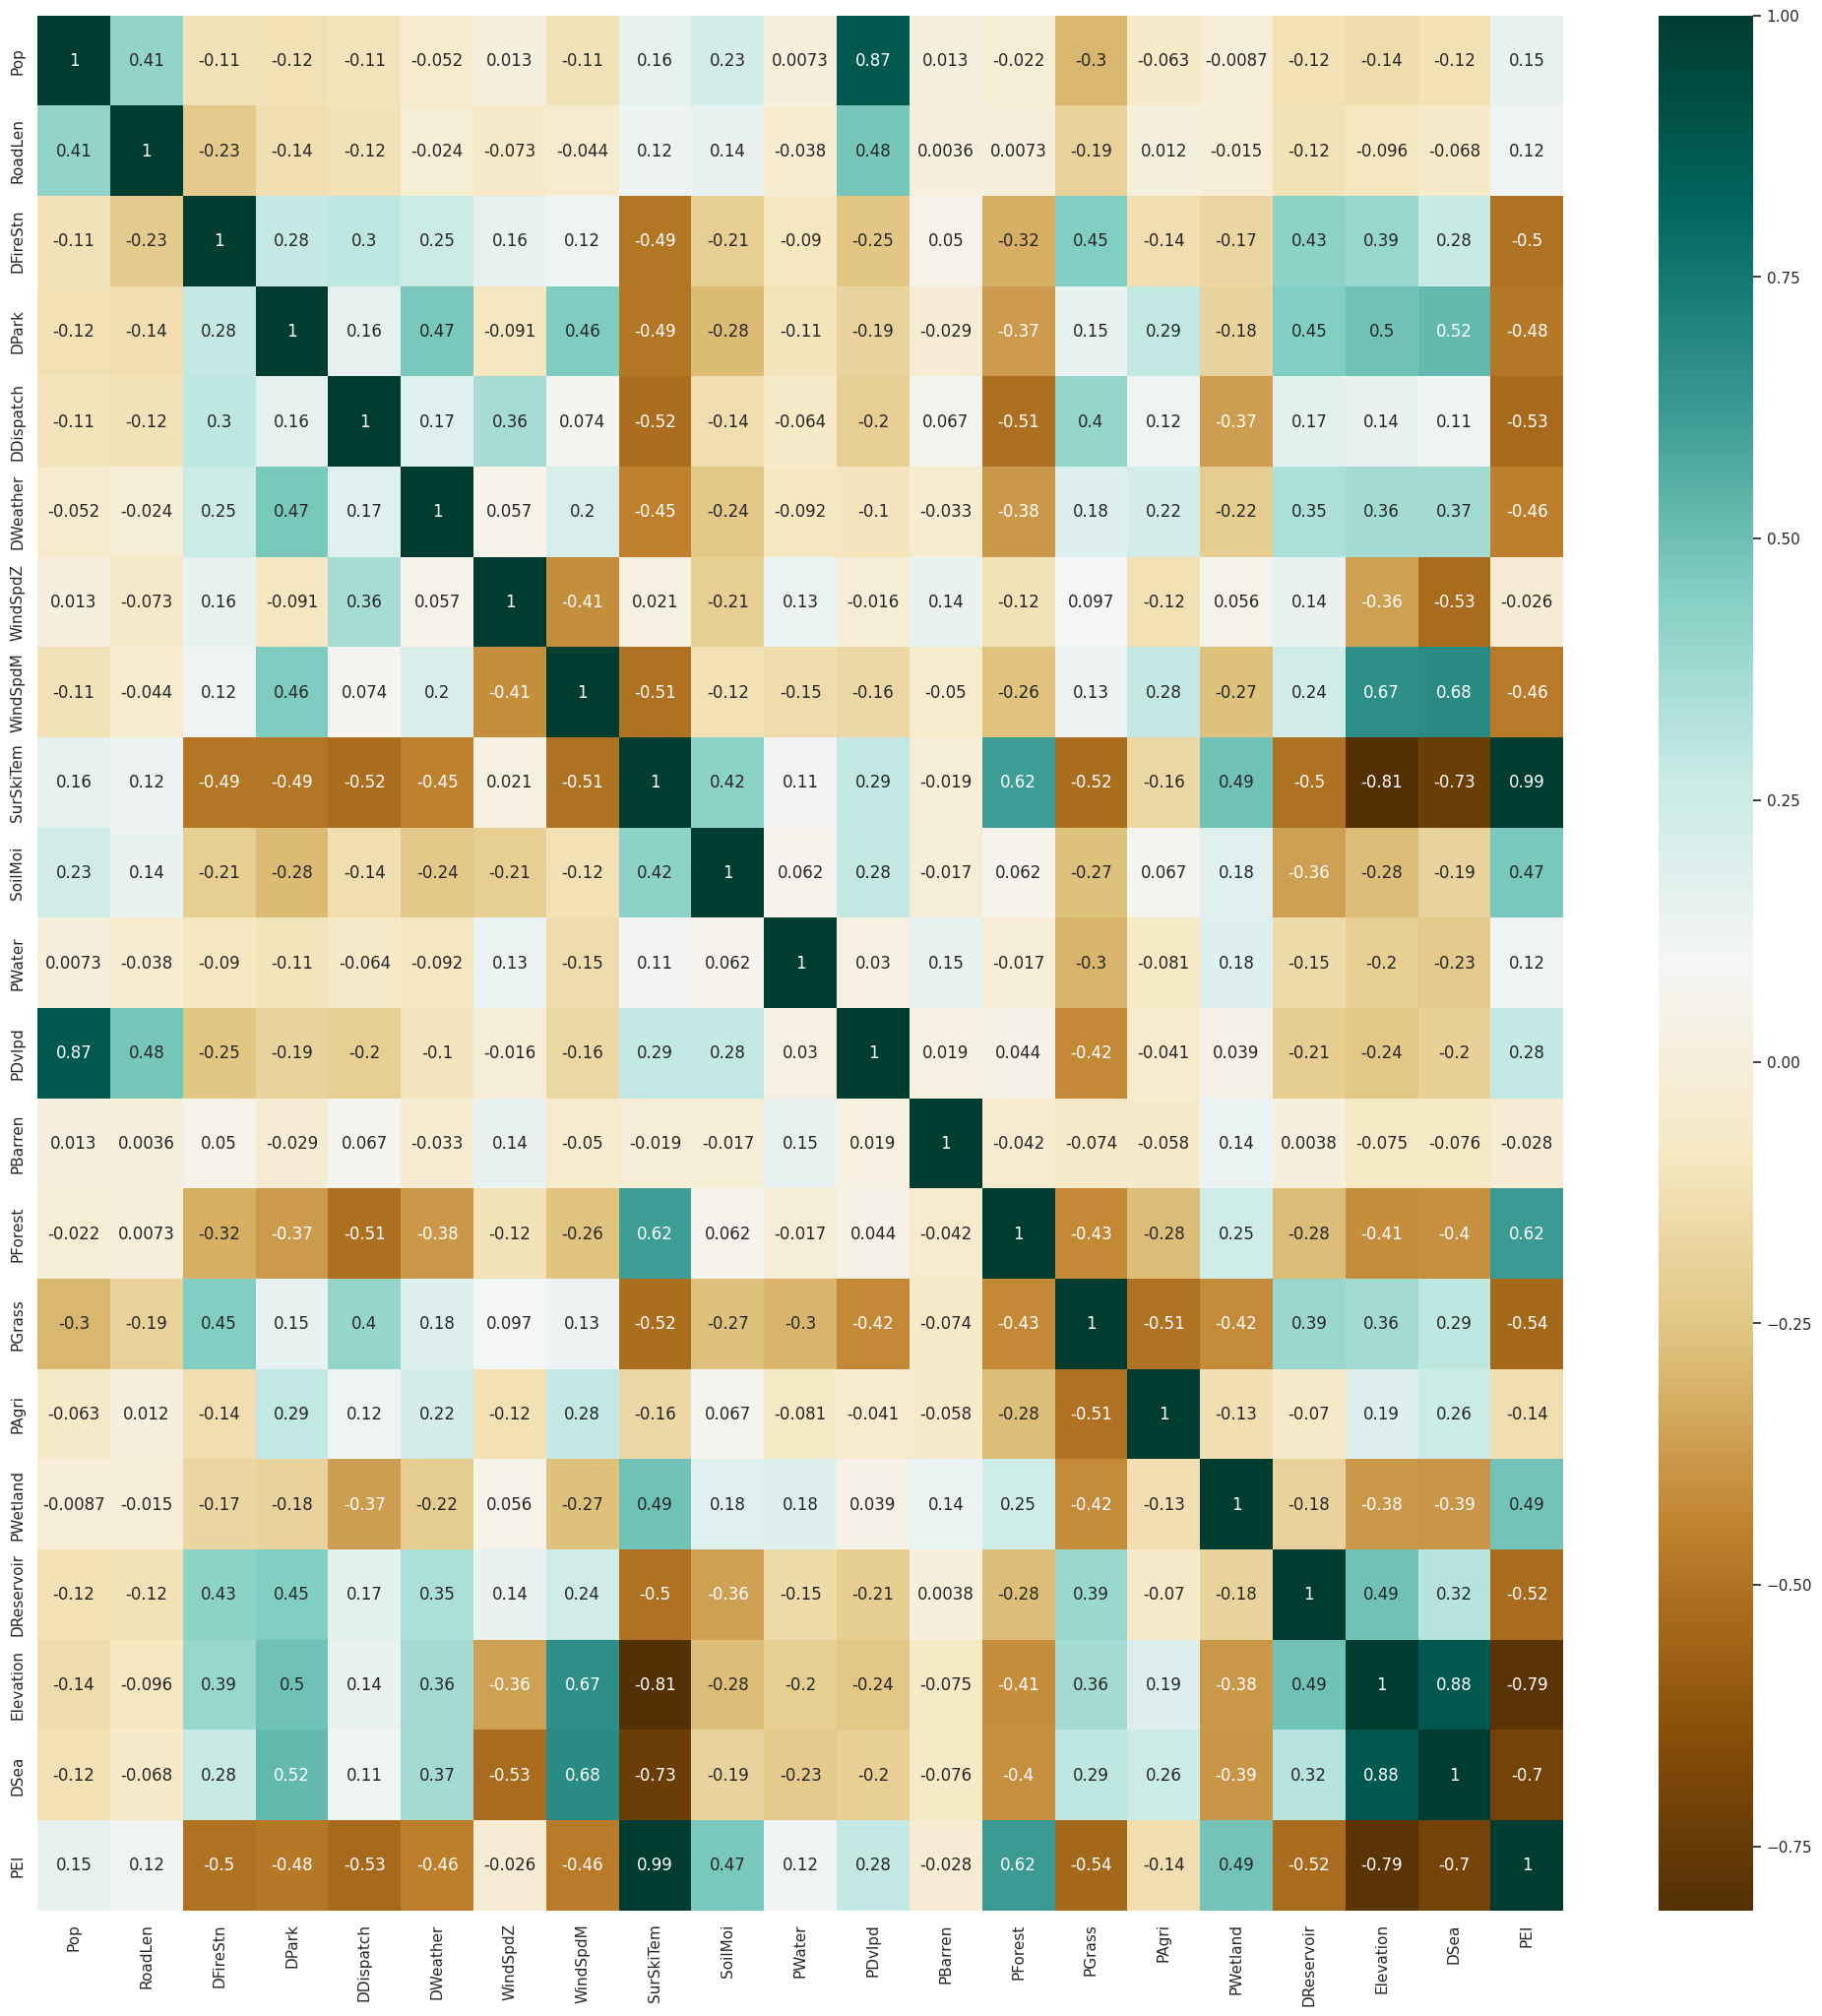

In [ ]:
%%time
# Replot the correlation matrix
fig, ax = plt.subplots(figsize=(25,25))  
cor = sns.heatmap(dfX.corr(),annot=True, cmap='BrBG')

### 3.2.4 Paired Density Graph for Built Environment and Natural Environment

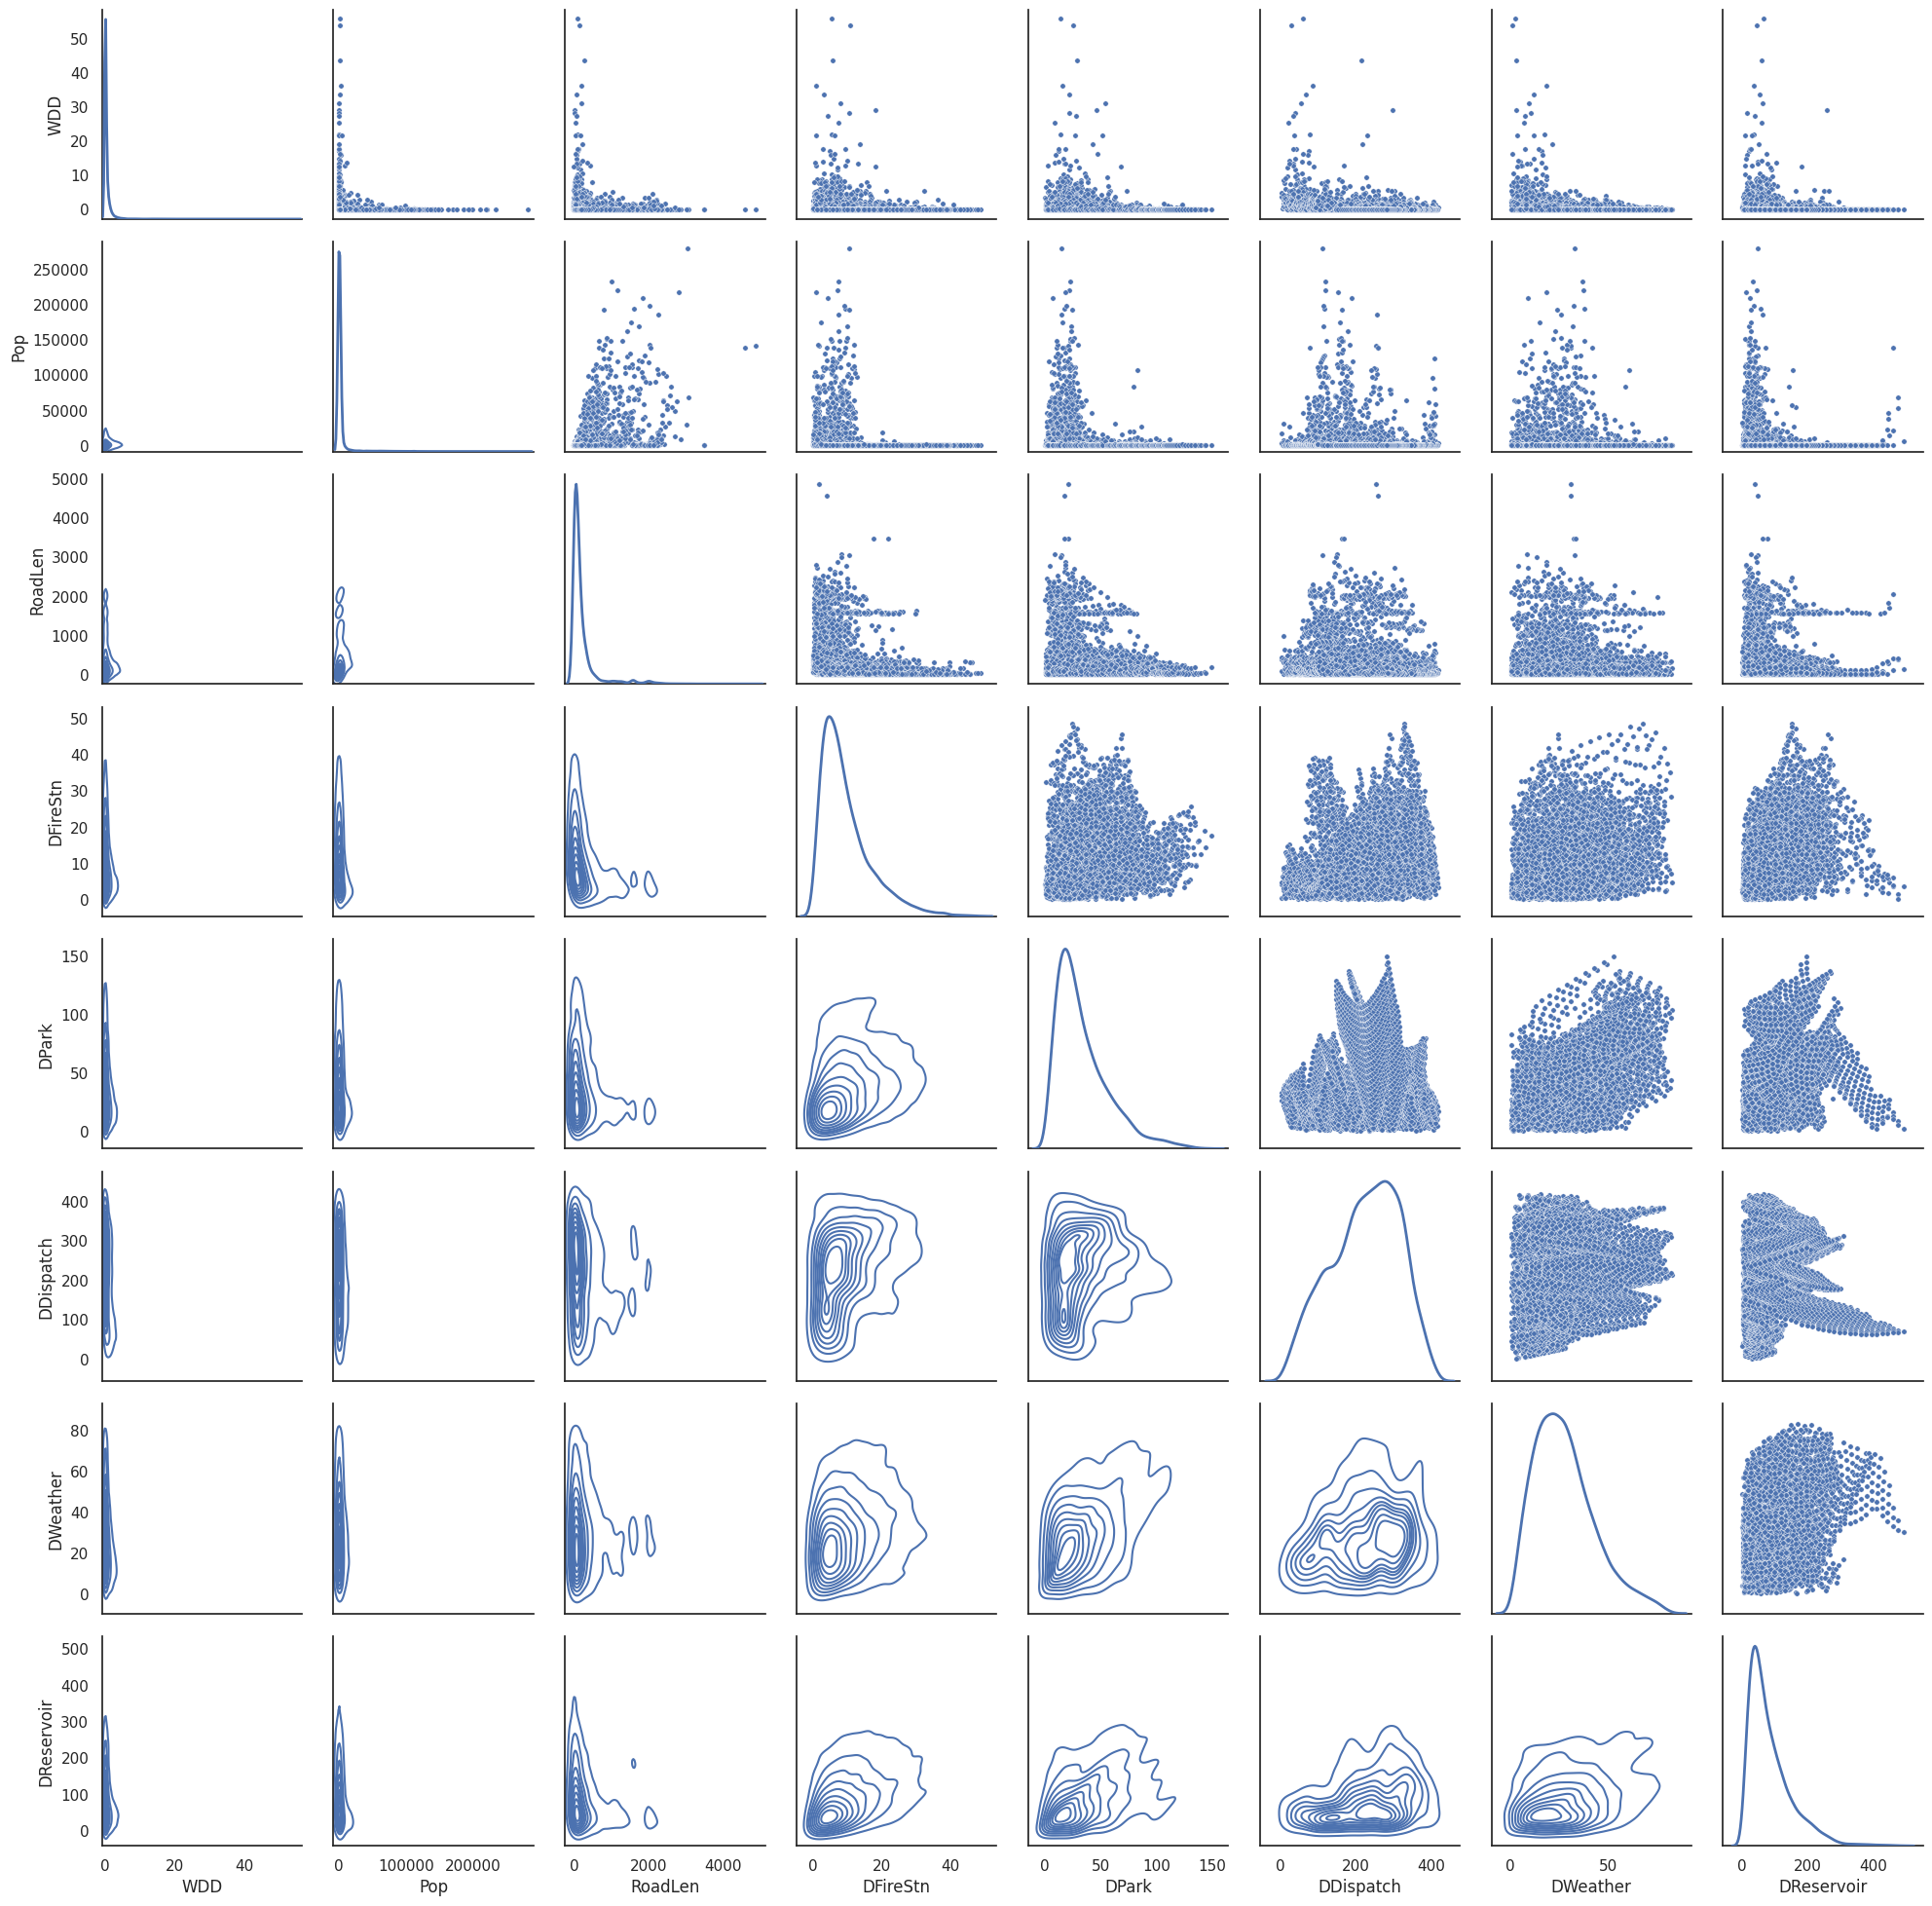

In [ ]:
## Paired Density Graph for Built Environment and Natural Environment
## Built Environment and Population
gBE = sns.PairGrid(df[["WDD","Pop","RoadLen","DFireStn","DPark","DDispatch","DWeather","DReservoir"]],diag_sharey=False)
# gBE = sns.PairGrid(df[["WDD","Pop","RoadLen","DPark","DDispatch","DWeather","DReservoir"]],diag_sharey=False)
gBE .map_upper(sns.scatterplot, s=15)
gBE .map_lower(sns.kdeplot)
gBE .map_diag(sns.kdeplot, lw=2)

In [ ]:
## Natural Environment
gNE = sns.PairGrid(df[["WDD","WindSpdZ","WindSpdM","PEI","SoilMoi","PWater","PDvlpd","PBarren","PForest","PGrass","PAgri","PWetland","DSea"]],diag_sharey=False)
gNE .map_upper(sns.scatterplot, s=15)
gNE .map_lower(sns.kdeplot)
gNE .map_diag(sns.kdeplot, lw=2)


Output hidden; open in https://colab.research.google.com to view.

# 4 Random Forest and Geographically Weighted Random Forest

## 4.1 Global Random Forest
- Apply Random Forest on Dataset
- Variance Importance Table
- Partial Dependence Plot

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, linear_model, tree, discriminant_analysis, ensemble, neural_network, inspection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, cross_val_score
from sklearn.inspection import PartialDependenceDisplay
rand=1

###4.1.1 Test Model Using Unstandarized Dataset with PEI

In [ ]:
## Split dataset to trainin set and test set
def split_dataset(dfX, dfY):
  X_train, X_test, y_train, y_test = train_test_split(dfX,dfY, test_size=0.2, random_state=rand)
  return X_train, X_test, y_train, y_test 
dfX_PEI = dfX.drop(columns=['SurSkiTem'])
X_train, X_test,y_train,y_test = split_dataset(dfX_PEI, dfY)

In [ ]:
%%time
## using grid search approach to get the optimized hyperparameter for random forest, using squared_error as criterion
# use successive halving iterations
rng = np.random.RandomState(0)

clf = RandomForestRegressor(random_state=rng)
param_dist = {
    "n_estimators":randint(20,200),
    'max_depth':randint(10,20),
    'max_features':randint(1,20),
    'min_samples_split':randint(2,11),
    'bootstrap':[True,False],
    "criterion":['squared_error',"absolute_error"] 
}
rsh = HalvingRandomSearchCV(estimator=clf,param_distributions=param_dist,factor=2,random_state=rand)
rsh.fit(X_train,y_train)
print(rsh.best_estimator_)

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=14,
                      max_features=1, min_samples_split=10, n_estimators=98,
                      random_state=RandomState(MT19937) at 0x7F9C4C458B40)
CPU times: user 28min 43s, sys: 13.6 s, total: 28min 56s
Wall time: 29min 5s


In [ ]:
## model training and evaluation using optimal hyperparameter for raw X_train

def model_training(reg_models,X_train, X_test,y_train,y_test):
  for model_name in reg_models.keys():
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_train'] =\
       metrics.r2_score(y_train, y_train_pred)
    reg_models[model_name]['RMSE_test'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_test'] =\
        metrics.r2_score(y_test, y_test_pred)

    reg_metrics = pd.DataFrame.from_dict(reg_models,'index')[['RMSE_train',"R2_train", 'RMSE_test', 'R2_test']]
    reg_metrics.sort_values(by='RMSE_test').style.background_gradient(cmap='viridis', low=1, high=0.3,subset=['RMSE_train', 'RMSE_test']).background_gradient(cmap='plasma', low=0.3, high=1,subset=['R2_test'])
    
    print(reg_metrics)

rng = np.random.RandomState(0)

models_RF = {
    "random_forest":{
        "model":ensemble.RandomForestRegressor( max_depth=14,
                                                n_estimators=98,
                                                max_features=1,
                                                min_samples_split=10,
                                                random_state=rand)
    }
}

model_training(models_RF,X_train, X_test,y_train,y_test)

               RMSE_train  R2_train  RMSE_test  R2_test
random_forest        0.97      0.58       0.97     0.20


### 4.1.2 Test Model Using Standardized Dataset with PEI

In [ ]:
# standarize X and Split
def split_dataset(dfX, dfY):
  X_train, X_test, y_train, y_test = train_test_split(dfX,dfY, test_size=0.2, random_state=rand)
  return X_train, X_test, y_train, y_test 
dfXt = dfX.drop(columns=['SurSkiTem'])
scaler = preprocessing.StandardScaler().fit(dfXt)
dfXt_PEI = scaler.transform(dfXt)
X_train, X_test,y_train,y_test = split_dataset(dfXt_PEI, dfY)

In [ ]:
%%time
## test for standardized X_train
rng = np.random.RandomState(0)

clf = RandomForestRegressor(random_state=rng)
param_dist = {
    "n_estimators":randint(20,200),
    'max_depth':randint(10,20),
    'max_features':randint(1,20),
    'min_samples_split':randint(2,11),
    'bootstrap':[True,False],
    "criterion":['squared_error',"absolute_error"] 
}
rsh = HalvingRandomSearchCV(estimator=clf,param_distributions=param_dist,factor=2,random_state=rand)
rsh.fit(X_train,y_train)
print(rsh.best_estimator_)

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=14,
                      max_features=1, min_samples_split=10, n_estimators=98,
                      random_state=RandomState(MT19937) at 0x7F9C4BFF6C40)
CPU times: user 27min 19s, sys: 13.4 s, total: 27min 33s
Wall time: 27min 40s


In [ ]:
## model training and evaluation using optimal hyperparameter for standardized X_train

def model_training(reg_models,X_train, X_test,y_train,y_test):
  for model_name in reg_models.keys():
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_train'] =\
       metrics.r2_score(y_train, y_train_pred)
    reg_models[model_name]['RMSE_test'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_test'] =\
        metrics.r2_score(y_test, y_test_pred)

    reg_metrics = pd.DataFrame.from_dict(reg_models,'index')[['RMSE_train',"R2_train", 'RMSE_test', 'R2_test']]
    reg_metrics.sort_values(by='RMSE_test').style.background_gradient(cmap='viridis', low=1, high=0.3,subset=['RMSE_train', 'RMSE_test']).background_gradient(cmap='plasma', low=0.3, high=1,subset=['R2_test'])
    
    print(reg_metrics)

rng = np.random.RandomState(0)

models_RF = {
    "random_forest":{
        "model":ensemble.RandomForestRegressor( max_depth=14,
                                                n_estimators=98,
                                                max_features=1,
                                                min_samples_split=10,
                                                random_state=rand)
    }
}

model_training(models_RF,X_train, X_test,y_train,y_test)

               RMSE_train  R2_train  RMSE_test  R2_test
random_forest        0.97      0.58       0.97     0.20


### 4.1.3 Test Model Using Unstandardized Dataset with Surface Skin Temperature

In [ ]:
## Split dataset to trainin set and test set
def split_dataset(dfX, dfY):
  X_train, X_test, y_train, y_test = train_test_split(dfX,dfY, test_size=0.2, random_state=rand)
  return X_train, X_test, y_train, y_test 
dfX_Tem = dfX.drop(columns=['PEI'])
X_train, X_test,y_train,y_test = split_dataset(dfX_Tem, dfY)

In [ ]:
%%time
## using grid search approach to get the optimized hyperparameter for random forest, using squared_error, absolute_error as criterion
# use successive halving iterations
rng = np.random.RandomState(0)

clf = RandomForestRegressor(random_state=rng)
param_dist = {
    "n_estimators":randint(20,200),
    'max_depth':randint(10,20),
    'max_features':randint(1,20),
    'min_samples_split':randint(2,11),
    'bootstrap':[True,False],
    "criterion":['squared_error',"absolute_error"] 
}
rsh = HalvingRandomSearchCV(estimator=clf,param_distributions=param_dist,factor=2,random_state=rand)
rsh.fit(X_train,y_train)
print(rsh.best_estimator_)

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=11,
                      max_features=1, min_samples_split=4, n_estimators=178,
                      random_state=RandomState(MT19937) at 0x7F9C4BFF6940)
CPU times: user 30min 30s, sys: 14 s, total: 30min 44s
Wall time: 30min 54s


In [ ]:
## model training and evaluation using optimal Unstandardized Dataset with Preciptation

def model_training(reg_models,X_train, X_test,y_train,y_test):
  for model_name in reg_models.keys():
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_train'] =\
       metrics.r2_score(y_train, y_train_pred)
    reg_models[model_name]['RMSE_test'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_test'] =\
        metrics.r2_score(y_test, y_test_pred)

    reg_metrics = pd.DataFrame.from_dict(reg_models,'index')[['RMSE_train',"R2_train", 'RMSE_test', 'R2_test']]
    reg_metrics.sort_values(by='RMSE_test').style.background_gradient(cmap='viridis', low=1, high=0.3,subset=['RMSE_train', 'RMSE_test']).background_gradient(cmap='plasma', low=0.3, high=1,subset=['R2_test'])
    
    print(reg_metrics)

rng = np.random.RandomState(0)

models_RF = {
    "random_forest":{
        "model":ensemble.RandomForestRegressor( max_depth=11,
                                                n_estimators=178,
                                                max_features=1,
                                                min_samples_split=4,
                                                random_state=rand)
    }
}

model_training(models_RF,X_train, X_test,y_train,y_test)

               RMSE_train  R2_train  RMSE_test  R2_test
random_forest        0.89      0.65       0.89     0.19


### 4.1.4 Test Model Using Standardized Dataset with Surface Skin Temperature

In [ ]:
def split_dataset(dfX, dfY):
  X_train, X_test, y_train, y_test = train_test_split(dfX,dfY, test_size=0.2, random_state=rand)
  return X_train, X_test, y_train, y_test 


dfXt = dfX.drop(columns=['PEI'])
scaler = preprocessing.StandardScaler().fit(dfXt)
dfXt_Tem = scaler.transform(dfXt)
X_train, X_test,y_train,y_test = split_dataset(dfXt_Tem, dfY)


In [ ]:
%%time
rng = np.random.RandomState(0)

clf = RandomForestRegressor(random_state=rng)
param_dist = {
    "n_estimators":randint(20,200),
    'max_depth':randint(10,20),
    'max_features':randint(1,20),
    'min_samples_split':randint(2,11),
    'bootstrap':[True,False],
    "criterion":['squared_error',"absolute_error"] 
}
rsh = HalvingRandomSearchCV(estimator=clf,param_distributions=param_dist,factor=2,random_state=rand)
rsh.fit(X_train,y_train)
print(rsh.best_estimator_)

RandomForestRegressor(criterion='absolute_error', max_depth=17, max_features=3,
                      min_samples_split=6, n_estimators=153,
                      random_state=RandomState(MT19937) at 0x7F4BBFEEB240)
CPU times: user 7min 21s, sys: 3.05 s, total: 7min 24s
Wall time: 7min 34s


In [ ]:
## model training and evaluation using optimal hyperparameter for raw X_train

def model_training(reg_models,X_train, X_test,y_train,y_test):
  for model_name in reg_models.keys():
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['RMSE_test'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_test'] =\
        metrics.r2_score(y_test, y_test_pred)

    reg_metrics = pd.DataFrame.from_dict(reg_models,'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
    reg_metrics.sort_values(by='RMSE_test').style.background_gradient(cmap='viridis', low=1, high=0.3,subset=['RMSE_train', 'RMSE_test']).background_gradient(cmap='plasma', low=0.3, high=1,subset=['R2_test'])
    
    print(reg_metrics)

rng = np.random.RandomState(0)

models_RF = {
    "random_forest":{
        "model":ensemble.RandomForestRegressor( max_depth=11,
                                                n_estimators=178,
                                                max_features=1,
                                                min_samples_split=4,
                                                random_state=rand)
    }
}

model_training(models_RF,X_train, X_test,y_train,y_test)

               RMSE_train  RMSE_test  R2_test
random_forest        0.89       0.89     0.19


### 4.1.5 Final Model- Using Unstandarized Dataset with PEI for Better Interpretability and Better R-Squared

In [ ]:
## Split dataset to trainin set and test set
def split_dataset(dfX, dfY):
  X_train, X_test, y_train, y_test = train_test_split(dfX,dfY, test_size=0.2, random_state=rand)
  return X_train, X_test, y_train, y_test 
dfX_PEI = dfX.drop(columns=['SurSkiTem'])
X_train, X_test,y_train,y_test = split_dataset(dfX_PEI, dfY)

In [ ]:
## model training and evaluation using optimal hyperparameter for raw X_train

def model_training(reg_models,X_train, X_test,y_train,y_test):
  for model_name in reg_models.keys():
    fitted_model = reg_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_train'] =\
       metrics.r2_score(y_train, y_train_pred)
    reg_models[model_name]['RMSE_test'] =\
        math.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    reg_models[model_name]['R2_test'] =\
        metrics.r2_score(y_test, y_test_pred)

    reg_metrics = pd.DataFrame.from_dict(reg_models,'index')[['RMSE_train',"R2_train", 'RMSE_test', 'R2_test']]
    reg_metrics.sort_values(by='RMSE_test').style.background_gradient(cmap='viridis', low=1, high=0.3,subset=['RMSE_train', 'RMSE_test']).background_gradient(cmap='plasma', low=0.3, high=1,subset=['R2_test'])
    
    print(reg_metrics)

rng = np.random.RandomState(0)

models_RF = {
    "random_forest":{
        "model":ensemble.RandomForestRegressor( max_depth=14,
                                                n_estimators=98,
                                                max_features=1,
                                                min_samples_split=10,
                                                random_state=rand)
    }
}

model_training(models_RF,X_train, X_test,y_train,y_test)

               RMSE_train  R2_train  RMSE_test  R2_test
random_forest        0.97      0.58       0.97     0.20


### 4.1.6 Get the Variable Importance and Plot Partial Dependence Plot 

In [ ]:
# X_trian_named = pd.DataFrame(X_train)
# X.train

def feature_importance(X_train,models):
  rf_imp_df = pd.DataFrame({
    "name":X_train.columns,
    "rf_imp": models['random_forest']['fitted'].feature_importances_})
  rf_rank_df = pd.DataFrame({'rf_rank':rf_imp_df['rf_imp'].rank(method='first',ascending=False).astype(int)})
  df = pd.concat((rf_imp_df, rf_rank_df), axis=1)
  return(df.sort_values(by='rf_rank'))

feature_importance(X_train,models_RF)

name  rf_imp  rf_rank
12     PForest    0.12        1
5     DWeather    0.10        2
13      PGrass    0.08        3
4    DDispatch    0.07        4
18        DSea    0.06        5
19         PEI    0.06        6
17   Elevation    0.05        7
2     DFireStn    0.05        8
1      RoadLen    0.04        9
8      SoilMoi    0.04       10
6     WindSpdZ    0.04       11
15    PWetland    0.04       12
7     WindSpdM    0.04       13
16  DReservoir    0.04       14
3        DPark    0.04       15
0          Pop    0.03       16
10      PDvlpd    0.03       17
9       PWater    0.03       18
11     PBarren    0.02       19
14       PAgri    0.02       20

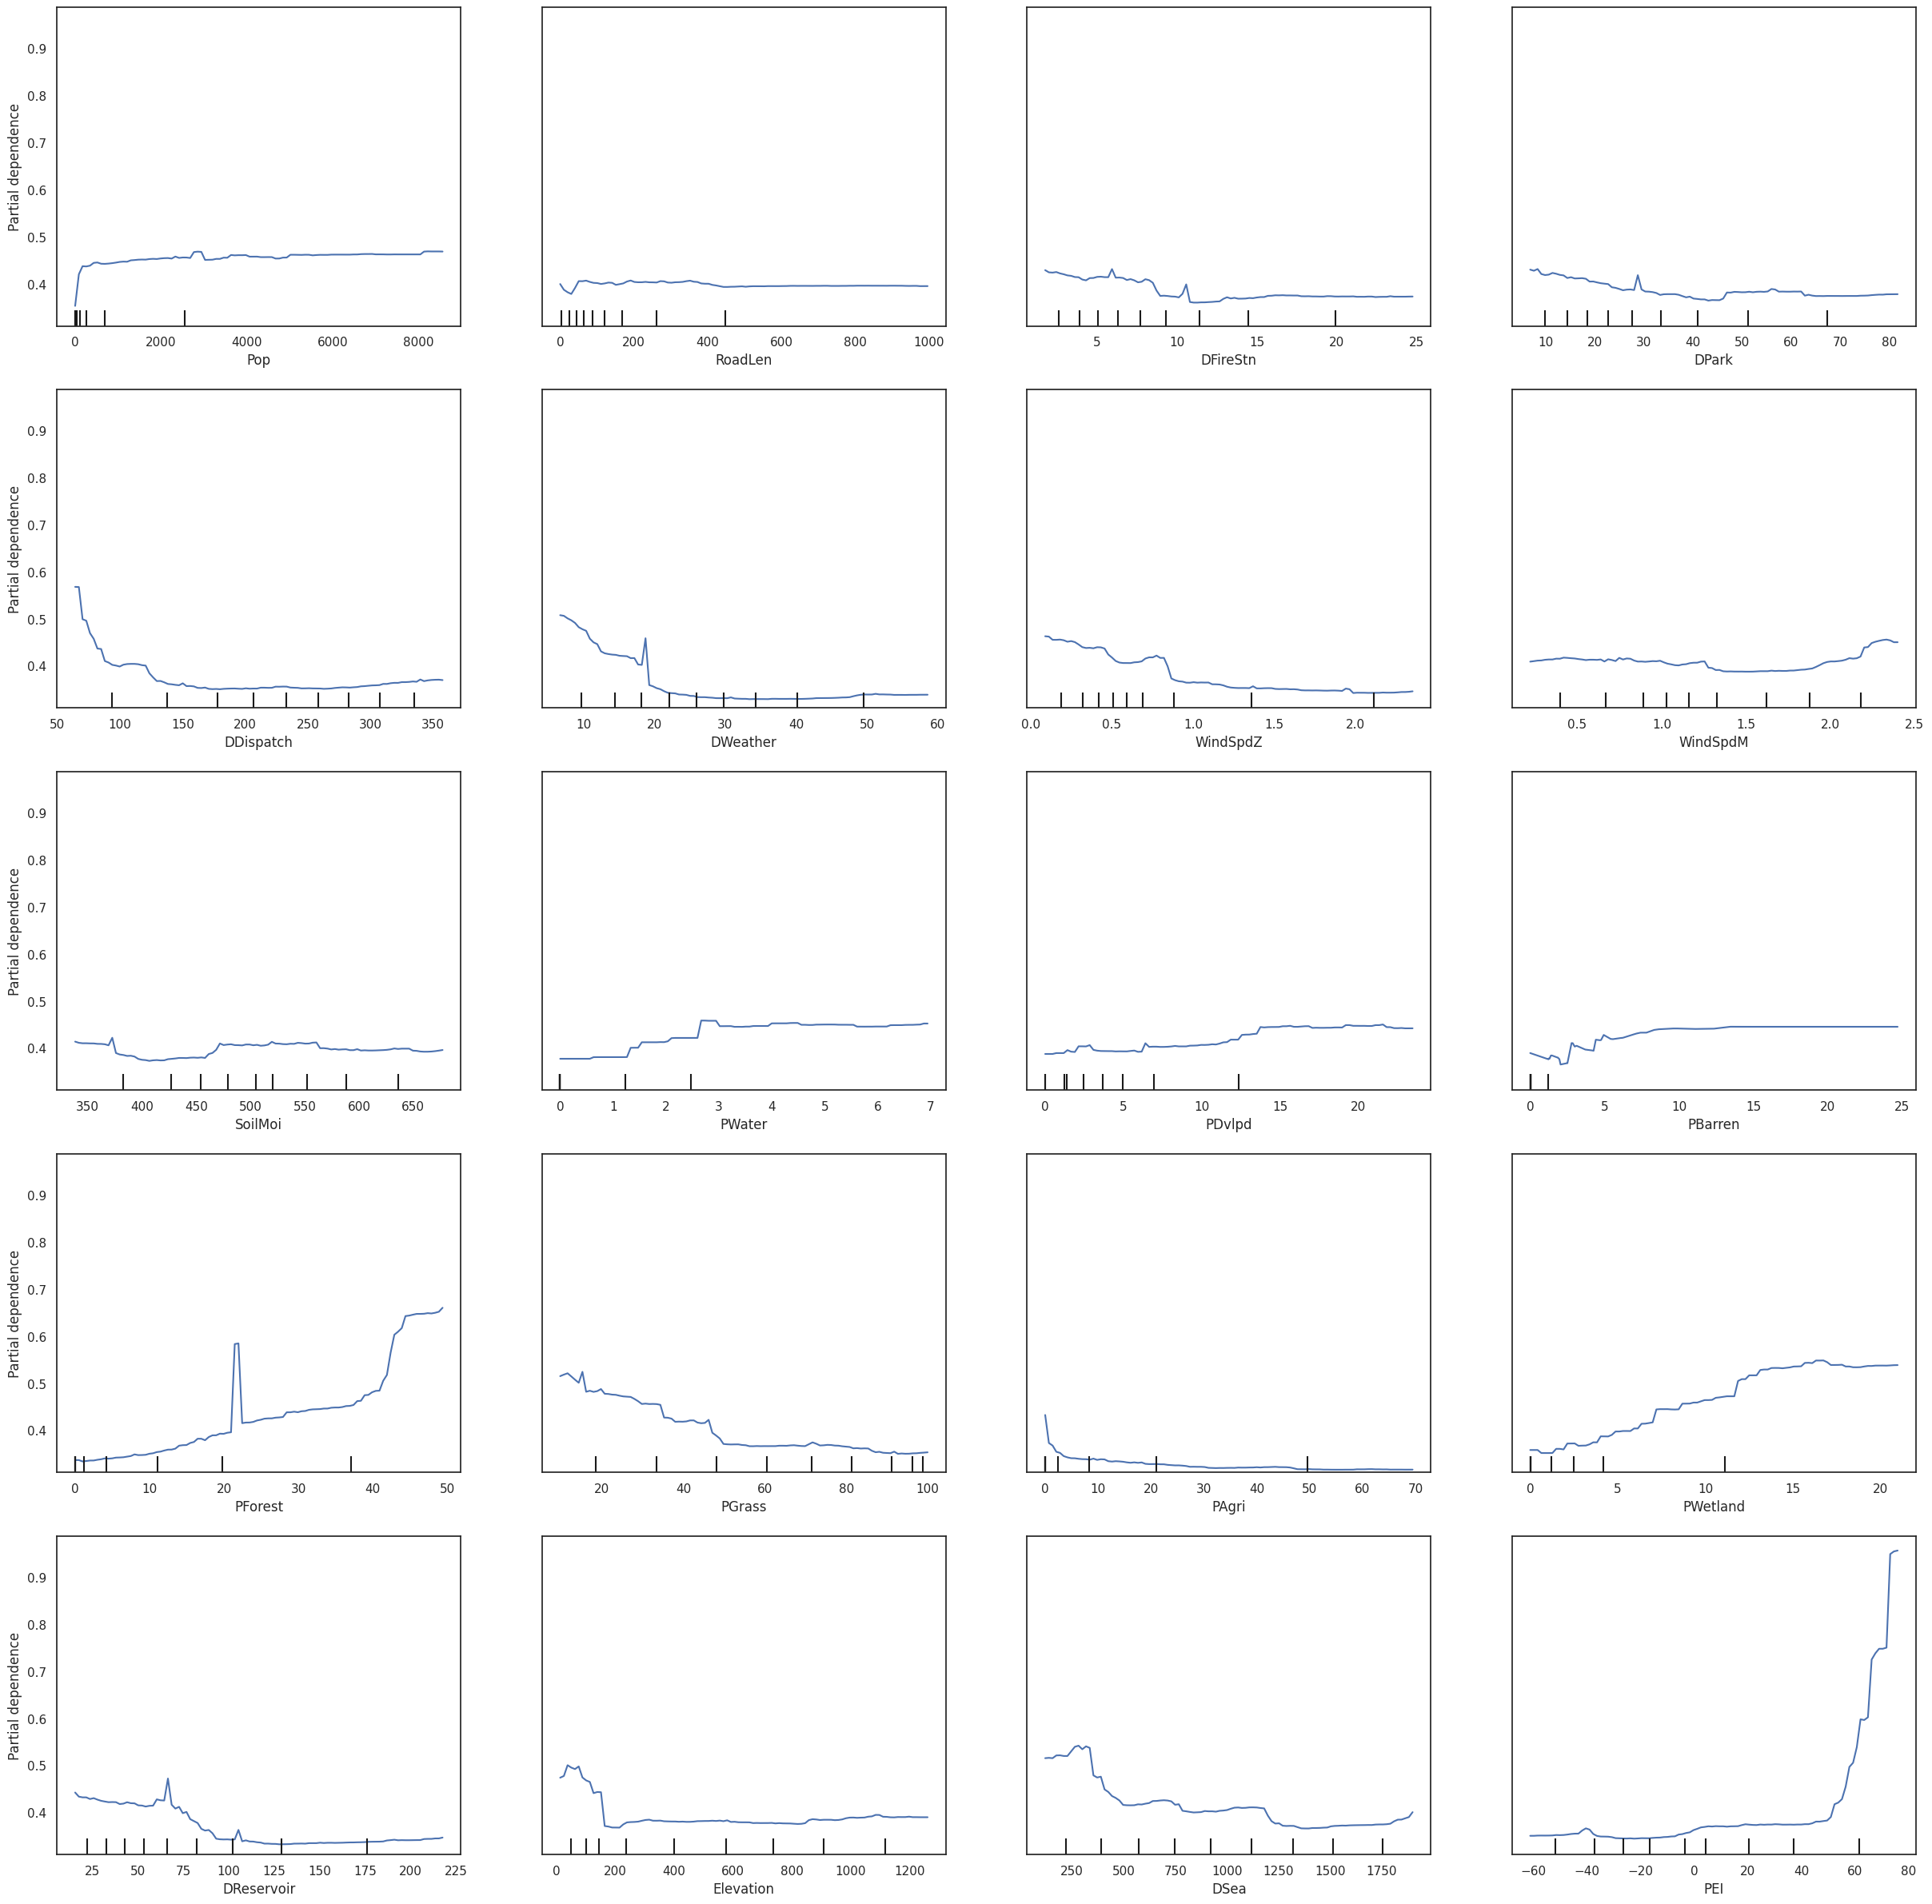

In [ ]:
## Patial Dependence Plot
# models = PartialDependenceDisplay(models_RF,X_train,)
fig, ax = plt.subplots(figsize=(30, 30),nrows=5, ncols=4, sharey=False)
pics = PartialDependenceDisplay.from_estimator(models_RF['random_forest']['fitted'], X_train,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],ax=ax)
    # fig, axes = pdp.pdp_plot(
    #     pdp_isolate_out=pdp_feat_df, center=True,\
    #     x_quantile=True, ncols=2, plot_lines=True,\
    #     frac_to_plot=100, figsize=(8,10),\
    #     feature_name=feature_labels[i],
    #     plot_params={
    #         'title':None,
    #         "subtitle":None,
    #     }
    # )
    # try:
    #     labels = [item.get_text() for item in axes['pdp_ax'].xaxis.get_ticklabels()]
    #     for x in labels:
    #       if i == 0:
    #         labels[labels.index(x)] = str(float(x))
    #       else:
    #         labels[labels.index(x)] = str(int(float(x)))

    #     axes['pdp_ax'].xaxis.set_ticklabels(labels)
    # except:
    #     pass
    
    # # print(dir(axes['pdp_ax'].xaxis))
    # fig.savefig("/content/drive/MyDrive/Projects/20220529_ClusteringResearch/pic/cyc_{}.png".format(feature_names[i]),dpi=600)

# PDP(models_RF)


### 4.1.8 Save the Dataset for R code



In [ ]:
dfR = df.drop(columns=["SurSkiTem",'Preciptation', 'Evapotrans','SurRunoff'])

#If you have the results from part 2, just read the file from Google Drive
# df = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/Wildfire.shp")

#If no, read the file from Github
df = gpd.read_file("UrbanDS_Team-main/Data/Wildfire/Wildfire.shp")

df = df[['IDcw',"geometry"]]
dfR = df.merge(dfR,left_index=True,right_index=True)
dfR.head()

IDcw                                           geometry    Pop  RoadLen  \
0   445  POLYGON ((3223024.821 8500723.916, 3223024.821...  41386   383.77   
1   446  POLYGON ((3249424.821 8500723.916, 3249424.821...   3426    78.34   
2   609  POLYGON ((3196624.821 8527123.916, 3196624.821...   5893   252.49   
3   610  POLYGON ((3223024.821 8527123.916, 3223024.821...  12423   143.71   
4   611  POLYGON ((3249424.821 8527123.916, 3249424.821...    855    63.85   

   DFireStn  DPark  DDispatch  DWeather  WindSpdZ  WindSpdM  ...  PBarren  \
0      5.01   5.08     401.28     18.77      2.32      0.59  ...     0.00   
1      2.25  10.08     399.47     17.26      2.44      0.67  ...     4.17   
2      6.56   5.01     398.53     17.64      2.46      0.63  ...     1.39   
3      8.49   7.14     396.64     14.39      2.50      0.64  ...     2.78   
4      7.21  11.26     394.80     12.36      2.55      0.70  ...     4.69   

   PForest  PGrass  PAgri  PWetland  DReservoir  Elevation  DSea  WDD    PEI  
0     1.23   17.28  19.75     17.28       12.64       5.55 67.42 0.00 -23.75  
1     1.39   25.00   2.78     41.67        3.84       3.18 51.35 0.43  -8.91  
2     2.78    9.72  59.72      6.94       32.81       9.09 87.22 0.00 -25.70  
3     2.78   31.94  23.61     23.61       19.94       6.61 71.85 0.00 -15.01  
4     0.00   23.44   4.69     64.06       15.89       3.06 56.61 0.00  -2.67  

[5 rows x 23 columns]

In [ ]:
dfR.columns

Index(['IDcw', 'geometry', 'Pop', 'RoadLen', 'DFireStn', 'DPark', 'DDispatch',
       'DWeather', 'WindSpdZ', 'WindSpdM', 'SoilMoi', 'PWater', 'PDvlpd',
       'PBarren', 'PForest', 'PGrass', 'PAgri', 'PWetland', 'DReservoir',
       'Elevation', 'DSea', 'WDD', 'PEI'],
      dtype='object')

In [ ]:
dfR.to_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/WildfireForR.shp")

## 4.2 Geographically Weighted Random Forest (In R)
- Spatial heterogeineity

4.2.1 Data Preprocess- Get the latitude and longitude of centroid for the grids

In [ ]:
import geopandas as gpd

In [ ]:
url = "https://github.com/UrbanDS/UrbanDS_Team/archive/refs/heads/main.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#If you have the results from part 4.1, just read the file from Google Drive
# gdf = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/WildfireForR.shp")

#If no, read the file from Github
gdf = gpd.read_file("UrbanDS_Team-main/Data/WildfireForR/WildfireForR.shp")

gdf = gdf.to_crs(epsg=4326)
gdf['centroid'] = gdf.centroid
gdf['lat'] = gdf.centroid.y
gdf['lon'] = gdf.centroid.x
gdf.columns 

Index(['IDcw', 'Pop', 'RoadLen', 'DFireStn', 'DPark', 'DDispatch', 'DWeather',
       'WindSpdZ', 'WindSpdM', 'SoilMoi', 'PWater', 'PDvlpd', 'PBarren',
       'PForest', 'PGrass', 'PAgri', 'PWetland', 'DReservoir', 'Elevation',
       'DSea', 'WDD', 'PEI', 'geometry', 'centroid', 'lat', 'lon'],
      dtype='object')

In [ ]:
gdf[['centroid','lat','lon']].head()

centroid        lat        lon
0  POINT (-97.48309 25.98507)  25.985069 -97.483094
1  POINT (-97.40305 25.98319)  25.983189 -97.403051
2  POINT (-97.56115 26.05925)  26.059247 -97.561145
3  POINT (-97.48104 26.05742)  26.057417 -97.481041
4  POINT (-97.40094 26.05554)  26.055535 -97.400940

In [ ]:
df = gdf.drop(columns=['geometry','centroid'])

In [ ]:
df = df.fillna(0)

In [ ]:
# from sklearn.model_selection import train_test_split
# rand=1

# def split_dataset(dfX, dfY):
#   X_train, X_test, y_train, y_test = train_test_split(dfX,dfY, test_size=0.2, random_state=rand)
#   return X_train, X_test, y_train, y_test 
# dfX = df[['WDD']]
# dfY = df.drop(columns=["WDD"])
# X_train, X_test,y_train,y_test = split_dataset(dfX, dfY)
# df_train = X_train.merge(y_train,left_index=True, right_index=True)
# df_test  = X_test.merge(y_test,left_index=True, right_index=True)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
!pip install rpy2==3.5.1

In [ ]:
%%R
install.packages("SpatialML", dependencies=TRUE, repos='https://mirrors.nics.utk.edu/cran/')

In [ ]:
%%R
library(SpatialML)

In [ ]:
%%R -i df
head(df)

  IDcw   Pop RoadLen DFireStn DPark DDispatch DWeather WindSpdZ WindSpdM
0  445 41386  383.77     5.01  5.08    401.28    18.77     2.32     0.59
1  446  3426   78.34     2.25 10.08    399.47    17.26     2.44     0.67
2  609  5893  252.49     6.56  5.01    398.53    17.64     2.46     0.63
3  610 12423  143.71     8.49  7.14    396.64    14.39     2.50     0.64
4  611   855   63.85     7.21 11.26    394.80    12.36     2.55     0.70
5  612     0   39.83     3.65  7.28    393.02    12.20     2.57     0.74
  SoilMoi PWater PDvlpd PBarren PForest PGrass PAgri PWetland DReservoir
0  561.09   0.00  44.44    0.00    1.23  17.28 19.75    17.28      12.64
1  624.20   6.94  18.06    4.17    1.39  25.00  2.78    41.67       3.84
2  534.39   5.56  13.89    1.39    2.78   9.72 59.72     6.94      32.81
3  587.18   4.17  11.11    2.78    2.78  31.94 23.61    23.61      19.94
4  650.61   0.00   3.12    4.69    0.00  23.44  4.69    64.06      15.89
5  661.27  38.89   0.00    5.56    0.00  11.11  0.0

### 4.2.1 Find the Optimal Bindwidth
- very slow,

In [ ]:
%%R
Coords<-df[ ,23:24]
head(Coords)

       lat       lon
0 25.98507 -97.48309
1 25.98319 -97.40305
2 26.05925 -97.56115
3 26.05742 -97.48104
4 26.05554 -97.40094
5 26.05360 -97.32084


In [ ]:
%%R
bwe <- grf.bw(WDD~Pop+RoadLen+DFireStn+DPark+DDispatch+DWeather+WindSpdZ+WindSpdM+PEI+SoilMoi+PWater+PDvlpd+PBarren+PForest+PGrass+PAgri+PWetland+DReservoir+Elevation+DSea,df,kernel="adaptive", coords=Coords, bw.min = 500, bw.max = 510,step = 10,forests = FALSE, weighted = TRUE)

### 4.2.2 Run Geographically Weighted Random Forest and Get the Local Feature Importance 

In [ ]:
%%R
grf.model <- grf(WDD ~ Pop+RoadLen+DFireStn+DPark+DDispatch+DWeather+WindSpdZ+WindSpdM+PEI+SoilMoi+PWater+PDvlpd+PBarren+PForest+PGrass+PAgri+PWetland+DReservoir+Elevation+DSea, dframe=df, bw=100, ntree=100, mtry=2, kernel="adaptive",forests=TRUE, coords=Coords)

Number of Observations: 10404


Neightbours: 100

--------------- Global Model Summary ---------------




Ranger result

Call:
 ranger(WDD ~ Pop + RoadLen + DFireStn + DPark + DDispatch + DWeather +      WindSpdZ + WindSpdM + PEI + SoilMoi + PWater + PDvlpd + PBarren +      PForest + PGrass + PAgri + PWetland + DReservoir + Elevation +      DSea, data = df, num.trees = 100, mtry = 2, importance = "impurity",      num.threads = NULL) 

Type:                             Regression 
Number of trees:                  100 
Sample size:                      10404 
Number of independent variables:  20 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       1.971152 
R squared (OOB):                  0.2314929 


Importance:




       Pop    RoadLen   DFireStn      DPark  DDispatch   DWeather   WindSpdZ 
  772.4537   678.8873  1179.7560   953.8342  1546.6499  2302.5268  1342.3853 
  WindSpdM        PEI    SoilMoi     PWater     PDvlpd    PBarren    PForest 
 1022.4757  1755.4753  1047.4767   767.6878   759.8900   274.4600  1917.6600 
    PGrass      PAgri   PWetland DReservoir  Elevation       DSea 
 1522.0005   241.2070  1004.3566   864.5023  1260.2852  1402.7773 


Mean Square Error (Not OBB): 0.498




--------------- Local Model Summary ---------------


Residuals OOB:




     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-43.55911  -0.14588   0.00000   0.02463   0.00000  49.68883 


Residuals Predicted (Not OBB):




     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.664914 -0.017061 -0.002055  0.006192  0.000000  9.092438 


Local Variable Importance:




           Min       Max      Mean        StD
Pop          0 1304.1779  9.001045  48.191525
RoadLen      0  949.7137  7.557034  35.899294
DFireStn     0  687.2115  9.202235  40.703024
DPark        0  993.4387  9.248601  42.210975
DDispatch    0  690.6645 10.072966  43.812189
DWeather     0 1606.7941 18.681146 100.314553
WindSpdZ     0  461.2745  7.660473  31.899291
WindSpdM     0 1360.6506 11.508550  66.234895
PEI          0  676.3868  9.037188  39.674409
SoilMoi      0  829.6811  9.925162  47.460547
PWater       0  988.7884  5.661722  37.735943
PDvlpd       0 1239.9734  9.733223  61.387110
PBarren      0  602.7104  2.778268  25.002302
PForest      0 1031.9408 11.044601  52.755107
PGrass       0 1451.1374 11.921461  65.235674
PAgri        0  202.0332  1.079408   6.110161
PWetland     0  925.1666  7.688708  43.337361
DReservoir   0  754.9913  9.602522  42.072179
Elevation    0  737.9024  9.617852  41.111423
DSea         0  885.9911 10.971045  50.478902


Mean squared error (OOB): 2.334








Calculation time (in seconds): 4.0453



In [ ]:
%%R
names(grf.model)

[1] "Global.Model"              "Locations"                
[3] "Local.Variable.Importance" "LGofFit"                  
[5] "Forests"                   "LocalModelSummary"        


In [ ]:
%%R
localVI <- as.data.frame(grf.model[3])
write.csv(localVI, file = "/content/drive/MyDrive/Data science competition/Data/DataForModel/LocalVI.csv",row.names=TRUE)

### 4.2.3 Plot Local Variance Importance

In [75]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
url = "https://github.com/UrbanDS/UrbanDS_Team/archive/refs/heads/main.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [77]:
#If you have the results from part 4.1, just read the file from Google Drive
# gdf = gpd.read_file("/content/drive/MyDrive/Data science competition/Data/DataForModel/WildfireForR.shp")

#If no, read the file from Github
gdf = gpd.read_file("UrbanDS_Team-main/Data/WildfireForR/WildfireForR.shp")

gdf = gdf[['IDcw',"geometry","WDD"]]
gdf.to_crs(epsg=4326,inplace=True)

In [78]:
#If you have the results from part 4.2.2, just read the file from Google Drive
# localVI = pd.read_csv("/content/drive/MyDrive/Data science competition/Data/DataForModel/LocalVI.csv")
#If no, read the file from Github
localVI = pd.read_csv("UrbanDS_Team-main/Data/LocalVI.csv")

localVI.head()

Unnamed: 0  Local.Variable.Importance.Pop  \
0           1                       0.537690   
1           2                       0.608527   
2           3                       0.443397   
3           4                       0.466328   
4           5                       0.367397   

   Local.Variable.Importance.RoadLen  Local.Variable.Importance.DFireStn  \
0                           0.288222                            0.369422   
1                           0.415328                            0.503176   
2                           0.334282                            0.419793   
3                           0.281374                            0.570034   
4                           0.609241                            0.545550   

   Local.Variable.Importance.DPark  Local.Variable.Importance.DDispatch  \
0                         0.307409                             0.519591   
1                         0.316756                             0.493534   
2                         0.376690                             0.667259   
3                         0.400469                             0.845080   
4                         0.276031                             0.397142   

   Local.Variable.Importance.DWeather  Local.Variable.Importance.WindSpdZ  \
0                            1.337616                            0.532694   
1                            0.859994                            0.664269   
2                            0.856166                            0.514999   
3                            0.963327                            0.871088   
4                            1.345063                            0.923331   

   Local.Variable.Importance.WindSpdM  Local.Variable.Importance.PEI  ...  \
0                            0.453354                       0.731343  ...   
1                            0.283836                       0.572305  ...   
2                            0.231476                       1.068195  ...   
3                            0.214148                       0.695267  ...   
4                            0.322060                       0.621246  ...   

   Local.Variable.Importance.PWater  Local.Variable.Importance.PDvlpd  \
0                          0.361130                          0.675218   
1                          0.203425                          0.575303   
2                          0.290711                          0.376772   
3                          0.390918                          0.353363   
4                          0.509270                          0.303249   

   Local.Variable.Importance.PBarren  Local.Variable.Importance.PForest  \
0                           1.181695                           0.154414   
1                           1.229453                           0.161763   
2                           1.435081                           0.157846   
3                           1.006224                           0.199960   
4                           1.564404                           0.153989   

   Local.Variable.Importance.PGrass  Local.Variable.Importance.PAgri  \
0                          0.718545                         0.565860   
1                          0.456088                         0.750577   
2                          0.645046                         0.215977   
3                          0.273901                         0.313358   
4                          0.795769                         0.293957   

   Local.Variable.Importance.PWetland  Local.Variable.Importance.DReservoir  \
0                            0.980367                              0.395859   
1                            0.929214                              0.446602   
2                            0.989512                              0.418273   
3                            0.918877                              0.673544   
4                            1.013925                              0.238739   

   Local.Variable.Importance.Elevation  Local.Variable.Importance.DSea  
0        

In [79]:
gdf = gdf.merge(localVI,left_index=True,right_index=True)

In [80]:
gdf.columns

Index(['IDcw', 'geometry', 'WDD', 'Unnamed: 0',
       'Local.Variable.Importance.Pop', 'Local.Variable.Importance.RoadLen',
       'Local.Variable.Importance.DFireStn', 'Local.Variable.Importance.DPark',
       'Local.Variable.Importance.DDispatch',
       'Local.Variable.Importance.DWeather',
       'Local.Variable.Importance.WindSpdZ',
       'Local.Variable.Importance.WindSpdM', 'Local.Variable.Importance.PEI',
       'Local.Variable.Importance.SoilMoi', 'Local.Variable.Importance.PWater',
       'Local.Variable.Importance.PDvlpd', 'Local.Variable.Importance.PBarren',
       'Local.Variable.Importance.PForest', 'Local.Variable.Importance.PGrass',
       'Local.Variable.Importance.PAgri', 'Local.Variable.Importance.PWetland',
       'Local.Variable.Importance.DReservoir',
       'Local.Variable.Importance.Elevation',
       'Local.Variable.Importance.DSea'],
      dtype='object')

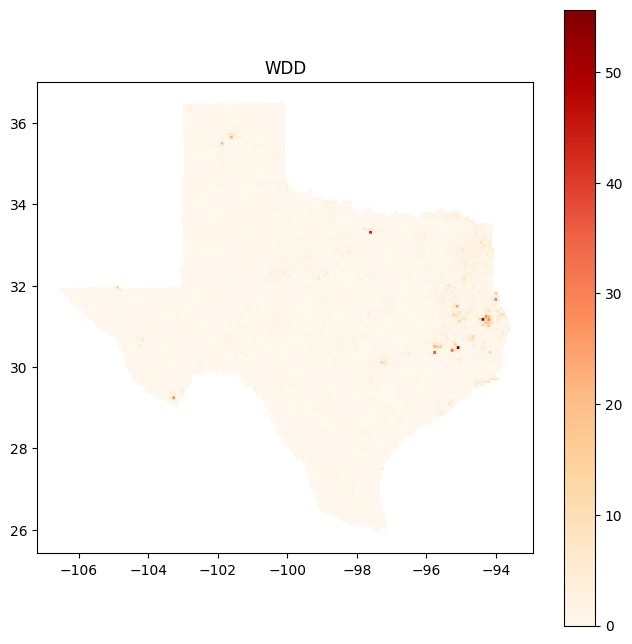

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='WDD',cmap="OrRd",legend=True, ax=ax)
plt.title("WDD")
plt.show()

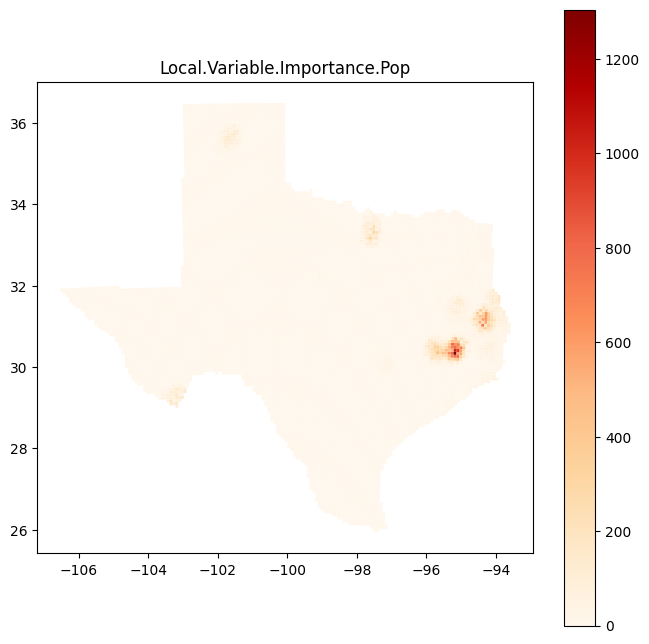

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.Pop',cmap="OrRd",legend=True, ax=ax)
plt.title("Local.Variable.Importance.Pop")
plt.show()

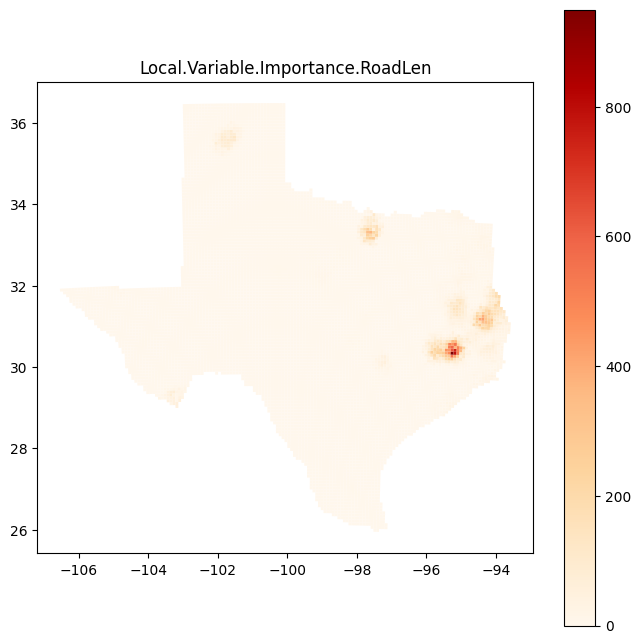

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.RoadLen',cmap="OrRd",legend=True, ax=ax)
plt.title("Local.Variable.Importance.RoadLen")
plt.show()

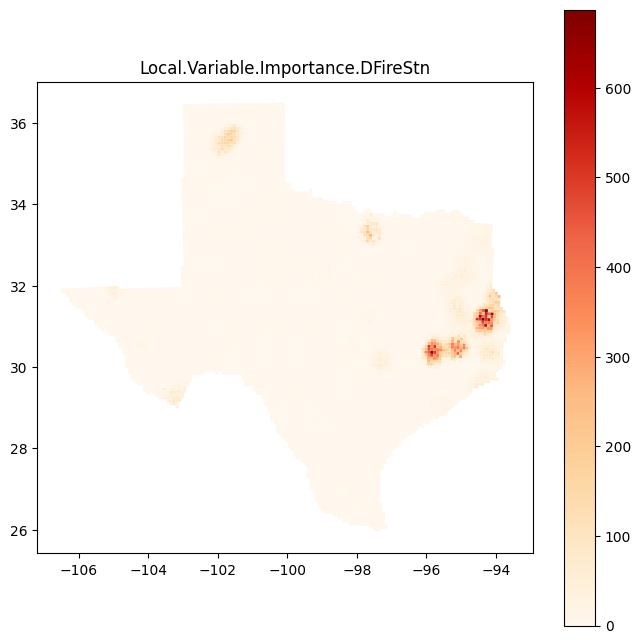

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.DFireStn',cmap="OrRd",legend=True, ax=ax)
plt.title("Local.Variable.Importance.DFireStn")
plt.show()

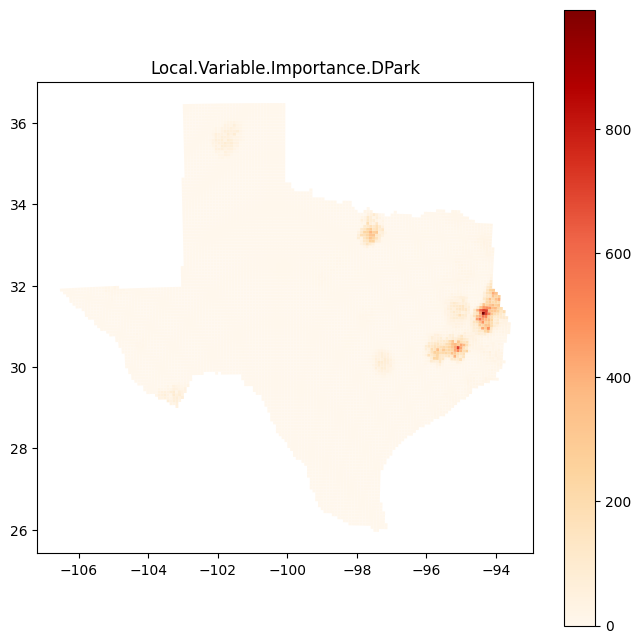

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.DPark',cmap="OrRd",legend=True, ax=ax)
plt.title("Local.Variable.Importance.DPark")
plt.show()

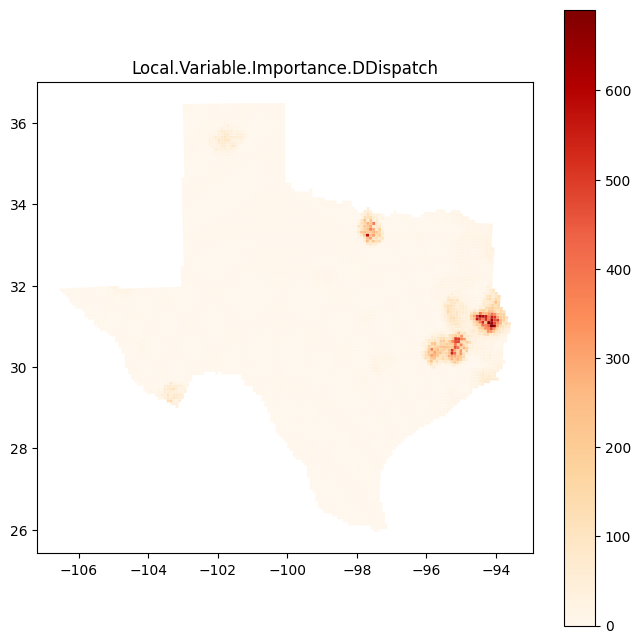

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.DDispatch',cmap="OrRd",legend=True, ax=ax)
plt.title("Local.Variable.Importance.DDispatch")
plt.show()

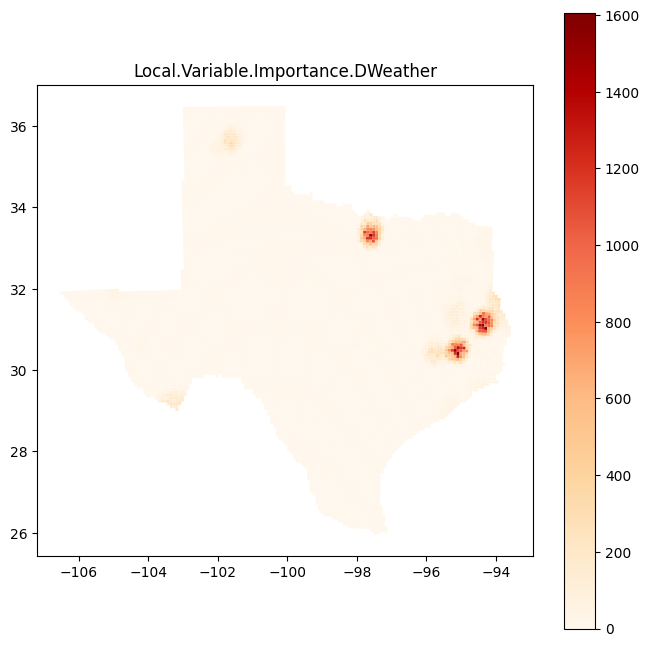

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.DWeather',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.DWeather')
plt.show()

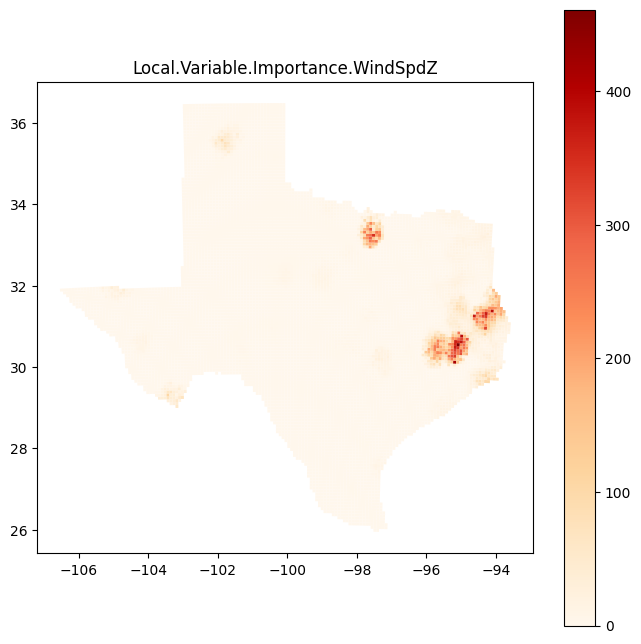

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.WindSpdZ',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.WindSpdZ')
plt.show()

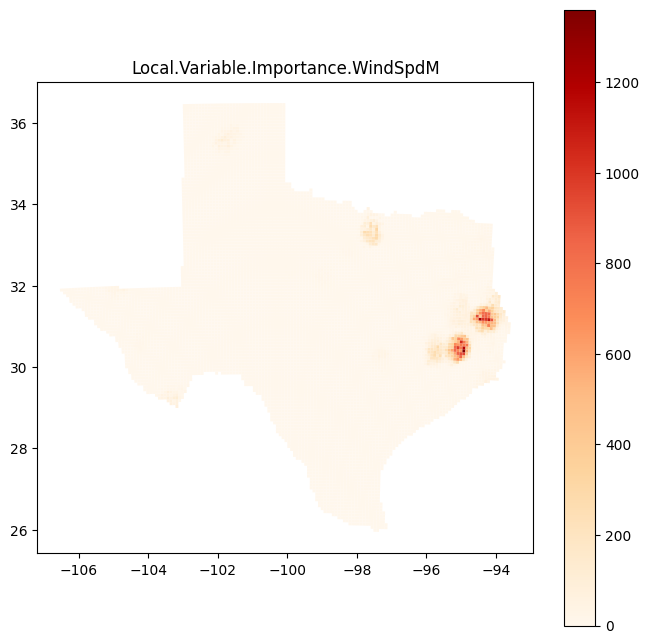

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column= 'Local.Variable.Importance.WindSpdM',cmap="OrRd",legend=True, ax=ax)
plt.title( 'Local.Variable.Importance.WindSpdM')
plt.show()

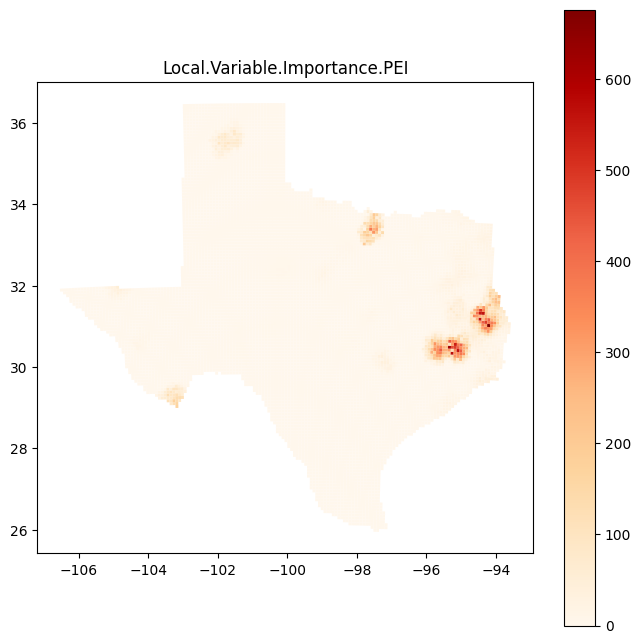

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column=  'Local.Variable.Importance.PEI',cmap="OrRd",legend=True, ax=ax)
plt.title( 'Local.Variable.Importance.PEI')
plt.show()

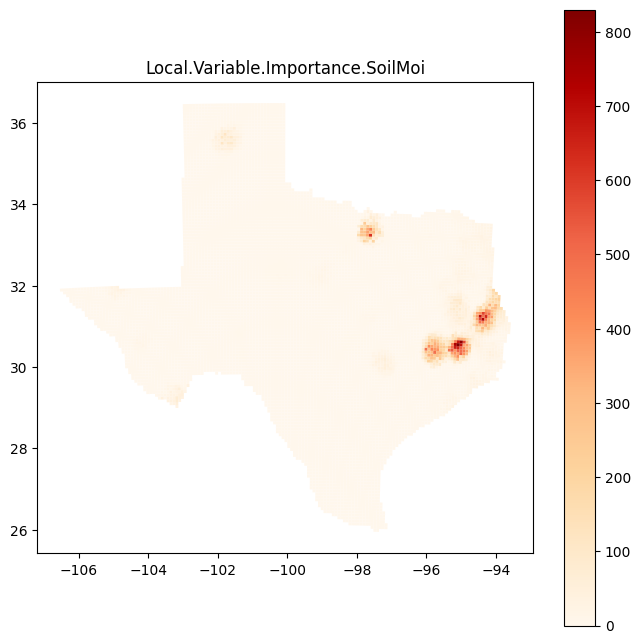

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column=  'Local.Variable.Importance.SoilMoi',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.SoilMoi')
plt.show()

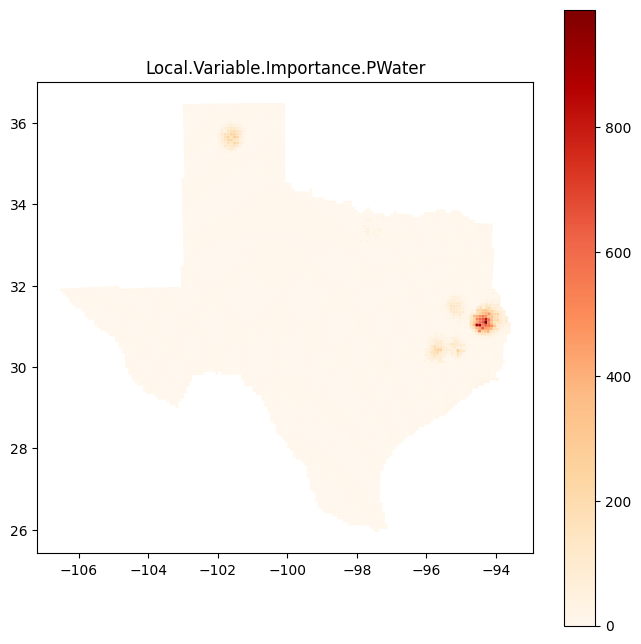

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column=  'Local.Variable.Importance.PWater',cmap="OrRd",legend=True, ax=ax)
plt.title( 'Local.Variable.Importance.PWater')
plt.show()

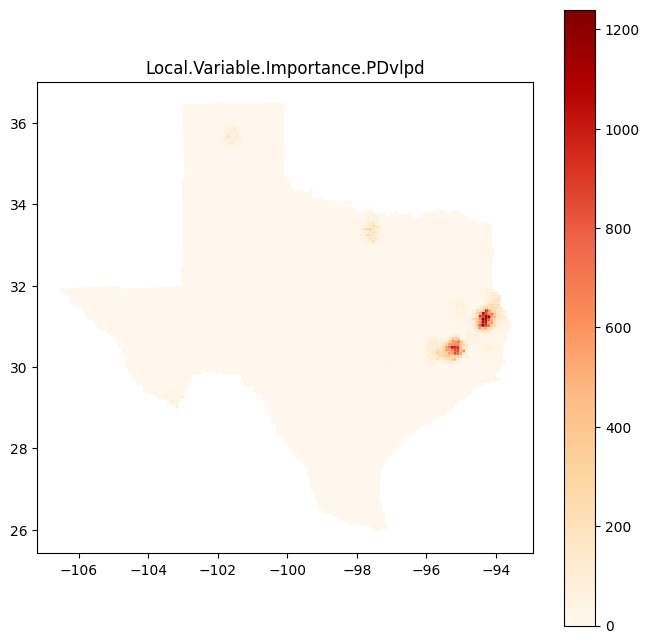

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column= 'Local.Variable.Importance.PDvlpd',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.PDvlpd')
plt.show()

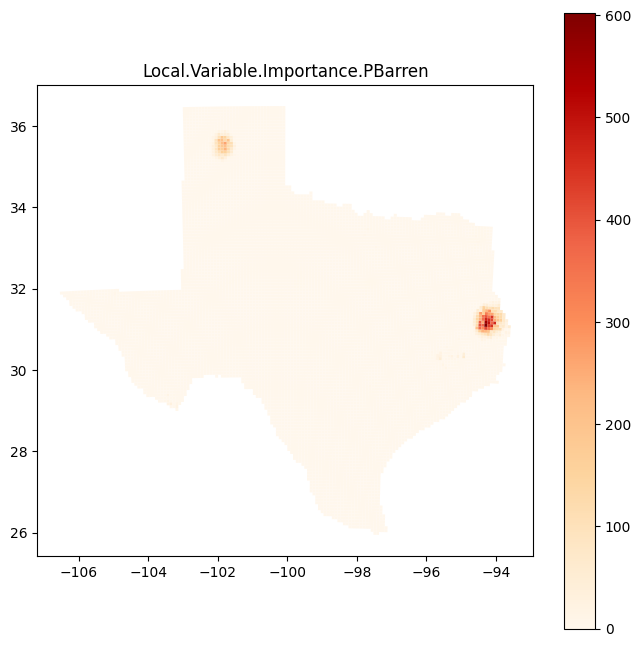

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column= 'Local.Variable.Importance.PBarren',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.PBarren')
plt.show()

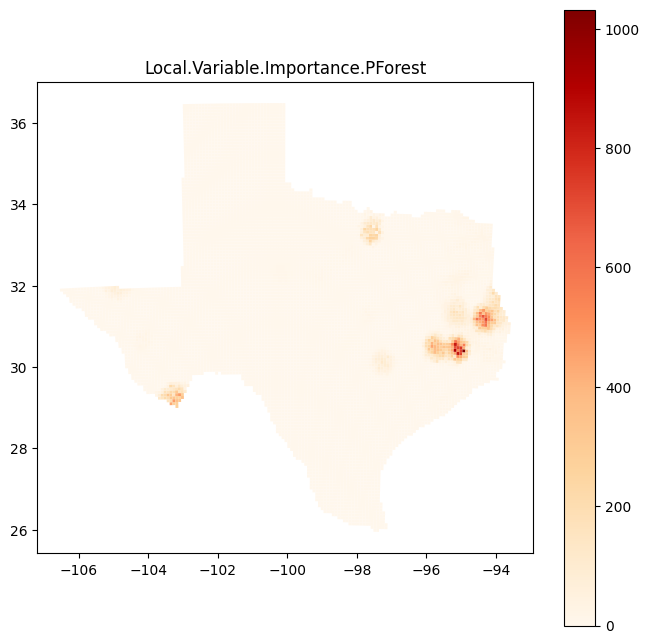

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column= 'Local.Variable.Importance.PForest',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.PForest')
plt.show()

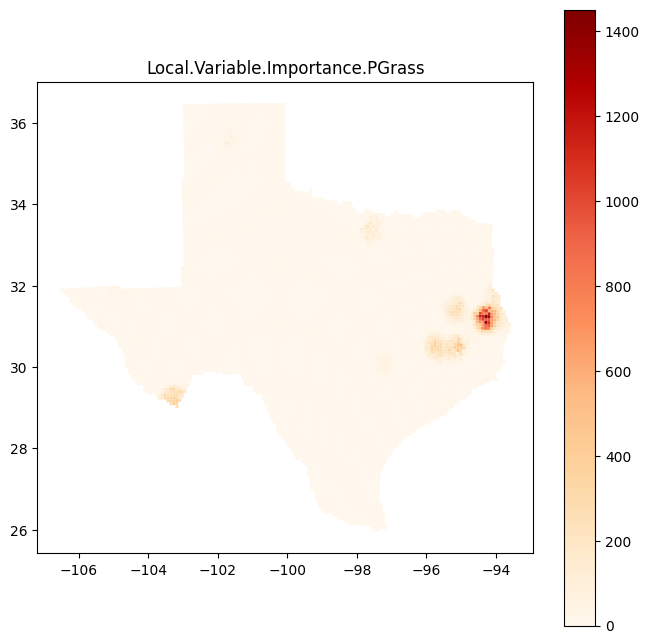

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.PGrass',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.PGrass')
plt.show()

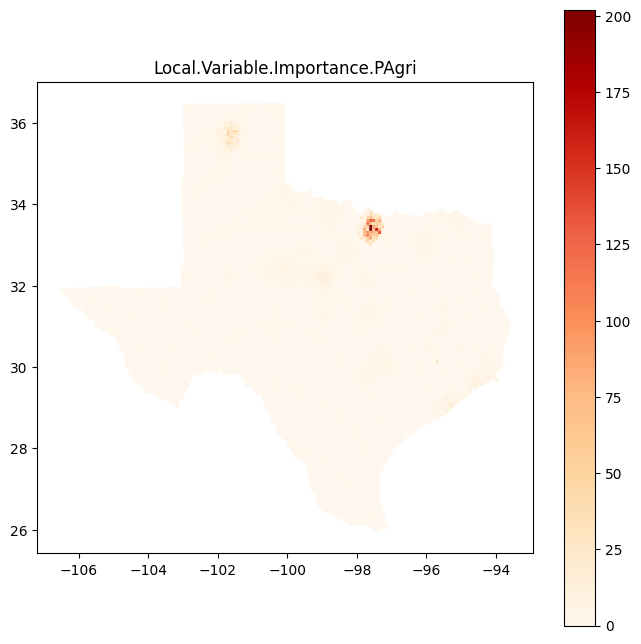

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.PAgri',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.PAgri')
plt.show()

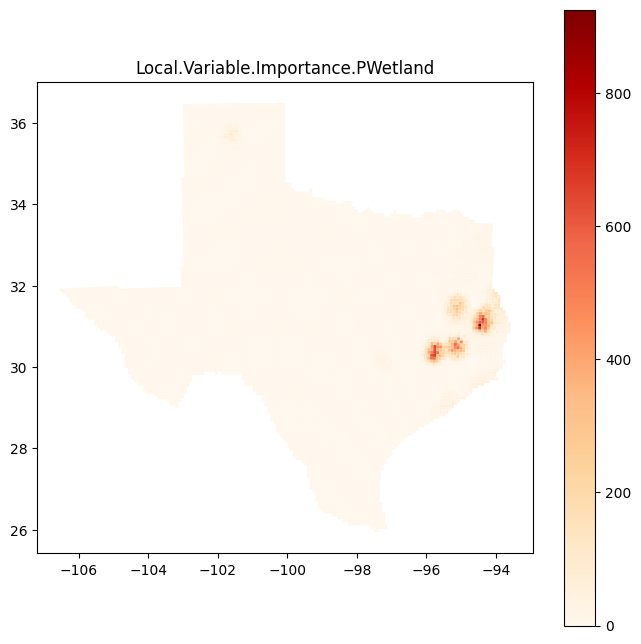

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.PWetland',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.PWetland')
plt.show()

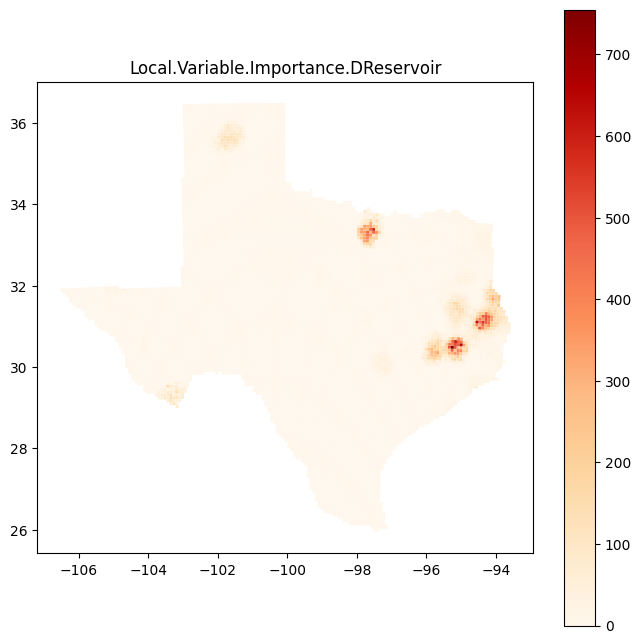

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.DReservoir',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.DReservoir')
plt.show()

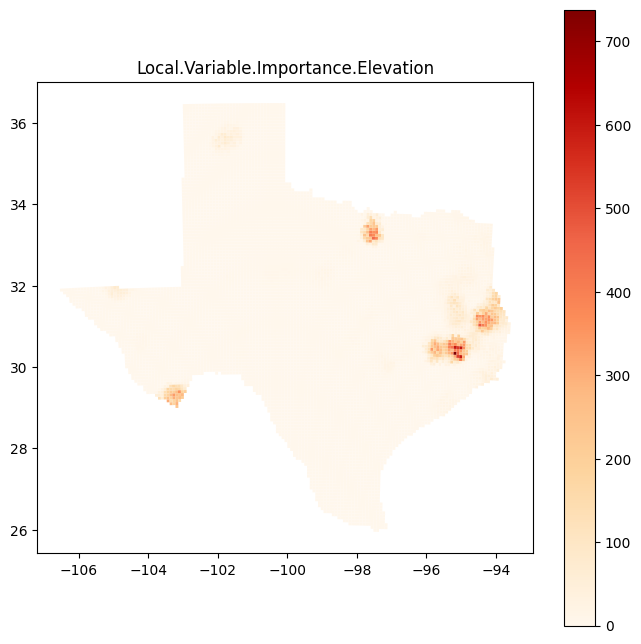

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.Elevation',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.Elevation')
plt.show()

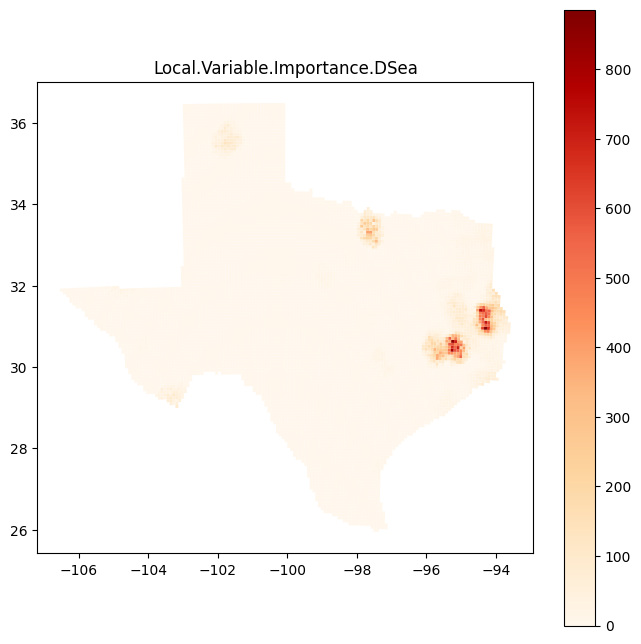

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column='Local.Variable.Importance.DSea',cmap="OrRd",legend=True, ax=ax)
plt.title('Local.Variable.Importance.DSea')
plt.show()